Load data 

In [1]:
import midaa as maa
import scanpy as sc
import numpy as np
import pyro

# Load the real dataset
adata_beta_hfd = sc.read_h5ad(r"data/beta_cells_hfd.h5ad")

# Convert to MIDAA input
input_matrix, norm_factors, input_distribution = maa.get_input_params_adata(adata_beta_hfd)

# If you want to force RNA-seq likelihood, uncomment the next line:
# input_distribution = ["NB"]

# Check input matrix
print("Number of input matrices:", len(input_matrix))         # should be 1
print("Shape of first input matrix:", input_matrix[0].shape)  # e.g., (2638, 1838)

# Number of archetypes
narchetypes = 3

# Check normalization factors
print("Number of norm factors:", len(norm_factors))
print("Shape of first norm factor array:", norm_factors[0].shape)
print("First 5 norm factor values:", norm_factors[0][:5])

# Input distribution
print("Input distribution:", input_distribution)  # usually ["NB"] for RNA-seq

# Convert sparse matrix to dense if needed
X = input_matrix[0].A if hasattr(input_matrix[0], "A") else input_matrix[0]
print("Min value in X:", X.min())
print("Any negatives?", (X < 0).sum())

# Pyro version
print("Pyro version:", pyro.__version__)  # should be 1.9.1

# Extra checks
print("Min:", X.min(), "Max:", X.max(), "NaNs:", np.isnan(X).sum())
print("Norm factors min:", norm_factors[0].min())


Number of input matrices: 1
Shape of first input matrix: (3887, 16483)
Number of norm factors: 1
Shape of first norm factor array: (3887,)
First 5 norm factor values: [1. 1. 1. 1. 1.]
Input distribution: ['G']
Min value in X: 0.0
Any negatives? 0
Pyro version: 1.9.1
Min: 0.0 Max: 74.91528 NaNs: 0
Norm factors min: 1.0


Run model

In [3]:
# Fit MIDAA
aa_result = maa.fit_MIDAA(
    input_matrix,
    norm_factors,
    input_distribution,
    narchetypes=4,
    torch_seed=42,
    
)

Bar desc:   0%|          | 0/2000 [00:00<?, ?it/s]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=1 max=1 any_neg=False
[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=1 max=1 any_neg=False


ELBO: 128543032.00000  :   0%|          | 1/2000 [00:13<7:41:52, 13.86s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.995018 max=1.00501 any_neg=False


ELBO: 125975520.00000  :   0%|          | 2/2000 [00:23<6:11:33, 11.16s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.990067 max=1.01003 any_neg=False


ELBO: 124606304.00000  :   0%|          | 3/2000 [00:31<5:30:30,  9.93s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.985146 max=1.01508 any_neg=False


ELBO: 125664216.00000  :   0%|          | 4/2000 [00:40<5:11:05,  9.35s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.980255 max=1.02014 any_neg=False


ELBO: 124641336.00000  :   0%|          | 5/2000 [00:47<4:44:12,  8.55s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.975394 max=1.02523 any_neg=False


ELBO: 122853776.00000  :   0%|          | 6/2000 [00:53<4:17:49,  7.76s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.970563 max=1.03033 any_neg=False


ELBO: 123175208.00000  :   0%|          | 7/2000 [00:59<3:58:34,  7.18s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.965761 max=1.03545 any_neg=False


ELBO: 121805984.00000  :   0%|          | 8/2000 [01:05<3:42:52,  6.71s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.960988 max=1.0406 any_neg=False


ELBO: 119674352.00000  :   0%|          | 9/2000 [01:10<3:25:09,  6.18s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.956244 max=1.04576 any_neg=False


ELBO: 120812784.00000  :   0%|          | 10/2000 [01:15<3:12:17,  5.80s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.951529 max=1.05094 any_neg=False


ELBO: 118133728.00000  :   1%|          | 11/2000 [01:20<3:05:28,  5.59s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.946843 max=1.05614 any_neg=False


ELBO: 117232392.00000  :   1%|          | 12/2000 [01:25<3:00:34,  5.45s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.942185 max=1.06136 any_neg=False


ELBO: 115401360.00000  :   1%|          | 13/2000 [01:30<2:57:23,  5.36s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.937556 max=1.0666 any_neg=False


ELBO: 114222344.00000  :   1%|          | 14/2000 [01:35<2:58:20,  5.39s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.932954 max=1.07186 any_neg=False


ELBO: 113186352.00000  :   1%|          | 15/2000 [01:41<3:00:00,  5.44s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.928381 max=1.07714 any_neg=False


ELBO: 111910744.00000  :   1%|          | 16/2000 [01:47<3:08:44,  5.71s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.923835 max=1.08244 any_neg=False


ELBO: 110699480.00000  :   1%|          | 17/2000 [01:54<3:17:18,  5.97s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.919316 max=1.08776 any_neg=False


ELBO: 109557912.00000  :   1%|          | 18/2000 [02:01<3:31:44,  6.41s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.914825 max=1.09311 any_neg=False


ELBO: 108438752.00000  :   1%|          | 19/2000 [02:09<3:40:13,  6.67s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.910361 max=1.09847 any_neg=False


ELBO: 107398128.00000  :   1%|          | 20/2000 [02:17<3:56:33,  7.17s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.905923 max=1.10385 any_neg=False


ELBO: 106461360.00000  :   1%|          | 21/2000 [02:25<4:02:49,  7.36s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.901513 max=1.10925 any_neg=False


ELBO: 105520512.00000  :   1%|          | 22/2000 [02:33<4:10:46,  7.61s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.897129 max=1.11467 any_neg=False


ELBO: 104610888.00000  :   1%|          | 23/2000 [02:40<4:06:15,  7.47s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.892771 max=1.12011 any_neg=False


ELBO: 103682480.00000  :   1%|          | 24/2000 [02:47<4:02:26,  7.36s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.888439 max=1.12557 any_neg=False


ELBO: 102821192.00000  :   1%|▏         | 25/2000 [02:54<3:53:03,  7.08s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.884133 max=1.13105 any_neg=False


ELBO: 101949976.00000  :   1%|▏         | 26/2000 [02:59<3:41:02,  6.72s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.879853 max=1.13655 any_neg=False


ELBO: 101098368.00000  :   1%|▏         | 27/2000 [03:05<3:29:46,  6.38s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.875599 max=1.14208 any_neg=False


ELBO: 100244120.00000  :   1%|▏         | 28/2000 [03:10<3:17:39,  6.01s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.87137 max=1.14762 any_neg=False


ELBO: 99414040.00000  :   1%|▏         | 29/2000 [03:15<3:06:16,  5.67s/it] 

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.867167 max=1.15318 any_neg=False


ELBO: 98562872.00000  :   2%|▏         | 30/2000 [03:20<3:03:09,  5.58s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.862988 max=1.15876 any_neg=False


ELBO: 97733328.00000  :   2%|▏         | 31/2000 [03:26<3:01:23,  5.53s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.858835 max=1.16437 any_neg=False


ELBO: 96972600.00000  :   2%|▏         | 32/2000 [03:32<3:11:12,  5.83s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.854706 max=1.16999 any_neg=False


ELBO: 96126536.00000  :   2%|▏         | 33/2000 [03:39<3:18:57,  6.07s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.850601 max=1.17564 any_neg=False


ELBO: 95341912.00000  :   2%|▏         | 34/2000 [03:47<3:37:30,  6.64s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.846521 max=1.18131 any_neg=False


ELBO: 94565160.00000  :   2%|▏         | 35/2000 [03:55<3:48:49,  6.99s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.842466 max=1.18699 any_neg=False


ELBO: 93795072.00000  :   2%|▏         | 36/2000 [04:03<3:59:38,  7.32s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.838434 max=1.1927 any_neg=False


ELBO: 93034560.00000  :   2%|▏         | 37/2000 [04:11<4:04:09,  7.46s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.834426 max=1.19843 any_neg=False


ELBO: 92273112.00000  :   2%|▏         | 38/2000 [04:19<4:11:49,  7.70s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.830442 max=1.20418 any_neg=False


ELBO: 91554672.00000  :   2%|▏         | 39/2000 [04:26<4:10:04,  7.65s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.826482 max=1.20995 any_neg=False


ELBO: 90856024.00000  :   2%|▏         | 40/2000 [04:34<4:03:44,  7.46s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.822545 max=1.21574 any_neg=False


ELBO: 90143888.00000  :   2%|▏         | 41/2000 [04:39<3:48:45,  7.01s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.818631 max=1.22155 any_neg=False


ELBO: 89443856.00000  :   2%|▏         | 42/2000 [04:45<3:36:27,  6.63s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.814741 max=1.22738 any_neg=False


ELBO: 88767656.00000  :   2%|▏         | 43/2000 [04:51<3:25:05,  6.29s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.810873 max=1.23324 any_neg=False


ELBO: 88095152.00000  :   2%|▏         | 44/2000 [04:56<3:14:30,  5.97s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.807028 max=1.23911 any_neg=False


ELBO: 87453928.00000  :   2%|▏         | 45/2000 [05:01<3:04:30,  5.66s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.803205 max=1.24501 any_neg=False


ELBO: 86816488.00000  :   2%|▏         | 46/2000 [05:06<3:03:38,  5.64s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.799406 max=1.25093 any_neg=False


ELBO: 86191880.00000  :   2%|▏         | 47/2000 [05:12<3:05:25,  5.70s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.795628 max=1.25687 any_neg=False


ELBO: 85591264.00000  :   2%|▏         | 48/2000 [05:20<3:21:47,  6.20s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.791873 max=1.26283 any_neg=False


ELBO: 85007744.00000  :   2%|▏         | 49/2000 [05:27<3:36:32,  6.66s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.788139 max=1.26881 any_neg=False


ELBO: 84431424.00000  :   2%|▎         | 50/2000 [05:35<3:46:48,  6.98s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.784428 max=1.27481 any_neg=False


ELBO: 83894888.00000  :   3%|▎         | 51/2000 [05:43<3:58:45,  7.35s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.780738 max=1.28084 any_neg=False


ELBO: 83384816.00000  :   3%|▎         | 52/2000 [05:54<4:28:41,  8.28s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.77707 max=1.28689 any_neg=False


ELBO: 82849680.00000  :   3%|▎         | 53/2000 [06:05<4:59:14,  9.22s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.773423 max=1.29295 any_neg=False


ELBO: 82333008.00000  :   3%|▎         | 54/2000 [06:16<5:14:11,  9.69s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.769798 max=1.29904 any_neg=False


ELBO: 81849752.00000  :   3%|▎         | 55/2000 [06:26<5:18:12,  9.82s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.766193 max=1.30515 any_neg=False


ELBO: 81370920.00000  :   3%|▎         | 56/2000 [06:36<5:20:36,  9.90s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.76261 max=1.31129 any_neg=False


ELBO: 80900016.00000  :   3%|▎         | 57/2000 [06:41<4:28:16,  8.28s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.759047 max=1.31744 any_neg=False


ELBO: 80444760.00000  :   3%|▎         | 58/2000 [06:45<3:52:19,  7.18s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.755506 max=1.32362 any_neg=False


ELBO: 80012264.00000  :   3%|▎         | 59/2000 [06:50<3:27:26,  6.41s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.751984 max=1.32981 any_neg=False


ELBO: 79560008.00000  :   3%|▎         | 60/2000 [06:55<3:14:13,  6.01s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.748484 max=1.33603 any_neg=False


ELBO: 79114096.00000  :   3%|▎         | 61/2000 [07:00<3:00:58,  5.60s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.745003 max=1.34228 any_neg=False


ELBO: 78676024.00000  :   3%|▎         | 62/2000 [07:04<2:52:39,  5.35s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.741543 max=1.34854 any_neg=False


ELBO: 78236112.00000  :   3%|▎         | 63/2000 [07:09<2:43:11,  5.05s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.738102 max=1.35483 any_neg=False


ELBO: 77819512.00000  :   3%|▎         | 64/2000 [07:13<2:39:18,  4.94s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.734682 max=1.36113 any_neg=False


ELBO: 77389056.00000  :   3%|▎         | 65/2000 [07:18<2:36:27,  4.85s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.731281 max=1.36746 any_neg=False


ELBO: 76959728.00000  :   3%|▎         | 66/2000 [07:23<2:37:38,  4.89s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.7279 max=1.37381 any_neg=False


ELBO: 76534032.00000  :   3%|▎         | 67/2000 [07:28<2:38:04,  4.91s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.724539 max=1.38019 any_neg=False


ELBO: 76147648.00000  :   3%|▎         | 68/2000 [07:33<2:42:27,  5.05s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.721197 max=1.38658 any_neg=False


ELBO: 75727888.00000  :   3%|▎         | 69/2000 [07:39<2:47:21,  5.20s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.717874 max=1.393 any_neg=False


ELBO: 75330632.00000  :   4%|▎         | 70/2000 [07:45<2:59:42,  5.59s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.71457 max=1.39944 any_neg=False


ELBO: 74923792.00000  :   4%|▎         | 71/2000 [07:52<3:08:56,  5.88s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.711285 max=1.40591 any_neg=False


ELBO: 74516888.00000  :   4%|▎         | 72/2000 [07:58<3:14:36,  6.06s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.708019 max=1.41239 any_neg=False


ELBO: 74141264.00000  :   4%|▎         | 73/2000 [08:04<3:12:09,  5.98s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.704772 max=1.4189 any_neg=False


ELBO: 73742160.00000  :   4%|▎         | 74/2000 [08:10<3:09:28,  5.90s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.701543 max=1.42543 any_neg=False


ELBO: 73350832.00000  :   4%|▍         | 75/2000 [08:15<2:59:25,  5.59s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.698333 max=1.43198 any_neg=False


ELBO: 72969824.00000  :   4%|▍         | 76/2000 [08:20<2:55:22,  5.47s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.695141 max=1.43856 any_neg=False


ELBO: 72578008.00000  :   4%|▍         | 77/2000 [08:25<2:47:29,  5.23s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.691968 max=1.44515 any_neg=False


ELBO: 72188968.00000  :   4%|▍         | 78/2000 [08:30<2:44:52,  5.15s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.688812 max=1.45177 any_neg=False


ELBO: 71845424.00000  :   4%|▍         | 79/2000 [08:34<2:39:13,  4.97s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.685675 max=1.45842 any_neg=False


ELBO: 71443352.00000  :   4%|▍         | 80/2000 [08:39<2:36:57,  4.90s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.682555 max=1.46508 any_neg=False


ELBO: 71074008.00000  :   4%|▍         | 81/2000 [08:43<2:33:12,  4.79s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.679453 max=1.47177 any_neg=False


ELBO: 70705832.00000  :   4%|▍         | 82/2000 [08:48<2:32:42,  4.78s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.676369 max=1.47848 any_neg=False


ELBO: 70333880.00000  :   4%|▍         | 83/2000 [08:53<2:30:58,  4.73s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.673302 max=1.48522 any_neg=False


ELBO: 69953560.00000  :   4%|▍         | 84/2000 [08:58<2:31:47,  4.75s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.670253 max=1.49197 any_neg=False


ELBO: 69576040.00000  :   4%|▍         | 85/2000 [09:02<2:30:17,  4.71s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.667221 max=1.49875 any_neg=False


ELBO: 69211744.00000  :   4%|▍         | 86/2000 [09:07<2:29:39,  4.69s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.664206 max=1.50556 any_neg=False


ELBO: 68861464.00000  :   4%|▍         | 87/2000 [09:11<2:27:54,  4.64s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.661209 max=1.51238 any_neg=False


ELBO: 68505368.00000  :   4%|▍         | 88/2000 [09:16<2:28:26,  4.66s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.658228 max=1.51923 any_neg=False


ELBO: 68148088.00000  :   4%|▍         | 89/2000 [09:21<2:28:44,  4.67s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.655264 max=1.5261 any_neg=False


ELBO: 67839664.00000  :   4%|▍         | 90/2000 [09:26<2:31:57,  4.77s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.652317 max=1.533 any_neg=False


ELBO: 67469808.00000  :   5%|▍         | 91/2000 [09:31<2:33:07,  4.81s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.649386 max=1.53992 any_neg=False


ELBO: 67111816.00000  :   5%|▍         | 92/2000 [09:36<2:38:52,  5.00s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.646472 max=1.54686 any_neg=False


ELBO: 66767864.00000  :   5%|▍         | 93/2000 [09:42<2:48:05,  5.29s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.643575 max=1.55382 any_neg=False


ELBO: 66405168.00000  :   5%|▍         | 94/2000 [09:49<3:04:12,  5.80s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.640693 max=1.56081 any_neg=False


ELBO: 66070004.00000  :   5%|▍         | 95/2000 [09:55<3:06:55,  5.89s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.637828 max=1.56782 any_neg=False


ELBO: 65716316.00000  :   5%|▍         | 96/2000 [10:01<3:05:38,  5.85s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.634979 max=1.57486 any_neg=False


ELBO: 65373232.00000  :   5%|▍         | 97/2000 [10:06<2:58:32,  5.63s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.632146 max=1.58191 any_neg=False


ELBO: 65049096.00000  :   5%|▍         | 98/2000 [10:11<2:53:25,  5.47s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.629329 max=1.58899 any_neg=False


ELBO: 64701504.00000  :   5%|▍         | 99/2000 [10:16<2:45:53,  5.24s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.626527 max=1.5961 any_neg=False


ELBO: 64374184.00000  :   5%|▌         | 100/2000 [10:21<2:41:13,  5.09s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.623742 max=1.60323 any_neg=False


ELBO: 64044960.00000  :   5%|▌         | 101/2000 [10:25<2:36:12,  4.94s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.620971 max=1.61038 any_neg=False


ELBO: 63700872.00000  :   5%|▌         | 102/2000 [10:30<2:32:00,  4.81s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.618217 max=1.61756 any_neg=False


ELBO: 63403652.00000  :   5%|▌         | 103/2000 [10:34<2:29:46,  4.74s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.615477 max=1.62476 any_neg=False


ELBO: 63064268.00000  :   5%|▌         | 104/2000 [10:39<2:28:45,  4.71s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.612753 max=1.63198 any_neg=False


ELBO: 62747532.00000  :   5%|▌         | 105/2000 [10:43<2:25:37,  4.61s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.610044 max=1.63923 any_neg=False


ELBO: 62405272.00000  :   5%|▌         | 106/2000 [10:48<2:26:31,  4.64s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.60735 max=1.6465 any_neg=False


ELBO: 62115744.00000  :   5%|▌         | 107/2000 [10:52<2:24:33,  4.58s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.604672 max=1.65379 any_neg=False


ELBO: 61773336.00000  :   5%|▌         | 108/2000 [10:57<2:25:53,  4.63s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.602008 max=1.66111 any_neg=False


ELBO: 61449324.00000  :   5%|▌         | 109/2000 [11:02<2:25:02,  4.60s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.599358 max=1.66845 any_neg=False


ELBO: 61138640.00000  :   6%|▌         | 110/2000 [11:06<2:24:51,  4.60s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.596724 max=1.67582 any_neg=False


ELBO: 60804580.00000  :   6%|▌         | 111/2000 [11:11<2:25:44,  4.63s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.594104 max=1.68321 any_neg=False


ELBO: 60504388.00000  :   6%|▌         | 112/2000 [11:16<2:28:30,  4.72s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.591499 max=1.69062 any_neg=False


ELBO: 60184968.00000  :   6%|▌         | 113/2000 [11:21<2:30:51,  4.80s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.588908 max=1.69806 any_neg=False


ELBO: 59876892.00000  :   6%|▌         | 114/2000 [11:26<2:32:47,  4.86s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.586331 max=1.70552 any_neg=False


ELBO: 59561372.00000  :   6%|▌         | 115/2000 [11:31<2:38:10,  5.03s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.583768 max=1.71301 any_neg=False


ELBO: 59257932.00000  :   6%|▌         | 116/2000 [11:37<2:45:33,  5.27s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.58122 max=1.72052 any_neg=False


ELBO: 58950040.00000  :   6%|▌         | 117/2000 [11:43<2:52:34,  5.50s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.578686 max=1.72805 any_neg=False


ELBO: 58636228.00000  :   6%|▌         | 118/2000 [11:49<2:53:15,  5.52s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.576165 max=1.73561 any_neg=False


ELBO: 58367584.00000  :   6%|▌         | 119/2000 [11:54<2:48:57,  5.39s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.573659 max=1.7432 any_neg=False


ELBO: 58043844.00000  :   6%|▌         | 120/2000 [11:59<2:46:05,  5.30s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.571166 max=1.7508 any_neg=False


ELBO: 57765212.00000  :   6%|▌         | 121/2000 [12:04<2:40:54,  5.14s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.568687 max=1.75844 any_neg=False


ELBO: 57467964.00000  :   6%|▌         | 122/2000 [12:08<2:36:05,  4.99s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.566221 max=1.76609 any_neg=False


ELBO: 57163596.00000  :   6%|▌         | 123/2000 [12:13<2:31:20,  4.84s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.56377 max=1.77377 any_neg=False


ELBO: 56865684.00000  :   6%|▌         | 124/2000 [12:17<2:28:36,  4.75s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.561331 max=1.78148 any_neg=False


ELBO: 56572684.00000  :   6%|▋         | 125/2000 [12:22<2:26:50,  4.70s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.558906 max=1.78921 any_neg=False


ELBO: 56286176.00000  :   6%|▋         | 126/2000 [12:27<2:28:07,  4.74s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.556494 max=1.79697 any_neg=False


ELBO: 55994080.00000  :   6%|▋         | 127/2000 [12:31<2:25:44,  4.67s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.554095 max=1.80474 any_neg=False


ELBO: 55713424.00000  :   6%|▋         | 128/2000 [12:36<2:26:12,  4.69s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.551709 max=1.81255 any_neg=False


ELBO: 55438776.00000  :   6%|▋         | 129/2000 [12:41<2:24:28,  4.63s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.549337 max=1.82038 any_neg=False


ELBO: 55138080.00000  :   6%|▋         | 130/2000 [12:45<2:24:19,  4.63s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.546977 max=1.82823 any_neg=False


ELBO: 54879632.00000  :   7%|▋         | 131/2000 [12:50<2:23:49,  4.62s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.54463 max=1.83611 any_neg=False


ELBO: 54586712.00000  :   7%|▋         | 132/2000 [12:55<2:26:01,  4.69s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.542296 max=1.84401 any_neg=False


ELBO: 54321764.00000  :   7%|▋         | 133/2000 [13:00<2:29:21,  4.80s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.539974 max=1.85194 any_neg=False


ELBO: 54031532.00000  :   7%|▋         | 134/2000 [13:05<2:32:50,  4.91s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.537665 max=1.85989 any_neg=False


ELBO: 53768588.00000  :   7%|▋         | 135/2000 [13:10<2:35:55,  5.02s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.535369 max=1.86787 any_neg=False


ELBO: 53492976.00000  :   7%|▋         | 136/2000 [13:16<2:42:30,  5.23s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.533085 max=1.87587 any_neg=False


ELBO: 53206500.00000  :   7%|▋         | 137/2000 [13:22<2:48:34,  5.43s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.530813 max=1.8839 any_neg=False


ELBO: 52939428.00000  :   7%|▋         | 138/2000 [13:27<2:50:23,  5.49s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.528554 max=1.89196 any_neg=False


ELBO: 52661144.00000  :   7%|▋         | 139/2000 [13:33<2:49:52,  5.48s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.526307 max=1.90003 any_neg=False


ELBO: 52411488.00000  :   7%|▋         | 140/2000 [13:38<2:47:28,  5.40s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.524072 max=1.90814 any_neg=False


ELBO: 52136176.00000  :   7%|▋         | 141/2000 [13:43<2:41:28,  5.21s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.521849 max=1.91626 any_neg=False


ELBO: 51880624.00000  :   7%|▋         | 142/2000 [13:48<2:36:47,  5.06s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.519638 max=1.92442 any_neg=False


ELBO: 51618980.00000  :   7%|▋         | 143/2000 [13:52<2:34:19,  4.99s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.517438 max=1.9326 any_neg=False


ELBO: 51347060.00000  :   7%|▋         | 144/2000 [13:58<2:35:36,  5.03s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.515251 max=1.93916 any_neg=False


ELBO: 51093300.00000  :   7%|▋         | 145/2000 [14:03<2:43:40,  5.29s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.513076 max=1.94425 any_neg=False


ELBO: 50821596.00000  :   7%|▋         | 146/2000 [17:04<29:46:59, 57.83s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.510912 max=1.94802 any_neg=False


ELBO: 50609264.00000  :   7%|▋         | 147/2000 [17:09<21:37:10, 42.00s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.508759 max=1.95223 any_neg=False


ELBO: 50331172.00000  :   7%|▋         | 148/2000 [17:15<16:00:36, 31.12s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.506619 max=1.95686 any_neg=False


ELBO: 50103116.00000  :   7%|▋         | 149/2000 [17:20<12:05:33, 23.52s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.504489 max=1.96185 any_neg=False


ELBO: 49840936.00000  :   8%|▊         | 150/2000 [17:26<9:22:57, 18.26s/it] 

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.502372 max=1.96718 any_neg=False


ELBO: 49591956.00000  :   8%|▊         | 151/2000 [17:32<7:23:59, 14.41s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.500265 max=1.9728 any_neg=False


ELBO: 49325468.00000  :   8%|▊         | 152/2000 [17:37<6:02:46, 11.78s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.49817 max=1.97705 any_neg=False


ELBO: 49104488.00000  :   8%|▊         | 153/2000 [17:43<5:03:12,  9.85s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.496085 max=1.9817 any_neg=False


ELBO: 48832352.00000  :   8%|▊         | 154/2000 [17:48<4:23:48,  8.57s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.494012 max=1.98506 any_neg=False


ELBO: 48622168.00000  :   8%|▊         | 155/2000 [17:54<3:55:19,  7.65s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.49195 max=1.98892 any_neg=False


ELBO: 48358652.00000  :   8%|▊         | 156/2000 [17:59<3:34:51,  6.99s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.489899 max=1.99156 any_neg=False


ELBO: 48111764.00000  :   8%|▊         | 157/2000 [18:05<3:20:04,  6.51s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.487859 max=1.99311 any_neg=False


ELBO: 47859448.00000  :   8%|▊         | 158/2000 [18:10<3:11:19,  6.23s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.48583 max=1.99367 any_neg=False


ELBO: 47624992.00000  :   8%|▊         | 159/2000 [18:16<3:03:31,  5.98s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.483811 max=1.99334 any_neg=False


ELBO: 47368372.00000  :   8%|▊         | 160/2000 [18:21<3:01:17,  5.91s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.481803 max=1.99222 any_neg=False


ELBO: 47150916.00000  :   8%|▊         | 161/2000 [18:27<2:57:31,  5.79s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.479806 max=1.99039 any_neg=False


ELBO: 46908196.00000  :   8%|▊         | 162/2000 [18:33<2:56:25,  5.76s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.477819 max=1.98956 any_neg=False


ELBO: 46673652.00000  :   8%|▊         | 163/2000 [18:38<2:54:42,  5.71s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.475843 max=1.988 any_neg=False


ELBO: 46435776.00000  :   8%|▊         | 164/2000 [18:44<2:55:55,  5.75s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.473877 max=1.98577 any_neg=False


ELBO: 46208644.00000  :   8%|▊         | 165/2000 [18:50<2:54:00,  5.69s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.471922 max=1.98295 any_neg=False


ELBO: 45975220.00000  :   8%|▊         | 166/2000 [18:56<2:55:32,  5.74s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.469977 max=1.9796 any_neg=False


ELBO: 45742496.00000  :   8%|▊         | 167/2000 [19:01<2:54:03,  5.70s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.468042 max=1.97578 any_neg=False


ELBO: 45525716.00000  :   8%|▊         | 168/2000 [19:07<2:53:05,  5.67s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.466117 max=1.97154 any_neg=False


ELBO: 45283704.00000  :   8%|▊         | 169/2000 [19:12<2:52:01,  5.64s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.464202 max=1.96693 any_neg=False


ELBO: 45074408.00000  :   8%|▊         | 170/2000 [19:18<2:52:12,  5.65s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.462298 max=1.96198 any_neg=False


ELBO: 44843992.00000  :   9%|▊         | 171/2000 [19:23<2:48:43,  5.53s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.460403 max=1.95674 any_neg=False


ELBO: 44624516.00000  :   9%|▊         | 172/2000 [19:29<2:49:49,  5.57s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.458519 max=1.95124 any_neg=False


ELBO: 44396908.00000  :   9%|▊         | 173/2000 [19:34<2:47:07,  5.49s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.456644 max=1.94551 any_neg=False


ELBO: 44170528.00000  :   9%|▊         | 174/2000 [19:40<2:49:03,  5.56s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.454779 max=1.93959 any_neg=False


ELBO: 43946340.00000  :   9%|▉         | 175/2000 [19:45<2:48:00,  5.52s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.452924 max=1.93348 any_neg=False


ELBO: 43722592.00000  :   9%|▉         | 176/2000 [19:51<2:49:08,  5.56s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.451079 max=1.92722 any_neg=False


ELBO: 43515180.00000  :   9%|▉         | 177/2000 [19:56<2:46:27,  5.48s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.449243 max=1.92083 any_neg=False


ELBO: 43280712.00000  :   9%|▉         | 178/2000 [20:02<2:48:14,  5.54s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.447416 max=1.91432 any_neg=False


ELBO: 43087568.00000  :   9%|▉         | 179/2000 [20:07<2:46:14,  5.48s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.4456 max=1.90772 any_neg=False


ELBO: 42866364.00000  :   9%|▉         | 180/2000 [20:13<2:47:31,  5.52s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.443792 max=1.90257 any_neg=False


ELBO: 42655396.00000  :   9%|▉         | 181/2000 [20:18<2:47:13,  5.52s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.441994 max=1.89718 any_neg=False


ELBO: 42434924.00000  :   9%|▉         | 182/2000 [20:24<2:47:47,  5.54s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.440206 max=1.89159 any_neg=False


ELBO: 42233300.00000  :   9%|▉         | 183/2000 [20:29<2:44:36,  5.44s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.438427 max=1.88581 any_neg=False


ELBO: 42011868.00000  :   9%|▉         | 184/2000 [20:35<2:46:25,  5.50s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.436657 max=1.87986 any_neg=False


ELBO: 41817168.00000  :   9%|▉         | 185/2000 [20:40<2:43:37,  5.41s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.434896 max=1.87378 any_neg=False


ELBO: 41597560.00000  :   9%|▉         | 186/2000 [20:46<2:44:21,  5.44s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.433144 max=1.86757 any_neg=False


ELBO: 41394548.00000  :   9%|▉         | 187/2000 [20:51<2:42:25,  5.38s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.431401 max=1.86126 any_neg=False


ELBO: 41180204.00000  :   9%|▉         | 188/2000 [20:56<2:44:57,  5.46s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.429667 max=1.85486 any_neg=False


ELBO: 40986384.00000  :   9%|▉         | 189/2000 [21:02<2:42:30,  5.38s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.427943 max=1.84838 any_neg=False


ELBO: 40770720.00000  :  10%|▉         | 190/2000 [21:07<2:44:39,  5.46s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.426227 max=1.84183 any_neg=False


ELBO: 40581648.00000  :  10%|▉         | 191/2000 [21:13<2:43:27,  5.42s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.42452 max=1.83523 any_neg=False


ELBO: 40368648.00000  :  10%|▉         | 192/2000 [21:18<2:46:37,  5.53s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.422822 max=1.82858 any_neg=False


ELBO: 40176364.00000  :  10%|▉         | 193/2000 [21:24<2:45:30,  5.50s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.421132 max=1.8219 any_neg=False


ELBO: 39968080.00000  :  10%|▉         | 194/2000 [21:29<2:45:30,  5.50s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.419451 max=1.81518 any_neg=False


ELBO: 39770940.00000  :  10%|▉         | 195/2000 [21:35<2:45:22,  5.50s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.417779 max=1.80844 any_neg=False


ELBO: 39566448.00000  :  10%|▉         | 196/2000 [21:40<2:46:41,  5.54s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.416115 max=1.80169 any_neg=False


ELBO: 39377840.00000  :  10%|▉         | 197/2000 [21:46<2:43:11,  5.43s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.41446 max=1.79492 any_neg=False


ELBO: 39170168.00000  :  10%|▉         | 198/2000 [21:51<2:46:05,  5.53s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.412814 max=1.78815 any_neg=False


ELBO: 38981664.00000  :  10%|▉         | 199/2000 [21:57<2:46:56,  5.56s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.411176 max=1.78138 any_neg=False


ELBO: 38784220.00000  :  10%|█         | 200/2000 [22:03<2:52:43,  5.76s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.409546 max=1.7746 any_neg=False


ELBO: 38595156.00000  :  10%|█         | 201/2000 [22:10<2:57:15,  5.91s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.407924 max=1.76783 any_neg=False


ELBO: 38396088.00000  :  10%|█         | 202/2000 [22:16<3:00:26,  6.02s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.406311 max=1.76107 any_neg=False


ELBO: 38211480.00000  :  10%|█         | 203/2000 [22:22<3:01:14,  6.05s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.404706 max=1.75432 any_neg=False


ELBO: 38010980.00000  :  10%|█         | 204/2000 [22:28<2:58:33,  5.97s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.403109 max=1.75031 any_neg=False


ELBO: 37831400.00000  :  10%|█         | 205/2000 [22:33<2:56:15,  5.89s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.401521 max=1.75025 any_neg=False


ELBO: 37634488.00000  :  10%|█         | 206/2000 [22:39<2:56:10,  5.89s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.39994 max=1.7509 any_neg=False


ELBO: 37451908.00000  :  10%|█         | 207/2000 [22:45<2:53:36,  5.81s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.398368 max=1.75079 any_neg=False


ELBO: 37261492.00000  :  10%|█         | 208/2000 [22:50<2:51:25,  5.74s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.396803 max=1.75 any_neg=False


ELBO: 37078452.00000  :  10%|█         | 209/2000 [22:56<2:47:17,  5.60s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.395246 max=1.7486 any_neg=False


ELBO: 36886592.00000  :  10%|█         | 210/2000 [23:01<2:47:18,  5.61s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.393698 max=1.74665 any_neg=False


ELBO: 36712292.00000  :  11%|█         | 211/2000 [23:07<2:43:50,  5.50s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.392157 max=1.74422 any_neg=False


ELBO: 36523656.00000  :  11%|█         | 212/2000 [23:12<2:46:02,  5.57s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.390623 max=1.74135 any_neg=False


ELBO: 36347168.00000  :  11%|█         | 213/2000 [23:18<2:43:40,  5.50s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.389098 max=1.73809 any_neg=False


ELBO: 36162948.00000  :  11%|█         | 214/2000 [23:23<2:44:30,  5.53s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.38758 max=1.73449 any_neg=False


ELBO: 35985104.00000  :  11%|█         | 215/2000 [23:29<2:43:17,  5.49s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.38607 max=1.73194 any_neg=False


ELBO: 35799908.00000  :  11%|█         | 216/2000 [23:34<2:44:29,  5.53s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.384568 max=1.73032 any_neg=False


ELBO: 35628480.00000  :  11%|█         | 217/2000 [23:40<2:45:26,  5.57s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.383073 max=1.72955 any_neg=False


ELBO: 35448204.00000  :  11%|█         | 218/2000 [23:46<2:46:05,  5.59s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.381586 max=1.72952 any_neg=False


ELBO: 35274092.00000  :  11%|█         | 219/2000 [23:51<2:44:25,  5.54s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.380106 max=1.73018 any_neg=False


ELBO: 35096608.00000  :  11%|█         | 220/2000 [23:57<2:45:54,  5.59s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.378634 max=1.73144 any_neg=False


ELBO: 34926928.00000  :  11%|█         | 221/2000 [24:02<2:43:58,  5.53s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.377169 max=1.7319 any_neg=False


ELBO: 34748384.00000  :  11%|█         | 222/2000 [24:08<2:45:21,  5.58s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.375711 max=1.73164 any_neg=False


ELBO: 34583028.00000  :  11%|█         | 223/2000 [24:14<2:47:54,  5.67s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.37426 max=1.73208 any_neg=False


ELBO: 34406316.00000  :  11%|█         | 224/2000 [24:20<2:53:27,  5.86s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.372817 max=1.7318 any_neg=False


ELBO: 34236744.00000  :  11%|█▏        | 225/2000 [24:26<2:55:38,  5.94s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.371381 max=1.73223 any_neg=False


ELBO: 34068020.00000  :  11%|█▏        | 226/2000 [24:32<2:59:03,  6.06s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.369953 max=1.73248 any_neg=False


ELBO: 33899976.00000  :  11%|█▏        | 227/2000 [24:38<2:56:35,  5.98s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.368531 max=1.73329 any_neg=False


ELBO: 33729172.00000  :  11%|█▏        | 228/2000 [24:44<2:55:50,  5.95s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.367117 max=1.73469 any_neg=False


ELBO: 33565484.00000  :  11%|█▏        | 229/2000 [24:50<2:51:41,  5.82s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.365709 max=1.73528 any_neg=False


ELBO: 33398130.00000  :  12%|█▏        | 230/2000 [24:55<2:48:32,  5.71s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.364309 max=1.73515 any_neg=False


ELBO: 33234136.00000  :  12%|█▏        | 231/2000 [25:01<2:45:43,  5.62s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.362915 max=1.73435 any_neg=False


ELBO: 33068980.00000  :  12%|█▏        | 232/2000 [25:06<2:45:16,  5.61s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.361529 max=1.73298 any_neg=False


ELBO: 32907820.00000  :  12%|█▏        | 233/2000 [25:11<2:41:27,  5.48s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.360149 max=1.73107 any_neg=False


ELBO: 32740690.00000  :  12%|█▏        | 234/2000 [25:17<2:42:16,  5.51s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.358776 max=1.7287 any_neg=False


ELBO: 32582996.00000  :  12%|█▏        | 235/2000 [25:22<2:40:59,  5.47s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.35741 max=1.7259 any_neg=False


ELBO: 32420492.00000  :  12%|█▏        | 236/2000 [25:27<2:35:41,  5.30s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.356051 max=1.72274 any_neg=False


ELBO: 32263236.00000  :  12%|█▏        | 237/2000 [25:32<2:32:57,  5.21s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.354698 max=1.71924 any_neg=False


ELBO: 32101228.00000  :  12%|█▏        | 238/2000 [25:37<2:29:45,  5.10s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.353352 max=1.71676 any_neg=False


ELBO: 31942430.00000  :  12%|█▏        | 239/2000 [25:42<2:25:47,  4.97s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.352013 max=1.71518 any_neg=False


ELBO: 31782834.00000  :  12%|█▏        | 240/2000 [25:47<2:25:33,  4.96s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.35068 max=1.71331 any_neg=False


ELBO: 31629600.00000  :  12%|█▏        | 241/2000 [25:52<2:26:32,  5.00s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.349354 max=1.71229 any_neg=False


ELBO: 31471060.00000  :  12%|█▏        | 242/2000 [25:57<2:28:59,  5.09s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.348035 max=1.71124 any_neg=False


ELBO: 31317284.00000  :  12%|█▏        | 243/2000 [26:03<2:33:37,  5.25s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.346722 max=1.71095 any_neg=False


ELBO: 31161348.00000  :  12%|█▏        | 244/2000 [26:08<2:38:07,  5.40s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.345415 max=1.71135 any_neg=False


ELBO: 31009080.00000  :  12%|█▏        | 245/2000 [26:14<2:37:17,  5.38s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.344115 max=1.71235 any_neg=False


ELBO: 30852236.00000  :  12%|█▏        | 246/2000 [26:19<2:37:13,  5.38s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.342821 max=1.71261 any_neg=False


ELBO: 30702880.00000  :  12%|█▏        | 247/2000 [26:24<2:33:07,  5.24s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.341534 max=1.71348 any_neg=False


ELBO: 30549256.00000  :  12%|█▏        | 248/2000 [26:29<2:28:32,  5.09s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.340253 max=1.71362 any_neg=False


ELBO: 30400070.00000  :  12%|█▏        | 249/2000 [26:33<2:22:52,  4.90s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.338978 max=1.71313 any_neg=False


ELBO: 30247904.00000  :  12%|█▎        | 250/2000 [26:38<2:20:32,  4.82s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.337709 max=1.71204 any_neg=False


ELBO: 30099450.00000  :  13%|█▎        | 251/2000 [26:42<2:16:51,  4.69s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.336447 max=1.71171 any_neg=False


ELBO: 29950132.00000  :  13%|█▎        | 252/2000 [26:47<2:17:53,  4.73s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.335191 max=1.71076 any_neg=False


ELBO: 29804172.00000  :  13%|█▎        | 253/2000 [26:52<2:16:29,  4.69s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.333941 max=1.71056 any_neg=False


ELBO: 29655434.00000  :  13%|█▎        | 254/2000 [26:56<2:15:40,  4.66s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.332697 max=1.70973 any_neg=False


ELBO: 29508418.00000  :  13%|█▎        | 255/2000 [27:01<2:13:18,  4.58s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.331459 max=1.70835 any_neg=False


ELBO: 29361770.00000  :  13%|█▎        | 256/2000 [27:05<2:12:37,  4.56s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.330227 max=1.70646 any_neg=False


ELBO: 29216676.00000  :  13%|█▎        | 257/2000 [27:09<2:10:27,  4.49s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.329001 max=1.70413 any_neg=False


ELBO: 29070628.00000  :  13%|█▎        | 258/2000 [27:14<2:11:53,  4.54s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.327781 max=1.7014 any_neg=False


ELBO: 28928488.00000  :  13%|█▎        | 259/2000 [27:19<2:12:18,  4.56s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.326567 max=1.69831 any_neg=False


ELBO: 28784816.00000  :  13%|█▎        | 260/2000 [27:24<2:15:09,  4.66s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.325359 max=1.69618 any_neg=False


ELBO: 28641234.00000  :  13%|█▎        | 261/2000 [27:29<2:17:55,  4.76s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.324156 max=1.69516 any_neg=False


ELBO: 28498368.00000  :  13%|█▎        | 262/2000 [27:34<2:23:10,  4.94s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.32296 max=1.69471 any_neg=False


ELBO: 28359590.00000  :  13%|█▎        | 263/2000 [27:40<2:28:16,  5.12s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.321769 max=1.69494 any_neg=False


ELBO: 28216700.00000  :  13%|█▎        | 264/2000 [27:45<2:34:04,  5.33s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.320584 max=1.69451 any_neg=False


ELBO: 28079164.00000  :  13%|█▎        | 265/2000 [27:51<2:33:45,  5.32s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.319405 max=1.6935 any_neg=False


ELBO: 27939946.00000  :  13%|█▎        | 266/2000 [27:56<2:33:19,  5.31s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.318231 max=1.69322 any_neg=False


ELBO: 27799506.00000  :  13%|█▎        | 267/2000 [28:01<2:32:07,  5.27s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.317063 max=1.69413 any_neg=False


ELBO: 27659272.00000  :  13%|█▎        | 268/2000 [28:06<2:29:21,  5.17s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.315901 max=1.6962 any_neg=False


ELBO: 27525058.00000  :  13%|█▎        | 269/2000 [28:11<2:27:58,  5.13s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.314744 max=1.69868 any_neg=False


ELBO: 27386952.00000  :  14%|█▎        | 270/2000 [28:16<2:26:00,  5.06s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.313593 max=1.70029 any_neg=False


ELBO: 27253098.00000  :  14%|█▎        | 271/2000 [28:21<2:24:44,  5.02s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.312447 max=1.70111 any_neg=False


ELBO: 27116052.00000  :  14%|█▎        | 272/2000 [28:26<2:25:40,  5.06s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.311307 max=1.70122 any_neg=False


ELBO: 26979994.00000  :  14%|█▎        | 273/2000 [28:31<2:22:30,  4.95s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.310173 max=1.70069 any_neg=False


ELBO: 26844616.00000  :  14%|█▎        | 274/2000 [28:37<2:31:20,  5.26s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.309043 max=1.6996 any_neg=False


ELBO: 26712540.00000  :  14%|█▍        | 275/2000 [28:43<2:43:21,  5.68s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.30792 max=1.69799 any_neg=False


ELBO: 26579826.00000  :  14%|█▍        | 276/2000 [28:51<2:56:34,  6.15s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.306801 max=1.69592 any_neg=False


ELBO: 26449326.00000  :  14%|█▍        | 277/2000 [28:57<3:00:19,  6.28s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.305688 max=1.69344 any_neg=False


ELBO: 26314772.00000  :  14%|█▍        | 278/2000 [29:05<3:14:25,  6.77s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.30458 max=1.6906 any_neg=False


ELBO: 26184898.00000  :  14%|█▍        | 279/2000 [29:12<3:14:44,  6.79s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.303478 max=1.68867 any_neg=False


ELBO: 26052102.00000  :  14%|█▍        | 280/2000 [29:20<3:23:59,  7.12s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.302381 max=1.68784 any_neg=False


ELBO: 25922008.00000  :  14%|█▍        | 281/2000 [29:28<3:34:50,  7.50s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.301288 max=1.68947 any_neg=False


ELBO: 25792150.00000  :  14%|█▍        | 282/2000 [29:36<3:35:59,  7.54s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.300202 max=1.69155 any_neg=False


ELBO: 25665302.00000  :  14%|█▍        | 283/2000 [29:43<3:28:44,  7.29s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.29912 max=1.69281 any_neg=False


ELBO: 25535372.00000  :  14%|█▍        | 284/2000 [29:49<3:19:21,  6.97s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.298043 max=1.69332 any_neg=False


ELBO: 25406898.00000  :  14%|█▍        | 285/2000 [29:55<3:12:31,  6.74s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.296972 max=1.69317 any_neg=False


ELBO: 25279378.00000  :  14%|█▍        | 286/2000 [30:01<3:05:58,  6.51s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.295906 max=1.69241 any_neg=False


ELBO: 25154566.00000  :  14%|█▍        | 287/2000 [30:07<3:01:06,  6.34s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.294844 max=1.69112 any_neg=False


ELBO: 25028566.00000  :  14%|█▍        | 288/2000 [30:13<3:02:50,  6.41s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.293788 max=1.68997 any_neg=False


ELBO: 24903084.00000  :  14%|█▍        | 289/2000 [30:19<2:54:09,  6.11s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.292737 max=1.68955 any_neg=False


ELBO: 24777614.00000  :  14%|█▍        | 290/2000 [30:25<2:50:09,  5.97s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.29169 max=1.68856 any_neg=False


ELBO: 24653114.00000  :  15%|█▍        | 291/2000 [30:30<2:47:29,  5.88s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.290649 max=1.68827 any_neg=False


ELBO: 24528260.00000  :  15%|█▍        | 292/2000 [30:36<2:48:27,  5.92s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.289613 max=1.68756 any_neg=False


ELBO: 24406786.00000  :  15%|█▍        | 293/2000 [30:42<2:47:19,  5.88s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.288581 max=1.68753 any_neg=False


ELBO: 24281952.00000  :  15%|█▍        | 294/2000 [30:48<2:47:42,  5.90s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.287554 max=1.68811 any_neg=False


ELBO: 24161916.00000  :  15%|█▍        | 295/2000 [30:54<2:47:36,  5.90s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.286532 max=1.68819 any_neg=False


ELBO: 24038324.00000  :  15%|█▍        | 296/2000 [31:01<2:54:43,  6.15s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.285515 max=1.68887 any_neg=False


ELBO: 23916514.00000  :  15%|█▍        | 297/2000 [31:08<3:03:11,  6.45s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.284503 max=1.68887 any_neg=False


ELBO: 23795708.00000  :  15%|█▍        | 298/2000 [31:15<3:11:15,  6.74s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.283495 max=1.68827 any_neg=False


ELBO: 23678042.00000  :  15%|█▍        | 299/2000 [31:22<3:11:35,  6.76s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.282492 max=1.68833 any_neg=False


ELBO: 23556916.00000  :  15%|█▌        | 300/2000 [31:28<3:07:37,  6.62s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.281494 max=1.68834 any_neg=False


ELBO: 23438506.00000  :  15%|█▌        | 301/2000 [31:34<2:57:34,  6.27s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.280501 max=1.68775 any_neg=False


ELBO: 23318558.00000  :  15%|█▌        | 302/2000 [31:39<2:51:25,  6.06s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.279512 max=1.68782 any_neg=False


ELBO: 23199994.00000  :  15%|█▌        | 303/2000 [31:45<2:46:58,  5.90s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.278528 max=1.68849 any_neg=False


ELBO: 23082990.00000  :  15%|█▌        | 304/2000 [31:51<2:49:23,  5.99s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.277548 max=1.68848 any_neg=False


ELBO: 22967204.00000  :  15%|█▌        | 305/2000 [31:56<2:42:58,  5.77s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.276573 max=1.68788 any_neg=False


ELBO: 22849544.00000  :  15%|█▌        | 306/2000 [32:02<2:40:54,  5.70s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.275602 max=1.68699 any_neg=False


ELBO: 22733694.00000  :  15%|█▌        | 307/2000 [32:07<2:40:10,  5.68s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.274636 max=1.68559 any_neg=False


ELBO: 22616810.00000  :  15%|█▌        | 308/2000 [32:13<2:42:18,  5.76s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.273675 max=1.68493 any_neg=False


ELBO: 22503100.00000  :  15%|█▌        | 309/2000 [32:20<2:50:05,  6.04s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.272718 max=1.68494 any_neg=False


ELBO: 22389262.00000  :  16%|█▌        | 310/2000 [32:26<2:53:05,  6.15s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.271765 max=1.68555 any_neg=False


ELBO: 22275486.00000  :  16%|█▌        | 311/2000 [32:33<2:52:20,  6.12s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.270817 max=1.6855 any_neg=False


ELBO: 22160050.00000  :  16%|█▌        | 312/2000 [32:39<2:55:56,  6.25s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.269873 max=1.68517 any_neg=False


ELBO: 22046504.00000  :  16%|█▌        | 313/2000 [32:47<3:10:41,  6.78s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.268934 max=1.68546 any_neg=False


ELBO: 21932976.00000  :  16%|█▌        | 314/2000 [32:54<3:15:15,  6.95s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.267998 max=1.68633 any_neg=False


ELBO: 21821926.00000  :  16%|█▌        | 315/2000 [33:01<3:10:08,  6.77s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.267068 max=1.68705 any_neg=False


ELBO: 21710746.00000  :  16%|█▌        | 316/2000 [33:07<3:08:13,  6.71s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.266141 max=1.68711 any_neg=False


ELBO: 21599816.00000  :  16%|█▌        | 317/2000 [33:13<2:59:06,  6.39s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.265219 max=1.68656 any_neg=False


ELBO: 21486974.00000  :  16%|█▌        | 318/2000 [33:18<2:47:22,  5.97s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.264301 max=1.68547 any_neg=False


ELBO: 21375570.00000  :  16%|█▌        | 319/2000 [33:24<2:49:28,  6.05s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.263387 max=1.6839 any_neg=False


ELBO: 21266418.00000  :  16%|█▌        | 320/2000 [33:30<2:49:16,  6.05s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.262478 max=1.68309 any_neg=False


ELBO: 21158940.00000  :  16%|█▌        | 321/2000 [33:36<2:44:25,  5.88s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.261572 max=1.68294 any_neg=False


ELBO: 21048028.00000  :  16%|█▌        | 322/2000 [33:41<2:42:39,  5.82s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.260671 max=1.68341 any_neg=False


ELBO: 20940934.00000  :  16%|█▌        | 323/2000 [33:47<2:40:24,  5.74s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.259774 max=1.68442 any_neg=False


ELBO: 20829822.00000  :  16%|█▌        | 324/2000 [33:53<2:39:03,  5.69s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.258881 max=1.68591 any_neg=False


ELBO: 20725724.00000  :  16%|█▋        | 325/2000 [33:58<2:37:49,  5.65s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.257992 max=1.68785 any_neg=False


ELBO: 20617446.00000  :  16%|█▋        | 326/2000 [34:04<2:40:27,  5.75s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.257108 max=1.68901 any_neg=False


ELBO: 20509508.00000  :  16%|█▋        | 327/2000 [34:10<2:42:59,  5.85s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.256227 max=1.68945 any_neg=False


ELBO: 20402814.00000  :  16%|█▋        | 328/2000 [34:17<2:51:39,  6.16s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.25535 max=1.68927 any_neg=False


ELBO: 20296722.00000  :  16%|█▋        | 329/2000 [34:23<2:48:09,  6.04s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.254478 max=1.68851 any_neg=False


ELBO: 20190282.00000  :  16%|█▋        | 330/2000 [34:30<2:57:20,  6.37s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.253609 max=1.68724 any_neg=False


ELBO: 20087324.00000  :  17%|█▋        | 331/2000 [34:38<3:11:34,  6.89s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.252744 max=1.68637 any_neg=False


ELBO: 19980554.00000  :  17%|█▋        | 332/2000 [34:47<3:25:43,  7.40s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.251883 max=1.68501 any_neg=False


ELBO: 19878742.00000  :  17%|█▋        | 333/2000 [34:54<3:29:04,  7.53s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.251026 max=1.6832 any_neg=False


ELBO: 19773452.00000  :  17%|█▋        | 334/2000 [35:02<3:25:39,  7.41s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.250173 max=1.68215 any_neg=False


ELBO: 19668714.00000  :  17%|█▋        | 335/2000 [35:08<3:13:35,  6.98s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.249324 max=1.6818 any_neg=False


ELBO: 19565952.00000  :  17%|█▋        | 336/2000 [35:14<3:07:22,  6.76s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.248479 max=1.68206 any_neg=False


ELBO: 19464212.00000  :  17%|█▋        | 337/2000 [35:21<3:10:42,  6.88s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.247638 max=1.68288 any_neg=False


ELBO: 19359894.00000  :  17%|█▋        | 338/2000 [35:27<3:02:40,  6.59s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.2468 max=1.68419 any_neg=False


ELBO: 19260968.00000  :  17%|█▋        | 339/2000 [35:32<2:51:51,  6.21s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.245966 max=1.68596 any_neg=False


ELBO: 19157050.00000  :  17%|█▋        | 340/2000 [35:38<2:46:25,  6.02s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.245136 max=1.68785 any_neg=False


ELBO: 19057626.00000  :  17%|█▋        | 341/2000 [35:43<2:39:21,  5.76s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.24431 max=1.68896 any_neg=False


ELBO: 18954860.00000  :  17%|█▋        | 342/2000 [35:49<2:40:34,  5.81s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.243487 max=1.68938 any_neg=False


ELBO: 18855888.00000  :  17%|█▋        | 343/2000 [35:54<2:36:29,  5.67s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.242668 max=1.68918 any_neg=False


ELBO: 18754434.00000  :  17%|█▋        | 344/2000 [36:00<2:34:48,  5.61s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.241853 max=1.68842 any_neg=False


ELBO: 18655944.00000  :  17%|█▋        | 345/2000 [36:05<2:30:17,  5.45s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.241042 max=1.68716 any_neg=False


ELBO: 18555176.00000  :  17%|█▋        | 346/2000 [36:10<2:25:34,  5.28s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.240234 max=1.68545 any_neg=False


ELBO: 18457516.00000  :  17%|█▋        | 347/2000 [36:15<2:23:17,  5.20s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.23943 max=1.68333 any_neg=False


ELBO: 18357834.00000  :  17%|█▋        | 348/2000 [36:20<2:22:45,  5.18s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.238629 max=1.68183 any_neg=False


ELBO: 18261452.00000  :  17%|█▋        | 349/2000 [36:25<2:23:22,  5.21s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.237832 max=1.68105 any_neg=False


ELBO: 18162208.00000  :  18%|█▊        | 350/2000 [36:32<2:35:37,  5.66s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.237038 max=1.68092 any_neg=False


ELBO: 18064920.00000  :  18%|█▊        | 351/2000 [36:38<2:40:42,  5.85s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.236249 max=1.68138 any_neg=False


ELBO: 17967998.00000  :  18%|█▊        | 352/2000 [36:46<3:01:41,  6.61s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.235462 max=1.68237 any_neg=False


ELBO: 17872442.00000  :  18%|█▊        | 353/2000 [36:55<3:16:06,  7.14s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.234679 max=1.68371 any_neg=False


ELBO: 17773792.00000  :  18%|█▊        | 354/2000 [37:03<3:20:45,  7.32s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.2339 max=1.6854 any_neg=False


ELBO: 17677774.00000  :  18%|█▊        | 355/2000 [37:09<3:12:46,  7.03s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.233124 max=1.68729 any_neg=False


ELBO: 17581366.00000  :  18%|█▊        | 356/2000 [37:15<3:03:09,  6.68s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.232352 max=1.68843 any_neg=False


ELBO: 17488816.00000  :  18%|█▊        | 357/2000 [37:21<2:55:39,  6.41s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.231583 max=1.68888 any_neg=False


ELBO: 17394476.00000  :  18%|█▊        | 358/2000 [37:26<2:47:01,  6.10s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.230817 max=1.68871 any_neg=False


ELBO: 17298792.00000  :  18%|█▊        | 359/2000 [37:31<2:39:19,  5.83s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.230055 max=1.68799 any_neg=False


ELBO: 17203142.00000  :  18%|█▊        | 360/2000 [37:37<2:38:35,  5.80s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.229297 max=1.68677 any_neg=False


ELBO: 17110736.00000  :  18%|█▊        | 361/2000 [37:42<2:34:41,  5.66s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.228541 max=1.68511 any_neg=False


ELBO: 17015042.00000  :  18%|█▊        | 362/2000 [37:48<2:33:39,  5.63s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.227789 max=1.68305 any_neg=False


ELBO: 16922414.00000  :  18%|█▊        | 363/2000 [37:53<2:30:45,  5.53s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.227041 max=1.68086 any_neg=False


ELBO: 16829918.00000  :  18%|█▊        | 364/2000 [37:59<2:30:52,  5.53s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.226295 max=1.67945 any_neg=False


ELBO: 16737410.00000  :  18%|█▊        | 365/2000 [38:04<2:29:41,  5.49s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.225553 max=1.67875 any_neg=False


ELBO: 16644593.00000  :  18%|█▊        | 366/2000 [38:10<2:31:32,  5.56s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.224814 max=1.67868 any_neg=False


ELBO: 16553778.00000  :  18%|█▊        | 367/2000 [38:15<2:29:46,  5.50s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.224079 max=1.67919 any_neg=False


ELBO: 16460154.00000  :  18%|█▊        | 368/2000 [38:21<2:30:59,  5.55s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.223347 max=1.6802 any_neg=False


ELBO: 16372085.00000  :  18%|█▊        | 369/2000 [38:26<2:29:37,  5.50s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.222618 max=1.68168 any_neg=False


ELBO: 16278573.00000  :  18%|█▊        | 370/2000 [38:32<2:30:32,  5.54s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.221892 max=1.68244 any_neg=False


ELBO: 16187266.00000  :  19%|█▊        | 371/2000 [38:37<2:30:04,  5.53s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.221169 max=1.68308 any_neg=False


ELBO: 16095873.00000  :  19%|█▊        | 372/2000 [38:43<2:32:33,  5.62s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.22045 max=1.68348 any_neg=False


ELBO: 16008649.00000  :  19%|█▊        | 373/2000 [38:49<2:32:21,  5.62s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.219734 max=1.68327 any_neg=False


ELBO: 15917750.00000  :  19%|█▊        | 374/2000 [38:54<2:32:00,  5.61s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.21902 max=1.68365 any_neg=False


ELBO: 15829024.00000  :  19%|█▉        | 375/2000 [39:00<2:30:22,  5.55s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.21831 max=1.68342 any_neg=False


ELBO: 15740200.00000  :  19%|█▉        | 376/2000 [39:05<2:30:42,  5.57s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.217604 max=1.68266 any_neg=False


ELBO: 15652473.00000  :  19%|█▉        | 377/2000 [39:11<2:28:31,  5.49s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.2169 max=1.68142 any_neg=False


ELBO: 15561336.00000  :  19%|█▉        | 378/2000 [39:16<2:28:34,  5.50s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.216199 max=1.68086 any_neg=False


ELBO: 15473855.00000  :  19%|█▉        | 379/2000 [39:21<2:25:51,  5.40s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.215502 max=1.68092 any_neg=False


ELBO: 15384175.00000  :  19%|█▉        | 380/2000 [39:27<2:27:42,  5.47s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.214807 max=1.68152 any_neg=False


ELBO: 15298961.00000  :  19%|█▉        | 381/2000 [39:32<2:25:31,  5.39s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.214115 max=1.68263 any_neg=False


ELBO: 15211052.00000  :  19%|█▉        | 382/2000 [39:38<2:26:51,  5.45s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.213427 max=1.68417 any_neg=False


ELBO: 15125793.00000  :  19%|█▉        | 383/2000 [39:44<2:30:29,  5.58s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.212741 max=1.68501 any_neg=False


ELBO: 15036390.00000  :  19%|█▉        | 384/2000 [39:51<2:40:31,  5.96s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.212059 max=1.6852 any_neg=False


ELBO: 14952236.00000  :  19%|█▉        | 385/2000 [39:57<2:46:04,  6.17s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.211379 max=1.68483 any_neg=False


ELBO: 14865201.00000  :  19%|█▉        | 386/2000 [40:04<2:49:41,  6.31s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.210703 max=1.68393 any_neg=False


ELBO: 14779613.00000  :  19%|█▉        | 387/2000 [40:10<2:46:03,  6.18s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.210029 max=1.6827 any_neg=False


ELBO: 14691987.00000  :  19%|█▉        | 388/2000 [40:16<2:45:10,  6.15s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.209358 max=1.68104 any_neg=False


ELBO: 14607941.00000  :  19%|█▉        | 389/2000 [40:21<2:39:01,  5.92s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.20869 max=1.6801 any_neg=False


ELBO: 14522376.00000  :  20%|█▉        | 390/2000 [40:27<2:37:33,  5.87s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.208026 max=1.67981 any_neg=False


ELBO: 14437947.00000  :  20%|█▉        | 391/2000 [40:32<2:33:45,  5.73s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.207363 max=1.68009 any_neg=False


ELBO: 14354367.00000  :  20%|█▉        | 392/2000 [40:38<2:34:11,  5.75s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.206704 max=1.68089 any_neg=False


ELBO: 14268302.00000  :  20%|█▉        | 393/2000 [40:44<2:31:48,  5.67s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.206048 max=1.68107 any_neg=False


ELBO: 14184095.00000  :  20%|█▉        | 394/2000 [40:49<2:30:01,  5.60s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.205394 max=1.68068 any_neg=False


ELBO: 14101192.00000  :  20%|█▉        | 395/2000 [40:54<2:26:42,  5.48s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.204744 max=1.68087 any_neg=False


ELBO: 14017339.00000  :  20%|█▉        | 396/2000 [41:00<2:28:23,  5.55s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.204096 max=1.6816 any_neg=False


ELBO: 13936422.00000  :  20%|█▉        | 397/2000 [41:05<2:26:02,  5.47s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.203451 max=1.6817 any_neg=False


ELBO: 13852628.00000  :  20%|█▉        | 398/2000 [41:11<2:24:53,  5.43s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.202808 max=1.68125 any_neg=False


ELBO: 13770429.00000  :  20%|█▉        | 399/2000 [41:15<2:15:21,  5.07s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.202169 max=1.6803 any_neg=False


ELBO: 13689193.00000  :  20%|██        | 400/2000 [41:19<2:11:45,  4.94s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.201532 max=1.67999 any_neg=False


ELBO: 13605825.00000  :  20%|██        | 401/2000 [41:24<2:06:19,  4.74s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.200898 max=1.68025 any_neg=False


ELBO: 13521661.00000  :  20%|██        | 402/2000 [41:28<2:05:29,  4.71s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.200267 max=1.68103 any_neg=False


ELBO: 13440856.00000  :  20%|██        | 403/2000 [41:33<2:03:45,  4.65s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.199638 max=1.68119 any_neg=False


ELBO: 13359871.00000  :  20%|██        | 404/2000 [41:38<2:04:27,  4.68s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.199012 max=1.68079 any_neg=False


ELBO: 13279686.00000  :  20%|██        | 405/2000 [41:42<2:05:54,  4.74s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.198389 max=1.6799 any_neg=False


ELBO: 13197597.00000  :  20%|██        | 406/2000 [41:48<2:09:22,  4.87s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.197768 max=1.67855 any_neg=False


ELBO: 13119518.00000  :  20%|██        | 407/2000 [41:53<2:13:52,  5.04s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.19715 max=1.67788 any_neg=False


ELBO: 13038428.00000  :  20%|██        | 408/2000 [41:59<2:21:48,  5.34s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.196535 max=1.67782 any_neg=False


ELBO: 12958583.00000  :  20%|██        | 409/2000 [42:05<2:27:32,  5.56s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.195922 max=1.67829 any_neg=False


ELBO: 12878613.00000  :  20%|██        | 410/2000 [42:11<2:28:42,  5.61s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.195312 max=1.67926 any_neg=False


ELBO: 12797688.00000  :  21%|██        | 411/2000 [42:16<2:25:44,  5.50s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.194705 max=1.68066 any_neg=False


ELBO: 12718049.00000  :  21%|██        | 412/2000 [42:21<2:22:04,  5.37s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.1941 max=1.68219 any_neg=False


ELBO: 12641668.00000  :  21%|██        | 413/2000 [42:26<2:19:23,  5.27s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.193498 max=1.68304 any_neg=False


ELBO: 12560624.00000  :  21%|██        | 414/2000 [42:32<2:18:54,  5.25s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.192898 max=1.68326 any_neg=False


ELBO: 12486338.00000  :  21%|██        | 415/2000 [42:36<2:13:22,  5.05s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.192301 max=1.68292 any_neg=False


ELBO: 12407383.00000  :  21%|██        | 416/2000 [42:41<2:09:39,  4.91s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.191706 max=1.68209 any_neg=False


ELBO: 12326857.00000  :  21%|██        | 417/2000 [42:45<2:06:11,  4.78s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.191114 max=1.68081 any_neg=False


ELBO: 12249230.00000  :  21%|██        | 418/2000 [42:50<2:03:25,  4.68s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.190524 max=1.67913 any_neg=False


ELBO: 12171907.00000  :  21%|██        | 419/2000 [42:54<2:01:34,  4.61s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.189937 max=1.67709 any_neg=False


ELBO: 12093330.00000  :  21%|██        | 420/2000 [42:58<2:00:03,  4.56s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.189352 max=1.67578 any_neg=False


ELBO: 12019361.00000  :  21%|██        | 421/2000 [43:03<1:59:04,  4.52s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.18877 max=1.67514 any_neg=False


ELBO: 11940065.00000  :  21%|██        | 422/2000 [43:08<1:59:21,  4.54s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.188191 max=1.67509 any_neg=False


ELBO: 11864970.00000  :  21%|██        | 423/2000 [43:12<1:57:53,  4.49s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.187613 max=1.67557 any_neg=False


ELBO: 11788160.00000  :  21%|██        | 424/2000 [43:16<1:57:24,  4.47s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.187038 max=1.67653 any_neg=False


ELBO: 11712591.00000  :  21%|██▏       | 425/2000 [43:21<1:57:49,  4.49s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.186466 max=1.67792 any_neg=False


ELBO: 11635767.00000  :  21%|██▏       | 426/2000 [43:26<2:00:54,  4.61s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.185896 max=1.67864 any_neg=False


ELBO: 11560286.00000  :  21%|██▏       | 427/2000 [43:31<2:02:54,  4.69s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.185328 max=1.67877 any_neg=False


ELBO: 11485103.00000  :  21%|██▏       | 428/2000 [43:36<2:06:56,  4.85s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.184763 max=1.6794 any_neg=False


ELBO: 11411072.00000  :  21%|██▏       | 429/2000 [43:41<2:12:02,  5.04s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.1842 max=1.67945 any_neg=False


ELBO: 11335412.00000  :  22%|██▏       | 430/2000 [43:47<2:17:48,  5.27s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.18364 max=1.67897 any_neg=False


ELBO: 11261351.00000  :  22%|██▏       | 431/2000 [43:53<2:21:16,  5.40s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.183081 max=1.67802 any_neg=False


ELBO: 11185444.00000  :  22%|██▏       | 432/2000 [43:59<2:24:39,  5.54s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.182526 max=1.67768 any_neg=False


ELBO: 11114153.00000  :  22%|██▏       | 433/2000 [44:04<2:22:55,  5.47s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.181972 max=1.67686 any_neg=False


ELBO: 11038269.00000  :  22%|██▏       | 434/2000 [44:09<2:21:18,  5.41s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.181421 max=1.6756 any_neg=False


ELBO: 10964391.00000  :  22%|██▏       | 435/2000 [44:14<2:18:11,  5.30s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.180872 max=1.67499 any_neg=False


ELBO: 10890988.00000  :  22%|██▏       | 436/2000 [44:19<2:14:13,  5.15s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.180325 max=1.67496 any_neg=False


ELBO: 10818424.00000  :  22%|██▏       | 437/2000 [44:24<2:10:48,  5.02s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.179781 max=1.67441 any_neg=False


ELBO: 10743786.00000  :  22%|██▏       | 438/2000 [44:28<2:07:47,  4.91s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.179239 max=1.67444 any_neg=False


ELBO: 10670910.00000  :  22%|██▏       | 439/2000 [44:33<2:04:24,  4.78s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.178699 max=1.67498 any_neg=False


ELBO: 10596876.00000  :  22%|██▏       | 440/2000 [44:37<2:01:57,  4.69s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.178162 max=1.67598 any_neg=False


ELBO: 10527751.00000  :  22%|██▏       | 441/2000 [44:42<1:59:33,  4.60s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.177626 max=1.67637 any_neg=False


ELBO: 10454645.00000  :  22%|██▏       | 442/2000 [44:46<1:59:46,  4.61s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.177093 max=1.6762 any_neg=False


ELBO: 10382696.00000  :  22%|██▏       | 443/2000 [44:51<1:58:17,  4.56s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.176562 max=1.67656 any_neg=False


ELBO: 10310004.00000  :  22%|██▏       | 444/2000 [44:55<1:57:30,  4.53s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.176033 max=1.6774 any_neg=False


ELBO: 10239624.00000  :  22%|██▏       | 445/2000 [45:00<1:57:10,  4.52s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.175507 max=1.67764 any_neg=False


ELBO: 10166325.00000  :  22%|██▏       | 446/2000 [45:05<1:58:12,  4.56s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.174983 max=1.67735 any_neg=False


ELBO: 10095532.00000  :  22%|██▏       | 447/2000 [45:09<1:59:31,  4.62s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.17446 max=1.67657 any_neg=False


ELBO: 10024891.00000  :  22%|██▏       | 448/2000 [45:15<2:04:13,  4.80s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.17394 max=1.67536 any_neg=False


ELBO: 9955293.00000  :  22%|██▏       | 449/2000 [45:20<2:07:12,  4.92s/it] 

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.173423 max=1.67401 any_neg=False


ELBO: 9885136.00000  :  22%|██▎       | 450/2000 [45:25<2:12:49,  5.14s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.172907 max=1.67331 any_neg=False


ELBO: 9816312.00000  :  23%|██▎       | 451/2000 [45:31<2:17:07,  5.31s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.172393 max=1.67319 any_neg=False


ELBO: 9743272.00000  :  23%|██▎       | 452/2000 [45:37<2:22:30,  5.52s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.171882 max=1.67359 any_neg=False


ELBO: 9675360.00000  :  23%|██▎       | 453/2000 [45:42<2:19:53,  5.43s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.171372 max=1.67344 any_neg=False


ELBO: 9605785.00000  :  23%|██▎       | 454/2000 [45:47<2:16:58,  5.32s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.170865 max=1.6728 any_neg=False


ELBO: 9533866.00000  :  23%|██▎       | 455/2000 [45:52<2:12:26,  5.14s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.17036 max=1.67273 any_neg=False


ELBO: 9464915.00000  :  23%|██▎       | 456/2000 [45:57<2:09:57,  5.05s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.169857 max=1.67317 any_neg=False


ELBO: 9397855.00000  :  23%|██▎       | 457/2000 [46:01<2:04:20,  4.84s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.169356 max=1.67408 any_neg=False


ELBO: 9328270.00000  :  23%|██▎       | 458/2000 [46:06<2:02:24,  4.76s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.168857 max=1.6746 any_neg=False


ELBO: 9258032.00000  :  23%|██▎       | 459/2000 [46:10<1:58:37,  4.62s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.16836 max=1.67456 any_neg=False


ELBO: 9189574.00000  :  23%|██▎       | 460/2000 [46:15<1:59:28,  4.66s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.167865 max=1.67403 any_neg=False


ELBO: 9123152.00000  :  23%|██▎       | 461/2000 [46:19<1:56:12,  4.53s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.167372 max=1.67304 any_neg=False


ELBO: 9053546.00000  :  23%|██▎       | 462/2000 [46:23<1:54:58,  4.49s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.166881 max=1.67165 any_neg=False


ELBO: 8987978.00000  :  23%|██▎       | 463/2000 [46:28<1:52:34,  4.39s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.166392 max=1.67091 any_neg=False


ELBO: 8918994.00000  :  23%|██▎       | 464/2000 [48:34<17:30:41, 41.04s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.165905 max=1.67074 any_neg=False


ELBO: 8850672.00000  :  23%|██▎       | 465/2000 [48:39<12:48:05, 30.02s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.16542 max=1.67109 any_neg=False


ELBO: 8783204.00000  :  23%|██▎       | 466/2000 [48:43<9:32:43, 22.40s/it] 

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.164937 max=1.6719 any_neg=False


ELBO: 8716556.00000  :  23%|██▎       | 467/2000 [48:47<7:12:26, 16.93s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.164456 max=1.67313 any_neg=False


ELBO: 8648564.00000  :  23%|██▎       | 468/2000 [48:52<5:38:11, 13.24s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.163977 max=1.67474 any_neg=False


ELBO: 8582324.00000  :  23%|██▎       | 469/2000 [48:57<4:32:35, 10.68s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.1635 max=1.67568 any_neg=False


ELBO: 8517700.00000  :  24%|██▎       | 470/2000 [49:01<3:46:41,  8.89s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.163025 max=1.67603 any_neg=False


ELBO: 8449494.00000  :  24%|██▎       | 471/2000 [49:07<3:23:55,  8.00s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.162551 max=1.67585 any_neg=False


ELBO: 8385063.00000  :  24%|██▎       | 472/2000 [49:13<3:09:14,  7.43s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.16208 max=1.67519 any_neg=False


ELBO: 8320155.00000  :  24%|██▎       | 473/2000 [49:19<2:55:15,  6.89s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.161611 max=1.6741 any_neg=False


ELBO: 8252372.00000  :  24%|██▎       | 474/2000 [49:25<2:46:35,  6.55s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.161143 max=1.67263 any_neg=False


ELBO: 8186710.00000  :  24%|██▍       | 475/2000 [49:30<2:38:29,  6.24s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.160677 max=1.67124 any_neg=False


ELBO: 8121352.00000  :  24%|██▍       | 476/2000 [49:36<2:35:04,  6.11s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.160214 max=1.67049 any_neg=False


ELBO: 8056070.00000  :  24%|██▍       | 477/2000 [49:42<2:33:22,  6.04s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.159752 max=1.66932 any_neg=False


ELBO: 7990650.00000  :  24%|██▍       | 478/2000 [49:48<2:32:57,  6.03s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.159292 max=1.66876 any_neg=False


ELBO: 7925648.00000  :  24%|██▍       | 479/2000 [49:53<2:28:37,  5.86s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.158834 max=1.66875 any_neg=False


ELBO: 7860175.00000  :  24%|██▍       | 480/2000 [49:59<2:27:37,  5.83s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.158377 max=1.66924 any_neg=False


ELBO: 7795751.00000  :  24%|██▍       | 481/2000 [50:05<2:24:54,  5.72s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.157923 max=1.67016 any_neg=False


ELBO: 7733347.00000  :  24%|██▍       | 482/2000 [50:11<2:25:45,  5.76s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.15747 max=1.6705 any_neg=False


ELBO: 7669826.00000  :  24%|██▍       | 483/2000 [50:16<2:24:34,  5.72s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.157019 max=1.6713 any_neg=False


ELBO: 7603989.00000  :  24%|██▍       | 484/2000 [50:22<2:28:46,  5.89s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.15657 max=1.67153 any_neg=False


ELBO: 7540355.00000  :  24%|██▍       | 485/2000 [50:28<2:28:45,  5.89s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.156123 max=1.67124 any_neg=False


ELBO: 7474479.00000  :  24%|██▍       | 486/2000 [50:35<2:37:32,  6.24s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.155677 max=1.6705 any_neg=False


ELBO: 7413314.00000  :  24%|██▍       | 487/2000 [50:43<2:44:25,  6.52s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.155234 max=1.67032 any_neg=False


ELBO: 7349880.00000  :  24%|██▍       | 488/2000 [50:49<2:45:09,  6.55s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.154792 max=1.66967 any_neg=False


ELBO: 7288565.00000  :  24%|██▍       | 489/2000 [50:56<2:44:32,  6.53s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.154352 max=1.6686 any_neg=False


ELBO: 7222044.00000  :  24%|██▍       | 490/2000 [51:02<2:40:50,  6.39s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.153913 max=1.66715 any_neg=False


ELBO: 7162938.00000  :  25%|██▍       | 491/2000 [51:08<2:36:26,  6.22s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.153477 max=1.66634 any_neg=False


ELBO: 7099737.00000  :  25%|██▍       | 492/2000 [51:13<2:33:24,  6.10s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.153042 max=1.66609 any_neg=False


ELBO: 7037540.00000  :  25%|██▍       | 493/2000 [51:19<2:30:00,  5.97s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.152609 max=1.66538 any_neg=False


ELBO: 6973469.00000  :  25%|██▍       | 494/2000 [51:25<2:29:14,  5.95s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.152177 max=1.66523 any_neg=False


ELBO: 6914339.00000  :  25%|██▍       | 495/2000 [51:31<2:27:02,  5.86s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.151747 max=1.66558 any_neg=False


ELBO: 6850267.00000  :  25%|██▍       | 496/2000 [51:37<2:30:17,  6.00s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.151319 max=1.66637 any_neg=False


ELBO: 6792319.00000  :  25%|██▍       | 497/2000 [51:43<2:32:56,  6.11s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.150893 max=1.66756 any_neg=False


ELBO: 6731454.00000  :  25%|██▍       | 498/2000 [51:50<2:37:28,  6.29s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.150468 max=1.66911 any_neg=False


ELBO: 6667413.00000  :  25%|██▍       | 499/2000 [51:56<2:37:59,  6.32s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.150045 max=1.67003 any_neg=False


ELBO: 6606649.00000  :  25%|██▌       | 500/2000 [52:03<2:41:31,  6.46s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.149624 max=1.67037 any_neg=False


ELBO: 6544359.00000  :  25%|██▌       | 501/2000 [52:10<2:46:34,  6.67s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.149204 max=1.6702 any_neg=False


ELBO: 6484336.00000  :  25%|██▌       | 502/2000 [52:17<2:48:34,  6.75s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.148787 max=1.66957 any_neg=False


ELBO: 6425487.00000  :  25%|██▌       | 503/2000 [52:24<2:45:04,  6.62s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.14837 max=1.66852 any_neg=False


ELBO: 6362339.00000  :  25%|██▌       | 504/2000 [52:30<2:40:15,  6.43s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.147955 max=1.66711 any_neg=False


ELBO: 6304208.00000  :  25%|██▌       | 505/2000 [52:35<2:35:03,  6.22s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.147542 max=1.66536 any_neg=False


ELBO: 6244588.00000  :  25%|██▌       | 506/2000 [52:41<2:31:49,  6.10s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.147131 max=1.66404 any_neg=False


ELBO: 6183329.00000  :  25%|██▌       | 507/2000 [52:46<2:26:23,  5.88s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.146721 max=1.66333 any_neg=False


ELBO: 6122631.00000  :  25%|██▌       | 508/2000 [52:52<2:25:54,  5.87s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.146313 max=1.66316 any_neg=False


ELBO: 6064970.00000  :  25%|██▌       | 509/2000 [52:58<2:23:05,  5.76s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.145906 max=1.66348 any_neg=False


ELBO: 6002972.00000  :  26%|██▌       | 510/2000 [53:04<2:24:36,  5.82s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.145501 max=1.66425 any_neg=False


ELBO: 5946869.00000  :  26%|██▌       | 511/2000 [53:10<2:24:46,  5.83s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.145098 max=1.66541 any_neg=False


ELBO: 5884569.00000  :  26%|██▌       | 512/2000 [53:16<2:29:21,  6.02s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.144696 max=1.66692 any_neg=False


ELBO: 5827607.00000  :  26%|██▌       | 513/2000 [53:23<2:32:17,  6.14s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.144296 max=1.66781 any_neg=False


ELBO: 5768790.00000  :  26%|██▌       | 514/2000 [53:30<2:39:01,  6.42s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.143897 max=1.66844 any_neg=False


ELBO: 5711741.00000  :  26%|██▌       | 515/2000 [53:37<2:44:28,  6.65s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.1435 max=1.66852 any_neg=False


ELBO: 5650737.00000  :  26%|██▌       | 516/2000 [53:45<2:53:11,  7.00s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.143105 max=1.66813 any_neg=False


ELBO: 5592493.00000  :  26%|██▌       | 517/2000 [53:51<2:49:26,  6.86s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.142711 max=1.66731 any_neg=False


ELBO: 5533376.00000  :  26%|██▌       | 518/2000 [53:58<2:47:11,  6.77s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.142318 max=1.6661 any_neg=False


ELBO: 5479946.00000  :  26%|██▌       | 519/2000 [54:03<2:39:09,  6.45s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.141927 max=1.66455 any_neg=False


ELBO: 5421213.00000  :  26%|██▌       | 520/2000 [54:09<2:34:07,  6.25s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.141538 max=1.66362 any_neg=False


ELBO: 5361181.00000  :  26%|██▌       | 521/2000 [54:15<2:30:05,  6.09s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.14115 max=1.66325 any_neg=False


ELBO: 5303792.00000  :  26%|██▌       | 522/2000 [54:21<2:28:00,  6.01s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.140763 max=1.66246 any_neg=False


ELBO: 5246699.00000  :  26%|██▌       | 523/2000 [54:26<2:23:30,  5.83s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.140379 max=1.66221 any_neg=False


ELBO: 5186909.00000  :  26%|██▌       | 524/2000 [54:32<2:22:48,  5.81s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.139995 max=1.66245 any_neg=False


ELBO: 5131035.00000  :  26%|██▋       | 525/2000 [54:38<2:21:41,  5.76s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.139613 max=1.6622 any_neg=False


ELBO: 5073286.00000  :  26%|██▋       | 526/2000 [54:44<2:23:57,  5.86s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.139233 max=1.66151 any_neg=False


ELBO: 5023341.00000  :  26%|██▋       | 527/2000 [54:50<2:25:32,  5.93s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.138854 max=1.66136 any_neg=False


ELBO: 4962218.00000  :  26%|██▋       | 528/2000 [54:57<2:31:56,  6.19s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.138476 max=1.66168 any_neg=False


ELBO: 4905435.00000  :  26%|██▋       | 529/2000 [55:03<2:37:11,  6.41s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.1381 max=1.66166 any_neg=False


ELBO: 4848562.00000  :  26%|██▋       | 530/2000 [55:10<2:41:00,  6.57s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.137726 max=1.66118 any_neg=False


ELBO: 4791985.00000  :  27%|██▋       | 531/2000 [55:17<2:38:36,  6.48s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.137352 max=1.66121 any_neg=False


ELBO: 4734209.00000  :  27%|██▋       | 532/2000 [55:23<2:36:37,  6.40s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.136981 max=1.6617 any_neg=False


ELBO: 4681530.00000  :  27%|██▋       | 533/2000 [55:29<2:32:00,  6.22s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.13661 max=1.6626 any_neg=False


ELBO: 4625509.00000  :  27%|██▋       | 534/2000 [55:34<2:29:00,  6.10s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.136242 max=1.66295 any_neg=False


ELBO: 4568617.00000  :  27%|██▋       | 535/2000 [55:40<2:23:44,  5.89s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.135874 max=1.6628 any_neg=False


ELBO: 4513078.00000  :  27%|██▋       | 536/2000 [55:46<2:25:57,  5.98s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.135508 max=1.66221 any_neg=False


ELBO: 4458743.00000  :  27%|██▋       | 537/2000 [55:52<2:22:05,  5.83s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.135143 max=1.66122 any_neg=False


ELBO: 4403273.00000  :  27%|██▋       | 538/2000 [55:57<2:22:22,  5.84s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.13478 max=1.65988 any_neg=False


ELBO: 4351710.00000  :  27%|██▋       | 539/2000 [56:03<2:19:51,  5.74s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.134418 max=1.65913 any_neg=False


ELBO: 4295491.00000  :  27%|██▋       | 540/2000 [56:09<2:21:15,  5.81s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.134058 max=1.65891 any_neg=False


ELBO: 4240316.00000  :  27%|██▋       | 541/2000 [56:15<2:20:56,  5.80s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.133699 max=1.65825 any_neg=False


ELBO: 4184611.00000  :  27%|██▋       | 542/2000 [56:21<2:28:08,  6.10s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.133341 max=1.65812 any_neg=False


ELBO: 4129942.00000  :  27%|██▋       | 543/2000 [56:28<2:30:53,  6.21s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.132985 max=1.65846 any_neg=False


ELBO: 4078195.00000  :  27%|██▋       | 544/2000 [56:36<2:43:43,  6.75s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.13263 max=1.65921 any_neg=False


ELBO: 4023579.00000  :  27%|██▋       | 545/2000 [56:44<2:56:31,  7.28s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.132276 max=1.65944 any_neg=False


ELBO: 3966979.00000  :  27%|██▋       | 546/2000 [56:53<3:05:14,  7.64s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.131924 max=1.65919 any_neg=False


ELBO: 3916017.00000  :  27%|██▋       | 547/2000 [57:00<2:58:43,  7.38s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.131573 max=1.65923 any_neg=False


ELBO: 3861978.00000  :  27%|██▋       | 548/2000 [57:06<2:53:48,  7.18s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.131223 max=1.65884 any_neg=False


ELBO: 3810011.00000  :  27%|██▋       | 549/2000 [57:13<2:45:43,  6.85s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.130875 max=1.65851 any_neg=False


ELBO: 3755119.00000  :  28%|██▊       | 550/2000 [57:19<2:39:16,  6.59s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.130528 max=1.65776 any_neg=False


ELBO: 3703096.00000  :  28%|██▊       | 551/2000 [57:24<2:30:21,  6.23s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.130183 max=1.65715 any_neg=False


ELBO: 3646800.00000  :  28%|██▊       | 552/2000 [57:30<2:27:20,  6.11s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.129838 max=1.65705 any_neg=False


ELBO: 3597746.00000  :  28%|██▊       | 553/2000 [57:35<2:24:11,  5.98s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.129495 max=1.65741 any_neg=False


ELBO: 3543049.00000  :  28%|██▊       | 554/2000 [57:41<2:22:44,  5.92s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.129154 max=1.65818 any_neg=False


ELBO: 3489932.00000  :  28%|██▊       | 555/2000 [57:46<2:18:14,  5.74s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.128813 max=1.65933 any_neg=False


ELBO: 3438302.00000  :  28%|██▊       | 556/2000 [57:52<2:17:41,  5.72s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.128474 max=1.65991 any_neg=False


ELBO: 3384340.00000  :  28%|██▊       | 557/2000 [57:58<2:17:33,  5.72s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.128136 max=1.65998 any_neg=False


ELBO: 3331005.00000  :  28%|██▊       | 558/2000 [58:04<2:19:14,  5.79s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.1278 max=1.6596 any_neg=False


ELBO: 3279059.00000  :  28%|██▊       | 559/2000 [58:09<2:17:16,  5.72s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.127464 max=1.65924 any_neg=False


ELBO: 3229113.00000  :  28%|██▊       | 560/2000 [58:16<2:23:52,  6.00s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.12713 max=1.65846 any_neg=False


ELBO: 3177794.00000  :  28%|██▊       | 561/2000 [58:23<2:27:18,  6.14s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.126798 max=1.65732 any_neg=False


ELBO: 3123859.00000  :  28%|██▊       | 562/2000 [58:30<2:33:22,  6.40s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.126466 max=1.65585 any_neg=False


ELBO: 3072369.00000  :  28%|██▊       | 563/2000 [58:38<2:45:25,  6.91s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.126136 max=1.65415 any_neg=False


ELBO: 3020792.00000  :  28%|██▊       | 564/2000 [58:46<2:56:33,  7.38s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.125807 max=1.65307 any_neg=False


ELBO: 2973315.00000  :  28%|██▊       | 565/2000 [58:54<2:59:13,  7.49s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.125479 max=1.65255 any_neg=False


ELBO: 2917755.00000  :  28%|██▊       | 566/2000 [59:00<2:52:05,  7.20s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.125152 max=1.65251 any_neg=False


ELBO: 2865926.00000  :  28%|██▊       | 567/2000 [59:07<2:44:19,  6.88s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.124827 max=1.65293 any_neg=False


ELBO: 2818415.00000  :  28%|██▊       | 568/2000 [59:12<2:37:18,  6.59s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.124503 max=1.65374 any_neg=False


ELBO: 2765336.00000  :  28%|██▊       | 569/2000 [59:18<2:29:03,  6.25s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.12418 max=1.65491 any_neg=False


ELBO: 2714134.00000  :  28%|██▊       | 570/2000 [59:24<2:26:53,  6.16s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.123858 max=1.65552 any_neg=False


ELBO: 2665619.00000  :  29%|██▊       | 571/2000 [59:29<2:22:12,  5.97s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.123538 max=1.65563 any_neg=False


ELBO: 2615266.00000  :  29%|██▊       | 572/2000 [59:35<2:22:09,  5.97s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.123218 max=1.65529 any_neg=False


ELBO: 2564157.00000  :  29%|██▊       | 573/2000 [59:41<2:18:05,  5.81s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.1229 max=1.65455 any_neg=False


ELBO: 2512024.00000  :  29%|██▊       | 574/2000 [59:46<2:17:30,  5.79s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.122583 max=1.65344 any_neg=False


ELBO: 2469702.00000  :  29%|██▉       | 575/2000 [59:52<2:14:30,  5.66s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.122268 max=1.65288 any_neg=False


ELBO: 2419214.00000  :  29%|██▉       | 576/2000 [59:58<2:16:06,  5.73s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.121953 max=1.65282 any_neg=False


ELBO: 2364089.00000  :  29%|██▉       | 577/2000 [1:00:04<2:17:20,  5.79s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.12164 max=1.6532 any_neg=False


ELBO: 2313113.00000  :  29%|██▉       | 578/2000 [1:00:10<2:23:46,  6.07s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.121327 max=1.6531 any_neg=False


ELBO: 2265328.00000  :  29%|██▉       | 579/2000 [1:00:17<2:27:06,  6.21s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.121016 max=1.65258 any_neg=False


ELBO: 2214473.00000  :  29%|██▉       | 580/2000 [1:00:24<2:36:01,  6.59s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.120706 max=1.65255 any_neg=False


ELBO: 2171213.00000  :  29%|██▉       | 581/2000 [1:00:33<2:46:51,  7.06s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.120398 max=1.65208 any_neg=False


ELBO: 2117300.00000  :  29%|██▉       | 582/2000 [1:00:40<2:52:00,  7.28s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.12009 max=1.65123 any_neg=False


ELBO: 2068780.87500  :  29%|██▉       | 583/2000 [1:00:47<2:45:32,  7.01s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.119784 max=1.6509 any_neg=False


ELBO: 2020451.87500  :  29%|██▉       | 584/2000 [1:00:53<2:40:59,  6.82s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.119478 max=1.65104 any_neg=False


ELBO: 1968344.87500  :  29%|██▉       | 585/2000 [1:00:59<2:33:51,  6.52s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.119174 max=1.65159 any_neg=False


ELBO: 1920895.87500  :  29%|██▉       | 586/2000 [1:01:05<2:28:18,  6.29s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.118871 max=1.65165 any_neg=False


ELBO: 1875439.87500  :  29%|██▉       | 587/2000 [1:01:10<2:24:07,  6.12s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.118569 max=1.65128 any_neg=False


ELBO: 1824729.87500  :  29%|██▉       | 588/2000 [1:01:16<2:21:18,  6.00s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.118268 max=1.65052 any_neg=False


ELBO: 1777416.87500  :  29%|██▉       | 589/2000 [1:01:22<2:17:17,  5.84s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.117968 max=1.65026 any_neg=False


ELBO: 1730748.87500  :  30%|██▉       | 590/2000 [1:01:27<2:17:15,  5.84s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.11767 max=1.6496 any_neg=False


ELBO: 1680211.87500  :  30%|██▉       | 591/2000 [1:01:33<2:14:49,  5.74s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.117372 max=1.64944 any_neg=False


ELBO: 1631851.87500  :  30%|██▉       | 592/2000 [1:01:39<2:14:52,  5.75s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.117075 max=1.64923 any_neg=False


ELBO: 1586913.87500  :  30%|██▉       | 593/2000 [1:01:44<2:12:50,  5.67s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.11678 max=1.64862 any_neg=False


ELBO: 1537523.87500  :  30%|██▉       | 594/2000 [1:01:50<2:16:13,  5.81s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.116486 max=1.64764 any_neg=False


ELBO: 1490504.87500  :  30%|██▉       | 595/2000 [1:01:57<2:19:45,  5.97s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.116193 max=1.64719 any_neg=False


ELBO: 1442682.87500  :  30%|██▉       | 596/2000 [1:02:03<2:24:54,  6.19s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.1159 max=1.6472 any_neg=False


ELBO: 1395612.87500  :  30%|██▉       | 597/2000 [1:02:10<2:28:42,  6.36s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.115609 max=1.64765 any_neg=False


ELBO: 1350224.87500  :  30%|██▉       | 598/2000 [1:02:18<2:39:15,  6.82s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.115319 max=1.64847 any_neg=False


ELBO: 1301379.87500  :  30%|██▉       | 599/2000 [1:02:25<2:42:35,  6.96s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.11503 max=1.64963 any_neg=False


ELBO: 1254026.87500  :  30%|███       | 600/2000 [1:02:32<2:39:11,  6.82s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.114742 max=1.6511 any_neg=False


ELBO: 1208726.87500  :  30%|███       | 601/2000 [1:02:38<2:32:48,  6.55s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.114456 max=1.652 any_neg=False


ELBO: 1161332.87500  :  30%|███       | 602/2000 [1:02:44<2:30:14,  6.45s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.11417 max=1.65238 any_neg=False


ELBO: 1118215.87500  :  30%|███       | 603/2000 [1:02:50<2:23:53,  6.18s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.113885 max=1.65315 any_neg=False


ELBO: 1072084.87500  :  30%|███       | 604/2000 [1:02:55<2:21:50,  6.10s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.113601 max=1.65342 any_neg=False


ELBO: 1022646.87500  :  30%|███       | 605/2000 [1:03:01<2:17:41,  5.92s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.113319 max=1.65324 any_neg=False


ELBO: 977054.87500  :  30%|███       | 606/2000 [1:03:07<2:17:12,  5.91s/it] 

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.113037 max=1.65266 any_neg=False


ELBO: 931376.87500  :  30%|███       | 607/2000 [1:03:12<2:13:50,  5.76s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.112756 max=1.65171 any_neg=False


ELBO: 882630.87500  :  30%|███       | 608/2000 [1:03:18<2:13:57,  5.77s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.112477 max=1.65044 any_neg=False


ELBO: 839717.87500  :  30%|███       | 609/2000 [1:03:24<2:16:34,  5.89s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.112198 max=1.64888 any_neg=False


ELBO: 793786.87500  :  30%|███       | 610/2000 [1:03:30<2:19:13,  6.01s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.111921 max=1.64707 any_neg=False


ELBO: 748978.87500  :  31%|███       | 611/2000 [1:03:37<2:24:29,  6.24s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.111644 max=1.64502 any_neg=False


ELBO: 700031.87500  :  31%|███       | 612/2000 [1:03:45<2:32:20,  6.59s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.111368 max=1.64359 any_neg=False


ELBO: 658604.87500  :  31%|███       | 613/2000 [1:03:53<2:43:51,  7.09s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.111094 max=1.6419 any_neg=False


ELBO: 611985.87500  :  31%|███       | 614/2000 [1:04:01<2:52:56,  7.49s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.11082 max=1.64079 any_neg=False


ELBO: 566740.87500  :  31%|███       | 615/2000 [1:04:09<2:51:03,  7.41s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.110548 max=1.64021 any_neg=False


ELBO: 523163.90625  :  31%|███       | 616/2000 [1:04:16<2:47:58,  7.28s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.110276 max=1.6401 any_neg=False


ELBO: 474083.90625  :  31%|███       | 617/2000 [1:04:22<2:40:56,  6.98s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.110005 max=1.64041 any_neg=False


ELBO: 430681.90625  :  31%|███       | 618/2000 [1:04:28<2:33:46,  6.68s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.109736 max=1.64111 any_neg=False


ELBO: 389787.90625  :  31%|███       | 619/2000 [1:04:34<2:28:37,  6.46s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.109467 max=1.64215 any_neg=False


ELBO: 341178.90625  :  31%|███       | 620/2000 [1:04:39<2:21:28,  6.15s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.109199 max=1.64295 any_neg=False


ELBO: 298654.90625  :  31%|███       | 621/2000 [1:04:45<2:19:48,  6.08s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.108932 max=1.64327 any_neg=False


ELBO: 256570.89062  :  31%|███       | 622/2000 [1:04:51<2:16:33,  5.95s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.108667 max=1.64332 any_neg=False


ELBO: 209080.89062  :  31%|███       | 623/2000 [1:04:56<2:12:24,  5.77s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.108402 max=1.64377 any_neg=False


ELBO: 165302.89062  :  31%|███       | 624/2000 [1:05:02<2:13:31,  5.82s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.108138 max=1.64459 any_neg=False


ELBO: 122386.89062  :  31%|███▏      | 625/2000 [1:05:07<2:10:52,  5.71s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.107875 max=1.64492 any_neg=False


ELBO: 76298.89062  :  31%|███▏      | 626/2000 [1:05:13<2:09:46,  5.67s/it] 

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.107613 max=1.6448 any_neg=False


ELBO: 37706.89062  :  31%|███▏      | 627/2000 [1:05:19<2:14:59,  5.90s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.107352 max=1.64511 any_neg=False


ELBO: -9053.10840  :  31%|███▏      | 628/2000 [1:05:26<2:21:28,  6.19s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.107091 max=1.64497 any_neg=False


ELBO: -53353.10938  :  31%|███▏      | 629/2000 [1:05:33<2:25:00,  6.35s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.106832 max=1.64444 any_neg=False


ELBO: -97199.10938  :  32%|███▏      | 630/2000 [1:05:41<2:35:39,  6.82s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.106574 max=1.64356 any_neg=False


ELBO: -140773.10938  :  32%|███▏      | 631/2000 [1:05:49<2:45:51,  7.27s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.106317 max=1.64317 any_neg=False


ELBO: -181897.10938  :  32%|███▏      | 632/2000 [1:05:56<2:44:45,  7.23s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.10606 max=1.64274 any_neg=False


ELBO: -226475.10938  :  32%|███▏      | 633/2000 [1:06:03<2:39:35,  7.01s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.105804 max=1.64196 any_neg=False


ELBO: -266843.09375  :  32%|███▏      | 634/2000 [1:06:09<2:33:28,  6.74s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.10555 max=1.64132 any_neg=False


ELBO: -311077.09375  :  32%|███▏      | 635/2000 [1:06:15<2:27:23,  6.48s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.105296 max=1.64116 any_neg=False


ELBO: -355895.09375  :  32%|███▏      | 636/2000 [1:06:21<2:21:46,  6.24s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.105043 max=1.64142 any_neg=False


ELBO: -397049.09375  :  32%|███▏      | 637/2000 [1:06:26<2:17:28,  6.05s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.104791 max=1.64124 any_neg=False


ELBO: -437091.09375  :  32%|███▏      | 638/2000 [1:06:32<2:14:54,  5.94s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.10454 max=1.64068 any_neg=False


ELBO: -483529.09375  :  32%|███▏      | 639/2000 [1:06:38<2:13:59,  5.91s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.10429 max=1.64058 any_neg=False


ELBO: -527483.12500  :  32%|███▏      | 640/2000 [1:06:43<2:12:15,  5.83s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.104041 max=1.64009 any_neg=False


ELBO: -564027.12500  :  32%|███▏      | 641/2000 [1:06:49<2:10:13,  5.75s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.103792 max=1.63925 any_neg=False


ELBO: -608717.12500  :  32%|███▏      | 642/2000 [1:06:55<2:13:15,  5.89s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.103545 max=1.63809 any_neg=False


ELBO: -651017.12500  :  32%|███▏      | 643/2000 [1:07:01<2:13:30,  5.90s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.103298 max=1.63744 any_neg=False


ELBO: -692293.12500  :  32%|███▏      | 644/2000 [1:07:08<2:19:09,  6.16s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.103052 max=1.63727 any_neg=False


ELBO: -734635.12500  :  32%|███▏      | 645/2000 [1:07:15<2:23:44,  6.36s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.102807 max=1.63751 any_neg=False


ELBO: -777679.12500  :  32%|███▏      | 646/2000 [1:07:23<2:34:29,  6.85s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.102563 max=1.63813 any_neg=False


ELBO: -815357.12500  :  32%|███▏      | 647/2000 [1:07:30<2:35:03,  6.88s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.10232 max=1.63908 any_neg=False


ELBO: -858883.12500  :  32%|███▏      | 648/2000 [1:07:36<2:33:12,  6.80s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.102078 max=1.63954 any_neg=False


ELBO: -901057.12500  :  32%|███▏      | 649/2000 [1:07:42<2:25:57,  6.48s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.101836 max=1.64035 any_neg=False


ELBO: -943075.12500  :  32%|███▎      | 650/2000 [1:07:48<2:23:17,  6.37s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.101596 max=1.64068 any_neg=False


ELBO: -983681.12500  :  33%|███▎      | 651/2000 [1:07:53<2:16:22,  6.07s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.101356 max=1.64058 any_neg=False


ELBO: -1026411.12500  :  33%|███▎      | 652/2000 [1:07:59<2:15:59,  6.05s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.101117 max=1.64009 any_neg=False


ELBO: -1063475.12500  :  33%|███▎      | 653/2000 [1:08:05<2:12:14,  5.89s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.100879 max=1.63926 any_neg=False


ELBO: -1105607.12500  :  33%|███▎      | 654/2000 [1:08:11<2:10:19,  5.81s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.100642 max=1.63843 any_neg=False


ELBO: -1148407.12500  :  33%|███▎      | 655/2000 [1:08:16<2:07:53,  5.70s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.100405 max=1.63729 any_neg=False


ELBO: -1184645.12500  :  33%|███▎      | 656/2000 [1:08:22<2:10:36,  5.83s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.10017 max=1.63667 any_neg=False


ELBO: -1228289.12500  :  33%|███▎      | 657/2000 [1:08:28<2:10:24,  5.83s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0999348 max=1.6365 any_neg=False


ELBO: -1267705.12500  :  33%|███▎      | 658/2000 [1:08:35<2:17:58,  6.17s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0997008 max=1.63595 any_neg=False


ELBO: -1311679.12500  :  33%|███▎      | 659/2000 [1:08:41<2:19:36,  6.25s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0994677 max=1.63585 any_neg=False


ELBO: -1347625.12500  :  33%|███▎      | 660/2000 [1:08:49<2:28:15,  6.64s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0992353 max=1.63616 any_neg=False


ELBO: -1385001.12500  :  33%|███▎      | 661/2000 [1:08:57<2:36:31,  7.01s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0990038 max=1.63682 any_neg=False


ELBO: -1427717.12500  :  33%|███▎      | 662/2000 [1:09:05<2:44:37,  7.38s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.098773 max=1.63703 any_neg=False


ELBO: -1469701.12500  :  33%|███▎      | 663/2000 [1:09:12<2:40:26,  7.20s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0985431 max=1.63683 any_neg=False


ELBO: -1511475.12500  :  33%|███▎      | 664/2000 [1:09:19<2:37:42,  7.08s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.098314 max=1.63703 any_neg=False


ELBO: -1551075.12500  :  33%|███▎      | 665/2000 [1:09:24<2:28:15,  6.66s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0980856 max=1.63683 any_neg=False


ELBO: -1586825.12500  :  33%|███▎      | 666/2000 [1:09:31<2:24:47,  6.51s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.097858 max=1.63625 any_neg=False


ELBO: -1628891.12500  :  33%|███▎      | 667/2000 [1:09:36<2:20:30,  6.32s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0976313 max=1.63535 any_neg=False


ELBO: -1664909.12500  :  33%|███▎      | 668/2000 [1:09:42<2:16:02,  6.13s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0974053 max=1.63415 any_neg=False


ELBO: -1704333.12500  :  33%|███▎      | 669/2000 [1:09:47<2:10:58,  5.90s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0971801 max=1.63345 any_neg=False


ELBO: -1743219.12500  :  34%|███▎      | 670/2000 [1:09:53<2:10:50,  5.90s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0969557 max=1.63322 any_neg=False


ELBO: -1784405.12500  :  34%|███▎      | 671/2000 [1:09:59<2:07:21,  5.75s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0967321 max=1.63262 any_neg=False


ELBO: -1824885.12500  :  34%|███▎      | 672/2000 [1:10:05<2:10:04,  5.88s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0965092 max=1.63247 any_neg=False


ELBO: -1862009.12500  :  34%|███▎      | 673/2000 [1:10:11<2:08:28,  5.81s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0962871 max=1.63272 any_neg=False


ELBO: -1902051.12500  :  34%|███▎      | 674/2000 [1:10:16<2:09:00,  5.84s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0960658 max=1.63333 any_neg=False


ELBO: -1941717.12500  :  34%|███▍      | 675/2000 [1:10:22<2:10:03,  5.89s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0958452 max=1.6335 any_neg=False


ELBO: -1977213.12500  :  34%|███▍      | 676/2000 [1:10:29<2:15:32,  6.14s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0956254 max=1.63403 any_neg=False


ELBO: -2015977.12500  :  34%|███▍      | 677/2000 [1:10:36<2:20:28,  6.37s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0954064 max=1.63489 any_neg=False


ELBO: -2056413.12500  :  34%|███▍      | 678/2000 [1:10:44<2:31:14,  6.86s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0951881 max=1.63528 any_neg=False


ELBO: -2094319.12500  :  34%|███▍      | 679/2000 [1:10:52<2:37:50,  7.17s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0949705 max=1.63525 any_neg=False


ELBO: -2133685.00000  :  34%|███▍      | 680/2000 [1:10:59<2:35:31,  7.07s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0947537 max=1.63484 any_neg=False


ELBO: -2172543.00000  :  34%|███▍      | 681/2000 [1:11:05<2:29:40,  6.81s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0945377 max=1.63409 any_neg=False


ELBO: -2208755.00000  :  34%|███▍      | 682/2000 [1:11:12<2:32:11,  6.93s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0943223 max=1.63303 any_neg=False


ELBO: -2248865.00000  :  34%|███▍      | 683/2000 [1:11:18<2:24:51,  6.60s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0941078 max=1.6317 any_neg=False


ELBO: -2285871.00000  :  34%|███▍      | 684/2000 [1:11:24<2:21:02,  6.43s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0938939 max=1.63088 any_neg=False


ELBO: -2321459.00000  :  34%|███▍      | 685/2000 [1:11:30<2:14:57,  6.16s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0936808 max=1.63053 any_neg=False


ELBO: -2356373.00000  :  34%|███▍      | 686/2000 [1:11:35<2:11:44,  6.02s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0934684 max=1.63059 any_neg=False


ELBO: -2400759.00000  :  34%|███▍      | 687/2000 [1:11:41<2:09:14,  5.91s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0932567 max=1.63027 any_neg=False


ELBO: -2433741.00000  :  34%|███▍      | 688/2000 [1:11:47<2:08:19,  5.87s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0930458 max=1.63036 any_neg=False


ELBO: -2471217.00000  :  34%|███▍      | 689/2000 [1:11:52<2:05:54,  5.76s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0928356 max=1.63081 any_neg=False


ELBO: -2511523.00000  :  34%|███▍      | 690/2000 [1:11:58<2:08:14,  5.87s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0926261 max=1.6316 any_neg=False


ELBO: -2544603.00000  :  35%|███▍      | 691/2000 [1:12:05<2:12:05,  6.05s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0924173 max=1.63194 any_neg=False


ELBO: -2586207.00000  :  35%|███▍      | 692/2000 [1:12:12<2:18:13,  6.34s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0922092 max=1.63234 any_neg=False


ELBO: -2619929.00000  :  35%|███▍      | 693/2000 [1:12:19<2:24:29,  6.63s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0920018 max=1.63232 any_neg=False


ELBO: -2659761.00000  :  35%|███▍      | 694/2000 [1:12:28<2:35:29,  7.14s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0917952 max=1.63193 any_neg=False


ELBO: -2695143.00000  :  35%|███▍      | 695/2000 [1:12:35<2:36:22,  7.19s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0915892 max=1.6312 any_neg=False


ELBO: -2732351.00000  :  35%|███▍      | 696/2000 [1:12:41<2:32:43,  7.03s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0913839 max=1.63092 any_neg=False


ELBO: -2765157.00000  :  35%|███▍      | 697/2000 [1:12:48<2:27:29,  6.79s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0911793 max=1.63104 any_neg=False


ELBO: -2807375.00000  :  35%|███▍      | 698/2000 [1:12:54<2:23:28,  6.61s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0909755 max=1.63078 any_neg=False


ELBO: -2844873.00000  :  35%|███▍      | 699/2000 [1:13:00<2:17:43,  6.35s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0907723 max=1.63081 any_neg=False


ELBO: -2879969.00000  :  35%|███▌      | 700/2000 [1:13:05<2:13:58,  6.18s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0905698 max=1.63045 any_neg=False


ELBO: -2914803.00000  :  35%|███▌      | 701/2000 [1:13:11<2:09:20,  5.97s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0903679 max=1.62977 any_neg=False


ELBO: -2950589.00000  :  35%|███▌      | 702/2000 [1:13:17<2:07:59,  5.92s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0901668 max=1.62877 any_neg=False


ELBO: -2987953.00000  :  35%|███▌      | 703/2000 [1:13:22<2:05:42,  5.82s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0899663 max=1.62751 any_neg=False


ELBO: -3022977.00000  :  35%|███▌      | 704/2000 [1:13:28<2:05:30,  5.81s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0897665 max=1.62675 any_neg=False


ELBO: -3060983.00000  :  35%|███▌      | 705/2000 [1:13:34<2:03:04,  5.70s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0895674 max=1.62569 any_neg=False


ELBO: -3096491.00000  :  35%|███▌      | 706/2000 [1:13:40<2:08:12,  5.94s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.089369 max=1.62511 any_neg=False


ELBO: -3132313.00000  :  35%|███▌      | 707/2000 [1:13:47<2:13:14,  6.18s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0891712 max=1.62496 any_neg=False


ELBO: -3164453.00000  :  35%|███▌      | 708/2000 [1:13:54<2:19:42,  6.49s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0889741 max=1.6248 any_neg=False


ELBO: -3201301.00000  :  35%|███▌      | 709/2000 [1:14:01<2:25:13,  6.75s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0887776 max=1.62501 any_neg=False


ELBO: -3235437.00000  :  36%|███▌      | 710/2000 [1:14:10<2:35:16,  7.22s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0885819 max=1.62558 any_neg=False


ELBO: -3270505.00000  :  36%|███▌      | 711/2000 [1:14:17<2:38:02,  7.36s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0883867 max=1.62646 any_neg=False


ELBO: -3308617.00000  :  36%|███▌      | 712/2000 [1:14:24<2:34:28,  7.20s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0881922 max=1.62761 any_neg=False


ELBO: -3342529.00000  :  36%|███▌      | 713/2000 [1:14:30<2:26:47,  6.84s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0879984 max=1.62902 any_neg=False


ELBO: -3377447.00000  :  36%|███▌      | 714/2000 [1:14:36<2:22:19,  6.64s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0878052 max=1.62992 any_neg=False


ELBO: -3412103.00000  :  36%|███▌      | 715/2000 [1:14:42<2:15:16,  6.32s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0876127 max=1.63036 any_neg=False


ELBO: -3444213.00000  :  36%|███▌      | 716/2000 [1:14:48<2:12:45,  6.20s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0874208 max=1.63039 any_neg=False


ELBO: -3483639.00000  :  36%|███▌      | 717/2000 [1:14:53<2:08:27,  6.01s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0872296 max=1.63005 any_neg=False


ELBO: -3513705.00000  :  36%|███▌      | 718/2000 [1:14:59<2:07:27,  5.97s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0870389 max=1.62938 any_neg=False


ELBO: -3551509.00000  :  36%|███▌      | 719/2000 [1:15:05<2:05:32,  5.88s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0868489 max=1.62841 any_neg=False


ELBO: -3584391.00000  :  36%|███▌      | 720/2000 [1:15:11<2:04:55,  5.86s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0866596 max=1.62717 any_neg=False


ELBO: -3622169.00000  :  36%|███▌      | 721/2000 [1:15:16<2:02:58,  5.77s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0864709 max=1.6257 any_neg=False


ELBO: -3653607.00000  :  36%|███▌      | 722/2000 [1:15:22<2:03:43,  5.81s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0862828 max=1.62402 any_neg=False


ELBO: -3691075.00000  :  36%|███▌      | 723/2000 [1:15:28<2:01:58,  5.73s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0860953 max=1.62214 any_neg=False


ELBO: -3721671.00000  :  36%|███▌      | 724/2000 [1:15:34<2:01:55,  5.73s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0859085 max=1.62082 any_neg=False


ELBO: -3760379.00000  :  36%|███▋      | 725/2000 [1:15:40<2:07:18,  5.99s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0857223 max=1.61999 any_neg=False


ELBO: -3792981.00000  :  36%|███▋      | 726/2000 [1:15:47<2:14:16,  6.32s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0855367 max=1.61961 any_neg=False


ELBO: -3828839.00000  :  36%|███▋      | 727/2000 [1:15:55<2:21:29,  6.67s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0853517 max=1.61962 any_neg=False


ELBO: -3861695.00000  :  36%|███▋      | 728/2000 [1:16:03<2:31:10,  7.13s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0851673 max=1.61999 any_neg=False


ELBO: -3896465.00000  :  36%|███▋      | 729/2000 [1:16:11<2:36:13,  7.37s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0849835 max=1.62069 any_neg=False


ELBO: -3926535.00000  :  36%|███▋      | 730/2000 [1:16:18<2:35:18,  7.34s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0848004 max=1.62167 any_neg=False


ELBO: -3960271.00000  :  37%|███▋      | 731/2000 [1:16:25<2:30:27,  7.11s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0846178 max=1.62291 any_neg=False


ELBO: -3996013.00000  :  37%|███▋      | 732/2000 [1:16:31<2:23:27,  6.79s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0844359 max=1.62439 any_neg=False


ELBO: -4028733.00000  :  37%|███▋      | 733/2000 [1:16:37<2:18:14,  6.55s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0842545 max=1.62608 any_neg=False


ELBO: -4066037.00000  :  37%|███▋      | 734/2000 [1:16:42<2:12:30,  6.28s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0840738 max=1.62724 any_neg=False


ELBO: -4098011.00000  :  37%|███▋      | 735/2000 [1:16:48<2:08:38,  6.10s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0838936 max=1.62792 any_neg=False


ELBO: -4130561.00000  :  37%|███▋      | 736/2000 [1:16:54<2:06:35,  6.01s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.083714 max=1.62818 any_neg=False


ELBO: -4162281.00000  :  37%|███▋      | 737/2000 [1:16:59<2:02:26,  5.82s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.083535 max=1.62805 any_neg=False


ELBO: -4198475.00000  :  37%|███▋      | 738/2000 [1:17:07<2:12:43,  6.31s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0833566 max=1.62758 any_neg=False


ELBO: -4229383.00000  :  37%|███▋      | 739/2000 [1:17:14<2:19:24,  6.63s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0831788 max=1.62681 any_neg=False


ELBO: -4262417.00000  :  37%|███▋      | 740/2000 [1:17:23<2:33:07,  7.29s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0830016 max=1.62575 any_neg=False


ELBO: -4295347.00000  :  37%|███▋      | 741/2000 [1:17:32<2:46:06,  7.92s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.082825 max=1.62445 any_neg=False


ELBO: -4328481.00000  :  37%|███▋      | 742/2000 [1:17:43<3:06:17,  8.88s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0826489 max=1.62293 any_neg=False


ELBO: -4360541.00000  :  37%|███▋      | 743/2000 [1:18:00<3:56:42, 11.30s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0824734 max=1.62121 any_neg=False


ELBO: -4393995.00000  :  37%|███▋      | 744/2000 [1:18:12<4:01:01, 11.51s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0822985 max=1.62001 any_neg=False


ELBO: -4419853.00000  :  37%|███▋      | 745/2000 [1:18:22<3:50:26, 11.02s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0821242 max=1.61859 any_neg=False


ELBO: -4453995.00000  :  37%|███▋      | 746/2000 [1:18:31<3:34:06, 10.24s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0819504 max=1.61766 any_neg=False


ELBO: -4486093.00000  :  37%|███▋      | 747/2000 [1:18:38<3:18:44,  9.52s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0817772 max=1.61718 any_neg=False


ELBO: -4521379.00000  :  37%|███▋      | 748/2000 [1:18:48<3:18:48,  9.53s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0816046 max=1.61709 any_neg=False


ELBO: -4554277.00000  :  37%|███▋      | 749/2000 [1:18:56<3:08:23,  9.04s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0814325 max=1.61737 any_neg=False


ELBO: -4587043.00000  :  38%|███▊      | 750/2000 [1:19:03<2:53:56,  8.35s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.081261 max=1.61796 any_neg=False


ELBO: -4615321.00000  :  38%|███▊      | 751/2000 [1:19:09<2:41:18,  7.75s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.08109 max=1.61885 any_neg=False


ELBO: -4648175.00000  :  38%|███▊      | 752/2000 [1:19:18<2:49:52,  8.17s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0809196 max=1.61999 any_neg=False


ELBO: -4681899.00000  :  38%|███▊      | 753/2000 [1:19:28<2:57:40,  8.55s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0807498 max=1.62137 any_neg=False


ELBO: -4712279.00000  :  38%|███▊      | 754/2000 [1:19:37<3:02:40,  8.80s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0805805 max=1.62227 any_neg=False


ELBO: -4744595.00000  :  38%|███▊      | 755/2000 [1:19:47<3:12:32,  9.28s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0804117 max=1.62342 any_neg=False


ELBO: -4773549.00000  :  38%|███▊      | 756/2000 [1:19:58<3:19:40,  9.63s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0802435 max=1.6248 any_neg=False


ELBO: -4807321.00000  :  38%|███▊      | 757/2000 [1:20:06<3:10:10,  9.18s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0800758 max=1.6257 any_neg=False


ELBO: -4840197.00000  :  38%|███▊      | 758/2000 [1:20:13<2:59:36,  8.68s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0799087 max=1.6266 any_neg=False


ELBO: -4868915.00000  :  38%|███▊      | 759/2000 [1:20:21<2:51:46,  8.30s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0797421 max=1.62706 any_neg=False


ELBO: -4904073.00000  :  38%|███▊      | 760/2000 [1:20:28<2:41:56,  7.84s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0795761 max=1.62713 any_neg=False


ELBO: -4931627.00000  :  38%|███▊      | 761/2000 [1:20:34<2:33:30,  7.43s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0794106 max=1.62685 any_neg=False


ELBO: -4965299.00000  :  38%|███▊      | 762/2000 [1:20:41<2:30:37,  7.30s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0792456 max=1.62625 any_neg=False


ELBO: -4996673.00000  :  38%|███▊      | 763/2000 [1:20:47<2:24:55,  7.03s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0790812 max=1.62536 any_neg=False


ELBO: -5025233.00000  :  38%|███▊      | 764/2000 [1:20:54<2:23:36,  6.97s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0789173 max=1.62422 any_neg=False


ELBO: -5060315.00000  :  38%|███▊      | 765/2000 [1:21:01<2:19:45,  6.79s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0787539 max=1.62284 any_neg=False


ELBO: -5089909.00000  :  38%|███▊      | 766/2000 [1:21:08<2:20:18,  6.82s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0785911 max=1.62127 any_neg=False


ELBO: -5119255.00000  :  38%|███▊      | 767/2000 [1:21:15<2:25:05,  7.06s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0784288 max=1.61951 any_neg=False


ELBO: -5151491.00000  :  38%|███▊      | 768/2000 [1:21:23<2:32:30,  7.43s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.078267 max=1.61759 any_neg=False


ELBO: -5176705.00000  :  38%|███▊      | 769/2000 [1:21:32<2:39:41,  7.78s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0781057 max=1.6162 any_neg=False


ELBO: -5210283.00000  :  38%|███▊      | 770/2000 [1:21:42<2:55:34,  8.56s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0779449 max=1.6153 any_neg=False


ELBO: -5242131.00000  :  39%|███▊      | 771/2000 [1:21:53<3:07:35,  9.16s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0777847 max=1.61483 any_neg=False


ELBO: -5272519.00000  :  39%|███▊      | 772/2000 [1:22:03<3:12:49,  9.42s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0776249 max=1.61475 any_neg=False


ELBO: -5301887.00000  :  39%|███▊      | 773/2000 [1:22:11<3:04:37,  9.03s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0774657 max=1.61502 any_neg=False


ELBO: -5333693.00000  :  39%|███▊      | 774/2000 [1:22:18<2:48:34,  8.25s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.077307 max=1.6156 any_neg=False


ELBO: -5360457.00000  :  39%|███▉      | 775/2000 [1:22:24<2:36:19,  7.66s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0771488 max=1.61646 any_neg=False


ELBO: -5392829.00000  :  39%|███▉      | 776/2000 [1:22:30<2:25:05,  7.11s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.076991 max=1.61757 any_neg=False


ELBO: -5421105.00000  :  39%|███▉      | 777/2000 [1:22:35<2:14:21,  6.59s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0768338 max=1.61823 any_neg=False


ELBO: -5453179.00000  :  39%|███▉      | 778/2000 [1:22:41<2:08:38,  6.32s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0766771 max=1.61849 any_neg=False


ELBO: -5485251.00000  :  39%|███▉      | 779/2000 [1:22:47<2:09:14,  6.35s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0765209 max=1.61905 any_neg=False


ELBO: -5515961.00000  :  39%|███▉      | 780/2000 [1:22:53<2:04:41,  6.13s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0763652 max=1.61923 any_neg=False


ELBO: -5542611.00000  :  39%|███▉      | 781/2000 [1:22:58<2:01:08,  5.96s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.07621 max=1.61905 any_neg=False


ELBO: -5572063.00000  :  39%|███▉      | 782/2000 [1:23:04<1:59:51,  5.90s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0760553 max=1.61922 any_neg=False


ELBO: -5601767.00000  :  39%|███▉      | 783/2000 [1:23:10<2:01:16,  5.98s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0759011 max=1.61971 any_neg=False


ELBO: -5631253.00000  :  39%|███▉      | 784/2000 [1:23:16<2:01:32,  6.00s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0757473 max=1.61982 any_neg=False


ELBO: -5661965.00000  :  39%|███▉      | 785/2000 [1:23:22<2:01:53,  6.02s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0755941 max=1.61958 any_neg=False


ELBO: -5691399.00000  :  39%|███▉      | 786/2000 [1:23:29<2:04:16,  6.14s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0754413 max=1.61903 any_neg=False


ELBO: -5721819.00000  :  39%|███▉      | 787/2000 [1:23:36<2:08:59,  6.38s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.075289 max=1.6182 any_neg=False


ELBO: -5750201.00000  :  39%|███▉      | 788/2000 [1:23:44<2:19:51,  6.92s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0751372 max=1.61712 any_neg=False


ELBO: -5777101.00000  :  39%|███▉      | 789/2000 [1:23:52<2:25:14,  7.20s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0749859 max=1.61648 any_neg=False


ELBO: -5808985.00000  :  40%|███▉      | 790/2000 [1:23:59<2:25:48,  7.23s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0748351 max=1.61558 any_neg=False


ELBO: -5838211.00000  :  40%|███▉      | 791/2000 [1:24:06<2:21:36,  7.03s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0746847 max=1.6151 any_neg=False


ELBO: -5868071.00000  :  40%|███▉      | 792/2000 [1:24:12<2:18:09,  6.86s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0745348 max=1.61433 any_neg=False


ELBO: -5889681.00000  :  40%|███▉      | 793/2000 [1:24:18<2:14:12,  6.67s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0743854 max=1.61398 any_neg=False


ELBO: -5922489.00000  :  40%|███▉      | 794/2000 [1:24:24<2:09:13,  6.43s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0742365 max=1.61382 any_neg=False


ELBO: -5949839.00000  :  40%|███▉      | 795/2000 [1:24:30<2:06:29,  6.30s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.074088 max=1.61401 any_neg=False


ELBO: -5979361.00000  :  40%|███▉      | 796/2000 [1:24:36<2:04:01,  6.18s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.07394 max=1.61452 any_neg=False


ELBO: -6009303.00000  :  40%|███▉      | 797/2000 [1:24:42<1:59:44,  5.97s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0737925 max=1.6153 any_neg=False


ELBO: -6039045.00000  :  40%|███▉      | 798/2000 [1:24:47<1:58:09,  5.90s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0736454 max=1.61567 any_neg=False


ELBO: -6066713.00000  :  40%|███▉      | 799/2000 [1:24:53<1:55:20,  5.76s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0734988 max=1.61568 any_neg=False


ELBO: -6092935.00000  :  40%|████      | 800/2000 [1:24:59<1:54:56,  5.75s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0733526 max=1.61535 any_neg=False


ELBO: -6118469.00000  :  40%|████      | 801/2000 [1:25:04<1:56:00,  5.81s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0732069 max=1.61539 any_neg=False


ELBO: -6152491.00000  :  40%|████      | 802/2000 [1:25:11<1:57:40,  5.89s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0730617 max=1.6151 any_neg=False


ELBO: -6182493.00000  :  40%|████      | 803/2000 [1:25:17<2:01:08,  6.07s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0729169 max=1.6145 any_neg=False


ELBO: -6206891.00000  :  40%|████      | 804/2000 [1:25:25<2:12:21,  6.64s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0727725 max=1.61386 any_neg=False


ELBO: -6235787.00000  :  40%|████      | 805/2000 [1:25:34<2:29:01,  7.48s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0726287 max=1.61339 any_neg=False


ELBO: -6266147.00000  :  40%|████      | 806/2000 [1:25:43<2:33:58,  7.74s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0724852 max=1.61274 any_neg=False


ELBO: -6292491.00000  :  40%|████      | 807/2000 [1:25:50<2:28:26,  7.47s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0723422 max=1.61249 any_neg=False


ELBO: -6319287.00000  :  40%|████      | 808/2000 [1:25:56<2:22:30,  7.17s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0721997 max=1.61258 any_neg=False


ELBO: -6343371.00000  :  40%|████      | 809/2000 [1:26:02<2:15:45,  6.84s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0720576 max=1.61299 any_neg=False


ELBO: -6375405.00000  :  40%|████      | 810/2000 [1:26:08<2:10:14,  6.57s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.071916 max=1.61304 any_neg=False


ELBO: -6400443.00000  :  41%|████      | 811/2000 [1:26:14<2:03:37,  6.24s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0717748 max=1.6134 any_neg=False


ELBO: -6431611.00000  :  41%|████      | 812/2000 [1:26:19<1:59:48,  6.05s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.071634 max=1.61405 any_neg=False


ELBO: -6456905.00000  :  41%|████      | 813/2000 [1:26:25<1:56:26,  5.89s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0714936 max=1.61432 any_neg=False


ELBO: -6488277.00000  :  41%|████      | 814/2000 [1:26:31<1:59:04,  6.02s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0713538 max=1.61423 any_neg=False


ELBO: -6510087.00000  :  41%|████      | 815/2000 [1:26:37<1:56:24,  5.89s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0712143 max=1.61411 any_neg=False


ELBO: -6538979.00000  :  41%|████      | 816/2000 [1:26:42<1:54:00,  5.78s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0710753 max=1.61369 any_neg=False


ELBO: -6565205.00000  :  41%|████      | 817/2000 [1:26:48<1:52:04,  5.68s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0709367 max=1.61298 any_neg=False


ELBO: -6594223.00000  :  41%|████      | 818/2000 [1:26:53<1:51:42,  5.67s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0707985 max=1.61203 any_neg=False


ELBO: -6624047.00000  :  41%|████      | 819/2000 [1:26:59<1:52:40,  5.72s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0706607 max=1.61149 any_neg=False


ELBO: -6649301.00000  :  41%|████      | 820/2000 [1:27:05<1:55:59,  5.90s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0705234 max=1.61133 any_neg=False


ELBO: -6674727.00000  :  41%|████      | 821/2000 [1:27:11<1:55:33,  5.88s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0703865 max=1.61151 any_neg=False


ELBO: -6703503.00000  :  41%|████      | 822/2000 [1:27:18<2:01:44,  6.20s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0702501 max=1.61134 any_neg=False


ELBO: -6726607.00000  :  41%|████      | 823/2000 [1:27:25<2:06:14,  6.44s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.070114 max=1.61152 any_neg=False


ELBO: -6751221.00000  :  41%|████      | 824/2000 [1:27:32<2:08:41,  6.57s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0699784 max=1.61136 any_neg=False


ELBO: -6782947.00000  :  41%|████▏     | 825/2000 [1:27:38<2:05:14,  6.40s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0698432 max=1.61153 any_neg=False


ELBO: -6810555.00000  :  41%|████▏     | 826/2000 [1:27:44<2:02:16,  6.25s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0697084 max=1.612 any_neg=False


ELBO: -6837741.00000  :  41%|████▏     | 827/2000 [1:27:49<1:57:45,  6.02s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.069574 max=1.61275 any_neg=False


ELBO: -6860923.00000  :  41%|████▏     | 828/2000 [1:27:55<1:54:56,  5.88s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.06944 max=1.61373 any_neg=False


ELBO: -6887901.00000  :  41%|████▏     | 829/2000 [1:28:00<1:51:42,  5.72s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0693065 max=1.6143 any_neg=False


ELBO: -6915125.00000  :  42%|████▏     | 830/2000 [1:28:06<1:51:04,  5.70s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0691733 max=1.61449 any_neg=False


ELBO: -6940283.00000  :  42%|████▏     | 831/2000 [1:28:12<1:54:48,  5.89s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0690406 max=1.61434 any_neg=False


ELBO: -6970063.00000  :  42%|████▏     | 832/2000 [1:28:19<1:56:20,  5.98s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0689083 max=1.61389 any_neg=False


ELBO: -6995167.00000  :  42%|████▏     | 833/2000 [1:28:24<1:55:18,  5.93s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0687763 max=1.61317 any_neg=False


ELBO: -7018471.00000  :  42%|████▏     | 834/2000 [1:28:30<1:55:36,  5.95s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0686448 max=1.61284 any_neg=False


ELBO: -7045733.00000  :  42%|████▏     | 835/2000 [1:28:36<1:56:29,  6.00s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0685137 max=1.61286 any_neg=False


ELBO: -7072407.00000  :  42%|████▏     | 836/2000 [1:28:44<2:04:43,  6.43s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.068383 max=1.61319 any_neg=False


ELBO: -7097757.00000  :  42%|████▏     | 837/2000 [1:28:52<2:14:03,  6.92s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0682527 max=1.61317 any_neg=False


ELBO: -7123619.00000  :  42%|████▏     | 838/2000 [1:29:00<2:22:03,  7.34s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0681228 max=1.61284 any_neg=False


ELBO: -7147555.00000  :  42%|████▏     | 839/2000 [1:29:09<2:28:33,  7.68s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0679932 max=1.61286 any_neg=False


ELBO: -7176265.00000  :  42%|████▏     | 840/2000 [1:29:16<2:25:24,  7.52s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0678641 max=1.61319 any_neg=False


ELBO: -7201249.00000  :  42%|████▏     | 841/2000 [1:29:22<2:18:05,  7.15s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0677354 max=1.61317 any_neg=False


ELBO: -7225221.00000  :  42%|████▏     | 842/2000 [1:29:30<2:19:57,  7.25s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.067607 max=1.61284 any_neg=False


ELBO: -7250795.00000  :  42%|████▏     | 843/2000 [1:29:36<2:15:19,  7.02s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0674791 max=1.61223 any_neg=False


ELBO: -7276983.00000  :  42%|████▏     | 844/2000 [1:29:42<2:09:47,  6.74s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0673515 max=1.612 any_neg=False


ELBO: -7300765.00000  :  42%|████▏     | 845/2000 [1:29:48<2:01:29,  6.31s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0672243 max=1.61148 any_neg=False


ELBO: -7331057.00000  :  42%|████▏     | 846/2000 [1:29:53<1:59:19,  6.20s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0670975 max=1.6107 any_neg=False


ELBO: -7350299.00000  :  42%|████▏     | 847/2000 [1:30:00<1:58:51,  6.18s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0669711 max=1.6103 any_neg=False


ELBO: -7378181.00000  :  42%|████▏     | 848/2000 [1:30:06<1:58:59,  6.20s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0668451 max=1.61026 any_neg=False


ELBO: -7401969.00000  :  42%|████▏     | 849/2000 [1:30:11<1:50:59,  5.79s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0667195 max=1.60992 any_neg=False


ELBO: -7428213.00000  :  42%|████▎     | 850/2000 [1:30:16<1:46:32,  5.56s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0665942 max=1.60954 any_neg=False


ELBO: -7458507.00000  :  43%|████▎     | 851/2000 [1:30:22<1:52:22,  5.87s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0664693 max=1.60952 any_neg=False


ELBO: -7482975.00000  :  43%|████▎     | 852/2000 [1:30:29<1:58:16,  6.18s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0663448 max=1.6098 any_neg=False


ELBO: -7502901.00000  :  43%|████▎     | 853/2000 [1:30:36<2:03:40,  6.47s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0662207 max=1.61037 any_neg=False


ELBO: -7528079.00000  :  43%|████▎     | 854/2000 [1:30:45<2:13:53,  7.01s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0660969 max=1.61057 any_neg=False


ELBO: -7555209.00000  :  43%|████▎     | 855/2000 [1:30:52<2:18:03,  7.23s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0659735 max=1.61106 any_neg=False


ELBO: -7579469.00000  :  43%|████▎     | 856/2000 [1:31:01<2:27:33,  7.74s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0658505 max=1.61119 any_neg=False


ELBO: -7603979.00000  :  43%|████▎     | 857/2000 [1:31:09<2:29:37,  7.85s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0657279 max=1.611 any_neg=False


ELBO: -7630623.00000  :  43%|████▎     | 858/2000 [1:31:17<2:25:17,  7.63s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0656056 max=1.61113 any_neg=False


ELBO: -7647705.00000  :  43%|████▎     | 859/2000 [1:31:23<2:21:01,  7.42s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0654837 max=1.61156 any_neg=False


ELBO: -7676909.00000  :  43%|████▎     | 860/2000 [1:31:30<2:16:27,  7.18s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0653622 max=1.61164 any_neg=False


ELBO: -7703731.00000  :  43%|████▎     | 861/2000 [1:31:37<2:12:46,  6.99s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.065241 max=1.61141 any_neg=False


ELBO: -7724291.00000  :  43%|████▎     | 862/2000 [1:31:43<2:06:18,  6.66s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0651202 max=1.61089 any_neg=False


ELBO: -7752187.00000  :  43%|████▎     | 863/2000 [1:31:48<1:59:36,  6.31s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0649997 max=1.61012 any_neg=False


ELBO: -7770437.00000  :  43%|████▎     | 864/2000 [1:31:54<1:56:24,  6.15s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0648796 max=1.60912 any_neg=False


ELBO: -7796401.00000  :  43%|████▎     | 865/2000 [1:31:59<1:52:40,  5.96s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0647599 max=1.60792 any_neg=False


ELBO: -7822955.00000  :  43%|████▎     | 866/2000 [1:32:05<1:51:33,  5.90s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0646406 max=1.60709 any_neg=False


ELBO: -7847357.00000  :  43%|████▎     | 867/2000 [1:32:11<1:49:24,  5.79s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0645216 max=1.60664 any_neg=False


ELBO: -7871681.00000  :  43%|████▎     | 868/2000 [1:32:16<1:49:40,  5.81s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0644029 max=1.60654 any_neg=False


ELBO: -7888771.00000  :  43%|████▎     | 869/2000 [1:32:23<1:52:41,  5.98s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0642846 max=1.60675 any_neg=False


ELBO: -7921439.00000  :  44%|████▎     | 870/2000 [1:32:30<1:56:48,  6.20s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0641667 max=1.60725 any_neg=False


ELBO: -7942497.00000  :  44%|████▎     | 871/2000 [1:32:37<2:01:08,  6.44s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0640491 max=1.60799 any_neg=False


ELBO: -7971111.00000  :  44%|████▎     | 872/2000 [1:32:45<2:10:31,  6.94s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0639318 max=1.60836 any_neg=False


ELBO: -7991137.00000  :  44%|████▎     | 873/2000 [1:32:54<2:21:50,  7.55s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0638149 max=1.609 any_neg=False


ELBO: -8017649.00000  :  44%|████▎     | 874/2000 [1:33:03<2:32:10,  8.11s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0636984 max=1.60927 any_neg=False


ELBO: -8038115.00000  :  44%|████▍     | 875/2000 [1:33:10<2:26:24,  7.81s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0635822 max=1.60981 any_neg=False


ELBO: -8064457.00000  :  44%|████▍     | 876/2000 [1:33:17<2:19:28,  7.45s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0634663 max=1.61 any_neg=False


ELBO: -8081395.00000  :  44%|████▍     | 877/2000 [1:33:23<2:10:55,  7.00s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0633508 max=1.61046 any_neg=False


ELBO: -8107161.00000  :  44%|████▍     | 878/2000 [1:33:29<2:05:47,  6.73s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0632357 max=1.61059 any_neg=False


ELBO: -8132509.00000  :  44%|████▍     | 879/2000 [1:33:35<2:01:52,  6.52s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0631208 max=1.61099 any_neg=False


ELBO: -8155175.00000  :  44%|████▍     | 880/2000 [1:33:41<1:58:59,  6.37s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0630064 max=1.61166 any_neg=False


ELBO: -8175241.00000  :  44%|████▍     | 881/2000 [1:33:47<1:55:41,  6.20s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0628922 max=1.61196 any_neg=False


ELBO: -8205577.00000  :  44%|████▍     | 882/2000 [1:33:53<1:54:50,  6.16s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0627784 max=1.61193 any_neg=False


ELBO: -8226911.00000  :  44%|████▍     | 883/2000 [1:33:59<1:54:06,  6.13s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0626649 max=1.61161 any_neg=False


ELBO: -8246087.00000  :  44%|████▍     | 884/2000 [1:34:05<1:52:50,  6.07s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0625518 max=1.61102 any_neg=False


ELBO: -8273319.00000  :  44%|████▍     | 885/2000 [1:34:11<1:51:53,  6.02s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.062439 max=1.61019 any_neg=False


ELBO: -8297123.00000  :  44%|████▍     | 886/2000 [1:34:17<1:54:25,  6.16s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0623265 max=1.60975 any_neg=False


ELBO: -8316083.00000  :  44%|████▍     | 887/2000 [1:34:25<2:03:37,  6.66s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0622144 max=1.60964 any_neg=False


ELBO: -8339357.00000  :  44%|████▍     | 888/2000 [1:34:33<2:10:25,  7.04s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0621026 max=1.60925 any_neg=False


ELBO: -8361113.00000  :  44%|████▍     | 889/2000 [1:34:42<2:20:18,  7.58s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0619911 max=1.60891 any_neg=False


ELBO: -8387119.00000  :  44%|████▍     | 890/2000 [1:34:52<2:32:48,  8.26s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0618799 max=1.6083 any_neg=False


ELBO: -8407213.00000  :  45%|████▍     | 891/2000 [1:35:00<2:34:55,  8.38s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0617691 max=1.60805 any_neg=False


ELBO: -8428683.00000  :  45%|████▍     | 892/2000 [1:35:07<2:26:11,  7.92s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0616586 max=1.60812 any_neg=False


ELBO: -8448189.00000  :  45%|████▍     | 893/2000 [1:35:14<2:20:55,  7.64s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0615484 max=1.60794 any_neg=False


ELBO: -8473201.00000  :  45%|████▍     | 894/2000 [1:35:21<2:16:38,  7.41s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0614386 max=1.60747 any_neg=False


ELBO: -8493349.00000  :  45%|████▍     | 895/2000 [1:35:27<2:10:06,  7.06s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0613291 max=1.60735 any_neg=False


ELBO: -8519407.00000  :  45%|████▍     | 896/2000 [1:35:33<2:03:52,  6.73s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0612199 max=1.60753 any_neg=False


ELBO: -8544471.00000  :  45%|████▍     | 897/2000 [1:35:39<1:57:20,  6.38s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.061111 max=1.6074 any_neg=False


ELBO: -8562369.00000  :  45%|████▍     | 898/2000 [1:35:44<1:53:48,  6.20s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0610024 max=1.60758 any_neg=False


ELBO: -8589191.00000  :  45%|████▍     | 899/2000 [1:35:50<1:50:43,  6.03s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0608941 max=1.60745 any_neg=False


ELBO: -8611069.00000  :  45%|████▌     | 900/2000 [1:35:56<1:49:22,  5.97s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0607862 max=1.60762 any_neg=False


ELBO: -8628175.00000  :  45%|████▌     | 901/2000 [1:36:02<1:47:34,  5.87s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0606786 max=1.60807 any_neg=False


ELBO: -8652217.00000  :  45%|████▌     | 902/2000 [1:36:08<1:48:38,  5.94s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0605713 max=1.60818 any_neg=False


ELBO: -8677895.00000  :  45%|████▌     | 903/2000 [1:36:14<1:50:25,  6.04s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0604643 max=1.60857 any_neg=False


ELBO: -8699601.00000  :  45%|████▌     | 904/2000 [1:36:21<1:53:22,  6.21s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0603576 max=1.60921 any_neg=False


ELBO: -8722711.00000  :  45%|████▌     | 905/2000 [1:36:29<2:06:48,  6.95s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0602512 max=1.6095 any_neg=False


ELBO: -8741475.00000  :  45%|████▌     | 906/2000 [1:36:40<2:25:47,  8.00s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0601452 max=1.60946 any_neg=False


ELBO: -8766489.00000  :  45%|████▌     | 907/2000 [1:36:51<2:41:53,  8.89s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0600394 max=1.60914 any_neg=False


ELBO: -8788397.00000  :  45%|████▌     | 908/2000 [1:36:59<2:37:39,  8.66s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.059934 max=1.60857 any_neg=False


ELBO: -8805433.00000  :  45%|████▌     | 909/2000 [1:37:06<2:27:32,  8.11s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0598289 max=1.60776 any_neg=False


ELBO: -8827101.00000  :  46%|████▌     | 910/2000 [1:37:12<2:20:04,  7.71s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.059724 max=1.60674 any_neg=False


ELBO: -8848989.00000  :  46%|████▌     | 911/2000 [1:37:18<2:10:58,  7.22s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0596195 max=1.60554 any_neg=False


ELBO: -8873973.00000  :  46%|████▌     | 912/2000 [1:37:24<2:02:29,  6.75s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0595153 max=1.60423 any_neg=False


ELBO: -8890163.00000  :  46%|████▌     | 913/2000 [1:37:29<1:54:58,  6.35s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0594113 max=1.60333 any_neg=False


ELBO: -8910353.00000  :  46%|████▌     | 914/2000 [1:37:35<1:51:34,  6.16s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0593077 max=1.60281 any_neg=False


ELBO: -8934017.00000  :  46%|████▌     | 915/2000 [1:37:41<1:47:58,  5.97s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0592044 max=1.60263 any_neg=False


ELBO: -8957067.00000  :  46%|████▌     | 916/2000 [1:37:46<1:46:12,  5.88s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0591014 max=1.60276 any_neg=False


ELBO: -8979159.00000  :  46%|████▌     | 917/2000 [1:37:52<1:43:26,  5.73s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0589986 max=1.60316 any_neg=False


ELBO: -9002341.00000  :  46%|████▌     | 918/2000 [1:37:58<1:46:52,  5.93s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0588962 max=1.6038 any_neg=False


ELBO: -9014797.00000  :  46%|████▌     | 919/2000 [1:38:04<1:46:06,  5.89s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0587941 max=1.60466 any_neg=False


ELBO: -9039725.00000  :  46%|████▌     | 920/2000 [1:38:11<1:50:20,  6.13s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0586922 max=1.60572 any_neg=False


ELBO: -9062453.00000  :  46%|████▌     | 921/2000 [1:38:17<1:50:26,  6.14s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0585907 max=1.60639 any_neg=False


ELBO: -9081487.00000  :  46%|████▌     | 922/2000 [1:38:25<2:01:28,  6.76s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0584894 max=1.60728 any_neg=False


ELBO: -9108993.00000  :  46%|████▌     | 923/2000 [1:38:33<2:06:47,  7.06s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0583884 max=1.6078 any_neg=False


ELBO: -9122751.00000  :  46%|████▌     | 924/2000 [1:38:41<2:12:33,  7.39s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0582878 max=1.60854 any_neg=False


ELBO: -9141683.00000  :  46%|████▋     | 925/2000 [1:38:49<2:16:19,  7.61s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0581874 max=1.60893 any_neg=False


ELBO: -9169769.00000  :  46%|████▋     | 926/2000 [1:38:57<2:18:02,  7.71s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0580873 max=1.60899 any_neg=False


ELBO: -9191391.00000  :  46%|████▋     | 927/2000 [1:39:05<2:19:23,  7.79s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0579875 max=1.60877 any_neg=False


ELBO: -9208165.00000  :  46%|████▋     | 928/2000 [1:39:13<2:17:56,  7.72s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0578879 max=1.60886 any_neg=False


ELBO: -9233191.00000  :  46%|████▋     | 929/2000 [1:39:20<2:14:54,  7.56s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0577887 max=1.60922 any_neg=False


ELBO: -9249561.00000  :  46%|████▋     | 930/2000 [1:39:26<2:08:33,  7.21s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0576898 max=1.60926 any_neg=False


ELBO: -9270785.00000  :  47%|████▋     | 931/2000 [1:39:31<1:57:46,  6.61s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0575911 max=1.60901 any_neg=False


ELBO: -9292853.00000  :  47%|████▋     | 932/2000 [1:39:37<1:52:01,  6.29s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0574927 max=1.60851 any_neg=False


ELBO: -9312147.00000  :  47%|████▋     | 933/2000 [1:39:42<1:46:27,  5.99s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0573946 max=1.60834 any_neg=False


ELBO: -9330689.00000  :  47%|████▋     | 934/2000 [1:39:48<1:47:44,  6.06s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0572967 max=1.60791 any_neg=False


ELBO: -9357625.00000  :  47%|████▋     | 935/2000 [1:39:55<1:49:13,  6.15s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0571992 max=1.60724 any_neg=False


ELBO: -9375343.00000  :  47%|████▋     | 936/2000 [1:40:02<1:55:45,  6.53s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0571019 max=1.60635 any_neg=False


ELBO: -9391707.00000  :  47%|████▋     | 937/2000 [1:40:10<2:00:09,  6.78s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0570049 max=1.60584 any_neg=False


ELBO: -9415915.00000  :  47%|████▋     | 938/2000 [1:40:17<2:03:54,  7.00s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0569082 max=1.6051 any_neg=False


ELBO: -9435833.00000  :  47%|████▋     | 939/2000 [1:40:25<2:09:02,  7.30s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0568118 max=1.60416 any_neg=False


ELBO: -9457715.00000  :  47%|████▋     | 940/2000 [1:40:34<2:18:56,  7.86s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0567156 max=1.60359 any_neg=False


ELBO: -9480581.00000  :  47%|████▋     | 941/2000 [1:40:43<2:22:13,  8.06s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0566197 max=1.60281 any_neg=False


ELBO: -9499495.00000  :  47%|████▋     | 942/2000 [1:40:50<2:18:26,  7.85s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0565241 max=1.60239 any_neg=False


ELBO: -9521033.00000  :  47%|████▋     | 943/2000 [1:40:56<2:08:59,  7.32s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0564287 max=1.60229 any_neg=False


ELBO: -9535829.00000  :  47%|████▋     | 944/2000 [1:41:03<2:07:34,  7.25s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0563336 max=1.60247 any_neg=False


ELBO: -9554145.00000  :  47%|████▋     | 945/2000 [1:41:09<1:58:56,  6.76s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0562388 max=1.60292 any_neg=False


ELBO: -9576123.00000  :  47%|████▋     | 946/2000 [1:41:14<1:52:05,  6.38s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0561443 max=1.60359 any_neg=False


ELBO: -9593863.00000  :  47%|████▋     | 947/2000 [1:41:20<1:46:55,  6.09s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.05605 max=1.60447 any_neg=False


ELBO: -9618581.00000  :  47%|████▋     | 948/2000 [1:41:26<1:44:32,  5.96s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.055956 max=1.60554 any_neg=False


ELBO: -9634215.00000  :  47%|████▋     | 949/2000 [1:41:31<1:42:29,  5.85s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0558622 max=1.60623 any_neg=False


ELBO: -9653693.00000  :  48%|████▊     | 950/2000 [1:41:37<1:41:27,  5.80s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0557688 max=1.60712 any_neg=False


ELBO: -9674431.00000  :  48%|████▊     | 951/2000 [1:41:42<1:38:54,  5.66s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0556755 max=1.60765 any_neg=False


ELBO: -9696491.00000  :  48%|████▊     | 952/2000 [1:41:48<1:38:44,  5.65s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0555826 max=1.60785 any_neg=False


ELBO: -9709461.00000  :  48%|████▊     | 953/2000 [1:41:53<1:36:30,  5.53s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0554899 max=1.6083 any_neg=False


ELBO: -9736367.00000  :  48%|████▊     | 954/2000 [1:41:59<1:36:33,  5.54s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0553975 max=1.60844 any_neg=False


ELBO: -9745835.00000  :  48%|████▊     | 955/2000 [1:42:04<1:35:29,  5.48s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0553053 max=1.60845 any_neg=False


ELBO: -9766475.00000  :  48%|████▊     | 956/2000 [1:42:09<1:35:53,  5.51s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0552134 max=1.60818 any_neg=False


ELBO: -9798615.00000  :  48%|████▊     | 957/2000 [1:42:15<1:34:40,  5.45s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0551217 max=1.60767 any_neg=False


ELBO: -9796555.00000  :  48%|████▊     | 958/2000 [1:42:20<1:35:10,  5.48s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0550303 max=1.60749 any_neg=False


ELBO: -9812751.00000  :  48%|████▊     | 959/2000 [1:42:26<1:33:33,  5.39s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0549392 max=1.60759 any_neg=False


ELBO: -9839427.00000  :  48%|████▊     | 960/2000 [1:42:31<1:35:33,  5.51s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0548483 max=1.60796 any_neg=False


ELBO: -9864893.00000  :  48%|████▊     | 961/2000 [1:42:37<1:34:10,  5.44s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0547577 max=1.60802 any_neg=False


ELBO: -9872165.00000  :  48%|████▊     | 962/2000 [1:42:44<1:41:57,  5.89s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0546673 max=1.6078 any_neg=False


ELBO: -9904753.00000  :  48%|████▊     | 963/2000 [1:42:50<1:44:24,  6.04s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0545772 max=1.60733 any_neg=False


ELBO: -9923601.00000  :  48%|████▊     | 964/2000 [1:42:58<1:52:55,  6.54s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0544873 max=1.60664 any_neg=False


ELBO: -9935027.00000  :  48%|████▊     | 965/2000 [1:43:05<1:58:07,  6.85s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0543977 max=1.60628 any_neg=False


ELBO: -9963683.00000  :  48%|████▊     | 966/2000 [1:43:12<1:55:30,  6.70s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0543083 max=1.6057 any_neg=False


ELBO: -9977709.00000  :  48%|████▊     | 967/2000 [1:43:18<1:52:43,  6.55s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0542192 max=1.60544 any_neg=False


ELBO: -9989071.00000  :  48%|████▊     | 968/2000 [1:43:24<1:50:32,  6.43s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0541303 max=1.60513 any_neg=False


ELBO: -10016703.00000  :  48%|████▊     | 969/2000 [1:43:29<1:45:38,  6.15s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0540417 max=1.60511 any_neg=False


ELBO: -10033115.00000  :  48%|████▊     | 970/2000 [1:43:35<1:43:04,  6.00s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0539533 max=1.60483 any_neg=False


ELBO: -10044649.00000  :  49%|████▊     | 971/2000 [1:43:41<1:40:24,  5.85s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0538652 max=1.60484 any_neg=False


ELBO: -10074239.00000  :  49%|████▊     | 972/2000 [1:43:46<1:39:34,  5.81s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0537773 max=1.60459 any_neg=False


ELBO: -10092807.00000  :  49%|████▊     | 973/2000 [1:43:52<1:37:41,  5.71s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0536897 max=1.60463 any_neg=False


ELBO: -10098633.00000  :  49%|████▊     | 974/2000 [1:43:57<1:36:28,  5.64s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0536023 max=1.60439 any_neg=False


ELBO: -10133397.00000  :  49%|████▉     | 975/2000 [1:44:03<1:35:23,  5.58s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0535151 max=1.60445 any_neg=False


ELBO: -10140659.00000  :  49%|████▉     | 976/2000 [1:44:08<1:36:28,  5.65s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0534282 max=1.60477 any_neg=False


ELBO: -10155125.00000  :  49%|████▉     | 977/2000 [1:44:14<1:35:13,  5.59s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0533415 max=1.60532 any_neg=False


ELBO: -10186031.00000  :  49%|████▉     | 978/2000 [1:44:20<1:36:05,  5.64s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0532551 max=1.60579 any_neg=False


ELBO: -10202363.00000  :  49%|████▉     | 979/2000 [1:44:25<1:34:31,  5.55s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0531689 max=1.60594 any_neg=False


ELBO: -10215339.00000  :  49%|████▉     | 980/2000 [1:44:31<1:38:30,  5.79s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.053083 max=1.60634 any_neg=False


ELBO: -10241563.00000  :  49%|████▉     | 981/2000 [1:44:38<1:40:46,  5.93s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0529972 max=1.60643 any_neg=False


ELBO: -10254429.00000  :  49%|████▉     | 982/2000 [1:44:44<1:43:53,  6.12s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0529118 max=1.60678 any_neg=False


ELBO: -10265641.00000  :  49%|████▉     | 983/2000 [1:44:52<1:50:22,  6.51s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0528265 max=1.60736 any_neg=False


ELBO: -10296321.00000  :  49%|████▉     | 984/2000 [1:45:00<1:59:05,  7.03s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0527415 max=1.60761 any_neg=False


ELBO: -10308633.00000  :  49%|████▉     | 985/2000 [1:45:07<1:59:13,  7.05s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0526567 max=1.60758 any_neg=False


ELBO: -10325239.00000  :  49%|████▉     | 986/2000 [1:45:14<1:56:34,  6.90s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0525722 max=1.60728 any_neg=False


ELBO: -10356023.00000  :  49%|████▉     | 987/2000 [1:45:19<1:50:41,  6.56s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0524879 max=1.60676 any_neg=False


ELBO: -10362727.00000  :  49%|████▉     | 988/2000 [1:45:25<1:47:22,  6.37s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0524038 max=1.60631 any_neg=False


ELBO: -10374369.00000  :  49%|████▉     | 989/2000 [1:45:31<1:42:13,  6.07s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0523199 max=1.60565 any_neg=False


ELBO: -10405667.00000  :  50%|████▉     | 990/2000 [1:45:36<1:39:52,  5.93s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0522363 max=1.6048 any_neg=False


ELBO: -10418433.00000  :  50%|████▉     | 991/2000 [1:45:41<1:36:31,  5.74s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0521529 max=1.60377 any_neg=False


ELBO: -10431301.00000  :  50%|████▉     | 992/2000 [1:45:47<1:35:29,  5.68s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0520698 max=1.60258 any_neg=False


ELBO: -10461279.00000  :  50%|████▉     | 993/2000 [1:45:53<1:34:37,  5.64s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0519869 max=1.60177 any_neg=False


ELBO: -10466451.00000  :  50%|████▉     | 994/2000 [1:45:58<1:33:21,  5.57s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0519041 max=1.60131 any_neg=False


ELBO: -10480613.00000  :  50%|████▉     | 995/2000 [1:46:03<1:31:21,  5.45s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0518217 max=1.60115 any_neg=False


ELBO: -10512347.00000  :  50%|████▉     | 996/2000 [1:46:09<1:31:30,  5.47s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0517394 max=1.60127 any_neg=False


ELBO: -10514399.00000  :  50%|████▉     | 997/2000 [1:46:14<1:31:50,  5.49s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0516574 max=1.60112 any_neg=False


ELBO: -10531303.00000  :  50%|████▉     | 998/2000 [1:46:20<1:32:15,  5.52s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0515756 max=1.60125 any_neg=False


ELBO: -10563573.00000  :  50%|████▉     | 999/2000 [1:46:25<1:31:55,  5.51s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.051494 max=1.60162 any_neg=False


ELBO: -10574895.00000  :  50%|█████     | 1000/2000 [1:58:23<60:51:49, 219.11s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0514127 max=1.60221 any_neg=False


ELBO: -10586241.00000  :  50%|█████     | 1001/2000 [1:58:29<43:04:24, 155.22s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0513315 max=1.603 any_neg=False


ELBO: -10620029.00000  :  50%|█████     | 1002/2000 [1:58:36<30:42:08, 110.75s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0512506 max=1.60398 any_neg=False


ELBO: -10626263.00000  :  50%|█████     | 1003/2000 [1:58:43<22:04:53, 79.73s/it] 

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0511699 max=1.60511 any_neg=False


ELBO: -10634537.00000  :  50%|█████     | 1004/2000 [1:58:50<16:01:07, 57.90s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0510895 max=1.60639 any_neg=False


ELBO: -10668419.00000  :  50%|█████     | 1005/2000 [1:58:56<11:43:12, 42.40s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0510092 max=1.60728 any_neg=False


ELBO: -10684821.00000  :  50%|█████     | 1006/2000 [1:59:04<8:48:18, 31.89s/it] 

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0509292 max=1.60782 any_neg=False


ELBO: -10688093.00000  :  50%|█████     | 1007/2000 [1:59:11<6:46:21, 24.55s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0508493 max=1.60841 any_neg=False


ELBO: -10720309.00000  :  50%|█████     | 1008/2000 [1:59:18<5:19:13, 19.31s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0507697 max=1.60869 any_neg=False


ELBO: -10737321.00000  :  50%|█████     | 1009/2000 [1:59:25<4:16:54, 15.55s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0506904 max=1.60867 any_neg=False


ELBO: -10745057.00000  :  50%|█████     | 1010/2000 [1:59:33<3:36:21, 13.11s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0506112 max=1.60892 any_neg=False


ELBO: -10770683.00000  :  51%|█████     | 1011/2000 [1:59:41<3:12:25, 11.67s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0505322 max=1.60888 any_neg=False


ELBO: -10779809.00000  :  51%|█████     | 1012/2000 [1:59:49<2:56:19, 10.71s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0504535 max=1.60859 any_neg=False


ELBO: -10794309.00000  :  51%|█████     | 1013/2000 [1:59:56<2:38:19,  9.62s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.050375 max=1.60807 any_neg=False


ELBO: -10827289.00000  :  51%|█████     | 1014/2000 [2:00:03<2:23:53,  8.76s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0502967 max=1.60735 any_neg=False


ELBO: -10834491.00000  :  51%|█████     | 1015/2000 [2:00:09<2:09:04,  7.86s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0502186 max=1.60645 any_neg=False


ELBO: -10841689.00000  :  51%|█████     | 1016/2000 [2:00:15<1:59:18,  7.28s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0501407 max=1.60538 any_neg=False


ELBO: -10871201.00000  :  51%|█████     | 1017/2000 [2:00:20<1:50:38,  6.75s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.050063 max=1.60445 any_neg=False


ELBO: -10876999.00000  :  51%|█████     | 1018/2000 [2:00:26<1:45:26,  6.44s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0499855 max=1.60386 any_neg=False


ELBO: -10882819.00000  :  51%|█████     | 1019/2000 [2:00:32<1:40:23,  6.14s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0499082 max=1.60358 any_neg=False


ELBO: -10916471.00000  :  51%|█████     | 1020/2000 [2:00:38<1:40:08,  6.13s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0498312 max=1.60359 any_neg=False


ELBO: -10932459.00000  :  51%|█████     | 1021/2000 [2:00:43<1:35:51,  5.88s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0497543 max=1.60335 any_neg=False


ELBO: -10948145.00000  :  51%|█████     | 1022/2000 [2:00:49<1:36:04,  5.89s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0496777 max=1.60287 any_neg=False


ELBO: -10968889.00000  :  51%|█████     | 1023/2000 [2:00:54<1:33:44,  5.76s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0496013 max=1.6027 any_neg=False


ELBO: -10984937.00000  :  51%|█████     | 1024/2000 [2:01:00<1:32:57,  5.71s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.049525 max=1.60229 any_neg=False


ELBO: -10991887.00000  :  51%|█████▏    | 1025/2000 [2:01:05<1:31:20,  5.62s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.049449 max=1.60217 any_neg=False


ELBO: -11019625.00000  :  51%|█████▏    | 1026/2000 [2:01:11<1:31:25,  5.63s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0493732 max=1.60182 any_neg=False


ELBO: -11031041.00000  :  51%|█████▏    | 1027/2000 [2:01:16<1:29:08,  5.50s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0492976 max=1.60175 any_neg=False


ELBO: -11034827.00000  :  51%|█████▏    | 1028/2000 [2:01:22<1:29:57,  5.55s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0492222 max=1.60194 any_neg=False


ELBO: -11070523.00000  :  51%|█████▏    | 1029/2000 [2:01:28<1:31:48,  5.67s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0491469 max=1.60236 any_neg=False


ELBO: -11080095.00000  :  52%|█████▏    | 1030/2000 [2:01:33<1:31:12,  5.64s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0490719 max=1.60299 any_neg=False


ELBO: -11089865.00000  :  52%|█████▏    | 1031/2000 [2:01:39<1:32:07,  5.70s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0489971 max=1.60381 any_neg=False


ELBO: -11117751.00000  :  52%|█████▏    | 1032/2000 [2:01:45<1:34:36,  5.86s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0489225 max=1.6048 any_neg=False


ELBO: -11129611.00000  :  52%|█████▏    | 1033/2000 [2:01:52<1:37:48,  6.07s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0488481 max=1.60594 any_neg=False


ELBO: -11141243.00000  :  52%|█████▏    | 1034/2000 [2:01:57<1:35:00,  5.90s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0487739 max=1.60695 any_neg=False


ELBO: -11165021.00000  :  52%|█████▏    | 1035/2000 [2:02:03<1:32:03,  5.72s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0486999 max=1.60761 any_neg=False


ELBO: -11172955.00000  :  52%|█████▏    | 1036/2000 [2:02:09<1:33:46,  5.84s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.048626 max=1.60796 any_neg=False


ELBO: -11189921.00000  :  52%|█████▏    | 1037/2000 [2:02:14<1:30:42,  5.65s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0485524 max=1.60802 any_neg=False


ELBO: -11209499.00000  :  52%|█████▏    | 1038/2000 [2:02:20<1:30:51,  5.67s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.048479 max=1.60833 any_neg=False


ELBO: -11222635.00000  :  52%|█████▏    | 1039/2000 [2:02:25<1:29:34,  5.59s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0484057 max=1.60885 any_neg=False


ELBO: -11230317.00000  :  52%|█████▏    | 1040/2000 [2:02:31<1:28:55,  5.56s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0483327 max=1.60907 any_neg=False


ELBO: -11262451.00000  :  52%|█████▏    | 1041/2000 [2:02:36<1:27:58,  5.50s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0482599 max=1.60902 any_neg=False


ELBO: -11277309.00000  :  52%|█████▏    | 1042/2000 [2:02:42<1:31:44,  5.75s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0481872 max=1.60873 any_neg=False


ELBO: -11285575.00000  :  52%|█████▏    | 1043/2000 [2:02:48<1:32:50,  5.82s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0481148 max=1.60871 any_neg=False


ELBO: -11309737.00000  :  52%|█████▏    | 1044/2000 [2:02:54<1:31:21,  5.73s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0480425 max=1.60847 any_neg=False


ELBO: -11313877.00000  :  52%|█████▏    | 1045/2000 [2:02:59<1:29:18,  5.61s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0479704 max=1.60839 any_neg=False


ELBO: -11335409.00000  :  52%|█████▏    | 1046/2000 [2:03:05<1:31:31,  5.76s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0478985 max=1.60808 any_neg=False


ELBO: -11353783.00000  :  52%|█████▏    | 1047/2000 [2:03:11<1:28:57,  5.60s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0478269 max=1.60755 any_neg=False


ELBO: -11368951.00000  :  52%|█████▏    | 1048/2000 [2:03:16<1:29:06,  5.62s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0477554 max=1.60683 any_neg=False


ELBO: -11375143.00000  :  52%|█████▏    | 1049/2000 [2:03:22<1:27:30,  5.52s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0476841 max=1.60594 any_neg=False


ELBO: -11403523.00000  :  52%|█████▎    | 1050/2000 [2:03:28<1:31:11,  5.76s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0476129 max=1.60489 any_neg=False


ELBO: -11419833.00000  :  53%|█████▎    | 1051/2000 [2:03:35<1:37:20,  6.15s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.047542 max=1.60371 any_neg=False


ELBO: -11430299.00000  :  53%|█████▎    | 1052/2000 [2:03:43<1:47:34,  6.81s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0474712 max=1.60285 any_neg=False


ELBO: -11449867.00000  :  53%|█████▎    | 1053/2000 [2:03:51<1:53:43,  7.20s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0474007 max=1.60195 any_neg=False


ELBO: -11462771.00000  :  53%|█████▎    | 1054/2000 [2:03:59<1:57:18,  7.44s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0473303 max=1.60139 any_neg=False


ELBO: -11471937.00000  :  53%|█████▎    | 1055/2000 [2:04:06<1:52:42,  7.16s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0472601 max=1.60113 any_neg=False


ELBO: -11499033.00000  :  53%|█████▎    | 1056/2000 [2:04:13<1:50:18,  7.01s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0471901 max=1.60114 any_neg=False


ELBO: -11508787.00000  :  53%|█████▎    | 1057/2000 [2:04:18<1:44:36,  6.66s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0471203 max=1.60139 any_neg=False


ELBO: -11514303.00000  :  53%|█████▎    | 1058/2000 [2:04:24<1:40:29,  6.40s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0470506 max=1.60186 any_neg=False


ELBO: -11542583.00000  :  53%|█████▎    | 1059/2000 [2:04:29<1:34:46,  6.04s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0469812 max=1.60252 any_neg=False


ELBO: -11563347.00000  :  53%|█████▎    | 1060/2000 [2:04:35<1:32:46,  5.92s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0469119 max=1.60287 any_neg=False


ELBO: -11567793.00000  :  53%|█████▎    | 1061/2000 [2:04:41<1:30:47,  5.80s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0468428 max=1.60343 any_neg=False


ELBO: -11590509.00000  :  53%|█████▎    | 1062/2000 [2:04:46<1:29:56,  5.75s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0467739 max=1.60369 any_neg=False


ELBO: -11595659.00000  :  53%|█████▎    | 1063/2000 [2:04:51<1:26:56,  5.57s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0467052 max=1.60369 any_neg=False


ELBO: -11607289.00000  :  53%|█████▎    | 1064/2000 [2:04:57<1:28:13,  5.66s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0466366 max=1.60392 any_neg=False


ELBO: -11631873.00000  :  53%|█████▎    | 1065/2000 [2:05:03<1:27:10,  5.59s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0465682 max=1.6039 any_neg=False


ELBO: -11643351.00000  :  53%|█████▎    | 1066/2000 [2:05:08<1:27:38,  5.63s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0465 max=1.60411 any_neg=False


ELBO: -11657881.00000  :  53%|█████▎    | 1067/2000 [2:05:15<1:31:08,  5.86s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.046432 max=1.60432 any_neg=False


ELBO: -11681531.00000  :  53%|█████▎    | 1068/2000 [2:05:22<1:39:17,  6.39s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0463642 max=1.60427 any_neg=False


ELBO: -11688079.00000  :  53%|█████▎    | 1069/2000 [2:05:30<1:42:55,  6.63s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0462965 max=1.60398 any_neg=False


ELBO: -11702895.00000  :  54%|█████▎    | 1070/2000 [2:05:38<1:49:04,  7.04s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0462291 max=1.60348 any_neg=False


ELBO: -11726643.00000  :  54%|█████▎    | 1071/2000 [2:05:45<1:49:04,  7.04s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0461618 max=1.60279 any_neg=False


ELBO: -11733221.00000  :  54%|█████▎    | 1072/2000 [2:05:51<1:46:55,  6.91s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0460946 max=1.60194 any_neg=False


ELBO: -11747717.00000  :  54%|█████▎    | 1073/2000 [2:05:57<1:40:46,  6.52s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0460277 max=1.60144 any_neg=False


ELBO: -11770057.00000  :  54%|█████▎    | 1074/2000 [2:06:03<1:36:53,  6.28s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0459609 max=1.60133 any_neg=False


ELBO: -11772849.00000  :  54%|█████▍    | 1075/2000 [2:06:08<1:31:53,  5.96s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0458943 max=1.60121 any_neg=False


ELBO: -11786209.00000  :  54%|█████▍    | 1076/2000 [2:06:13<1:30:29,  5.88s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0458278 max=1.60131 any_neg=False


ELBO: -11815569.00000  :  54%|█████▍    | 1077/2000 [2:06:19<1:27:22,  5.68s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0457616 max=1.60163 any_neg=False


ELBO: -11821123.00000  :  54%|█████▍    | 1078/2000 [2:06:24<1:26:44,  5.65s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0456955 max=1.60216 any_neg=False


ELBO: -11834381.00000  :  54%|█████▍    | 1079/2000 [2:06:30<1:25:06,  5.54s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0456296 max=1.6024 any_neg=False


ELBO: -11859107.00000  :  54%|█████▍    | 1080/2000 [2:06:35<1:25:37,  5.58s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0455638 max=1.60238 any_neg=False


ELBO: -11868193.00000  :  54%|█████▍    | 1081/2000 [2:06:41<1:24:16,  5.50s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0454982 max=1.60212 any_neg=False


ELBO: -11878375.00000  :  54%|█████▍    | 1082/2000 [2:06:46<1:25:58,  5.62s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0454328 max=1.60165 any_neg=False


ELBO: -11898651.00000  :  54%|█████▍    | 1083/2000 [2:06:52<1:25:03,  5.57s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0453676 max=1.60147 any_neg=False


ELBO: -11902621.00000  :  54%|█████▍    | 1084/2000 [2:06:58<1:25:44,  5.62s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0453025 max=1.60154 any_neg=False


ELBO: -11908255.00000  :  54%|█████▍    | 1085/2000 [2:07:04<1:29:17,  5.86s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0452376 max=1.60184 any_neg=False


ELBO: -11930587.00000  :  54%|█████▍    | 1086/2000 [2:07:11<1:33:41,  6.15s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0451729 max=1.60234 any_neg=False


ELBO: -11948353.00000  :  54%|█████▍    | 1087/2000 [2:07:17<1:35:11,  6.26s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0451083 max=1.60303 any_neg=False


ELBO: -11956391.00000  :  54%|█████▍    | 1088/2000 [2:07:24<1:39:00,  6.51s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0450439 max=1.60388 any_neg=False


ELBO: -11983503.00000  :  54%|█████▍    | 1089/2000 [2:07:32<1:44:47,  6.90s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0449797 max=1.60442 any_neg=False


ELBO: -11995577.00000  :  55%|█████▍    | 1090/2000 [2:07:39<1:44:43,  6.90s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0449156 max=1.60513 any_neg=False


ELBO: -12001527.00000  :  55%|█████▍    | 1091/2000 [2:07:45<1:39:15,  6.55s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0448517 max=1.60554 any_neg=False


ELBO: -12023081.00000  :  55%|█████▍    | 1092/2000 [2:07:50<1:34:39,  6.25s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0447879 max=1.60567 any_neg=False


ELBO: -12037951.00000  :  55%|█████▍    | 1093/2000 [2:07:56<1:29:25,  5.92s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0447244 max=1.60594 any_neg=False


ELBO: -12052613.00000  :  55%|█████▍    | 1094/2000 [2:08:01<1:27:27,  5.79s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0446609 max=1.60595 any_neg=False


ELBO: -12065497.00000  :  55%|█████▍    | 1095/2000 [2:08:06<1:24:32,  5.60s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0445977 max=1.60572 any_neg=False


ELBO: -12080699.00000  :  55%|█████▍    | 1096/2000 [2:08:12<1:24:08,  5.58s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0445346 max=1.60528 any_neg=False


ELBO: -12092409.00000  :  55%|█████▍    | 1097/2000 [2:08:17<1:22:23,  5.47s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0444717 max=1.60466 any_neg=False


ELBO: -12112533.00000  :  55%|█████▍    | 1098/2000 [2:08:22<1:22:13,  5.47s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0444089 max=1.60387 any_neg=False


ELBO: -12125333.00000  :  55%|█████▍    | 1099/2000 [2:08:28<1:21:40,  5.44s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0443463 max=1.60292 any_neg=False


ELBO: -12138761.00000  :  55%|█████▌    | 1100/2000 [2:08:34<1:24:15,  5.62s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0442838 max=1.60184 any_neg=False


ELBO: -12155323.00000  :  55%|█████▌    | 1101/2000 [2:08:40<1:26:30,  5.77s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0442215 max=1.60087 any_neg=False


ELBO: -12160433.00000  :  55%|█████▌    | 1102/2000 [2:08:47<1:33:25,  6.24s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0441594 max=1.59982 any_neg=False


ELBO: -12180537.00000  :  55%|█████▌    | 1103/2000 [2:08:54<1:36:06,  6.43s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0440974 max=1.59864 any_neg=False


ELBO: -12186037.00000  :  55%|█████▌    | 1104/2000 [2:09:03<1:44:53,  7.02s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0440356 max=1.59781 any_neg=False


ELBO: -12207885.00000  :  55%|█████▌    | 1105/2000 [2:09:11<1:50:47,  7.43s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.043974 max=1.5973 any_neg=False


ELBO: -12217707.00000  :  55%|█████▌    | 1106/2000 [2:09:18<1:48:52,  7.31s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0439125 max=1.59707 any_neg=False


ELBO: -12228017.00000  :  55%|█████▌    | 1107/2000 [2:09:24<1:42:18,  6.87s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0438511 max=1.59709 any_neg=False


ELBO: -12249667.00000  :  55%|█████▌    | 1108/2000 [2:09:30<1:37:53,  6.58s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0437899 max=1.59734 any_neg=False


ELBO: -12261327.00000  :  55%|█████▌    | 1109/2000 [2:09:35<1:32:34,  6.23s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0437289 max=1.59779 any_neg=False


ELBO: -12273491.00000  :  56%|█████▌    | 1110/2000 [2:09:41<1:29:36,  6.04s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.043668 max=1.59842 any_neg=False


ELBO: -12287881.00000  :  56%|█████▌    | 1111/2000 [2:09:46<1:27:03,  5.88s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0436073 max=1.59922 any_neg=False


ELBO: -12303117.00000  :  56%|█████▌    | 1112/2000 [2:09:52<1:26:30,  5.85s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0435468 max=1.60017 any_neg=False


ELBO: -12311997.00000  :  56%|█████▌    | 1113/2000 [2:09:57<1:24:07,  5.69s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0434863 max=1.60125 any_neg=False


ELBO: -12323143.00000  :  56%|█████▌    | 1114/2000 [2:10:03<1:23:54,  5.68s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0434261 max=1.60245 any_neg=False


ELBO: -12338431.00000  :  56%|█████▌    | 1115/2000 [2:10:08<1:22:39,  5.60s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.043366 max=1.6033 any_neg=False


ELBO: -12356525.00000  :  56%|█████▌    | 1116/2000 [2:10:14<1:23:05,  5.64s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.043306 max=1.60429 any_neg=False


ELBO: -12371301.00000  :  56%|█████▌    | 1117/2000 [2:10:19<1:21:20,  5.53s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0432462 max=1.60495 any_neg=False


ELBO: -12374283.00000  :  56%|█████▌    | 1118/2000 [2:10:25<1:22:08,  5.59s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0431866 max=1.60532 any_neg=False


ELBO: -12386433.00000  :  56%|█████▌    | 1119/2000 [2:10:31<1:21:36,  5.56s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0431271 max=1.60543 any_neg=False


ELBO: -12404725.00000  :  56%|█████▌    | 1120/2000 [2:10:36<1:22:02,  5.59s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0430677 max=1.6053 any_neg=False


ELBO: -12417361.00000  :  56%|█████▌    | 1121/2000 [2:10:42<1:20:53,  5.52s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0430085 max=1.60496 any_neg=False


ELBO: -12429625.00000  :  56%|█████▌    | 1122/2000 [2:10:47<1:21:23,  5.56s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0429495 max=1.60442 any_neg=False


ELBO: -12440519.00000  :  56%|█████▌    | 1123/2000 [2:10:53<1:20:36,  5.52s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0428906 max=1.60371 any_neg=False


ELBO: -12454199.00000  :  56%|█████▌    | 1124/2000 [2:10:59<1:21:23,  5.57s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0428318 max=1.60285 any_neg=False


ELBO: -12466497.00000  :  56%|█████▋    | 1125/2000 [2:11:04<1:20:36,  5.53s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0427732 max=1.60186 any_neg=False


ELBO: -12481209.00000  :  56%|█████▋    | 1126/2000 [2:11:10<1:21:18,  5.58s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0427148 max=1.60073 any_neg=False


ELBO: -12499103.00000  :  56%|█████▋    | 1127/2000 [2:11:15<1:20:58,  5.57s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0426564 max=1.5995 any_neg=False


ELBO: -12514417.00000  :  56%|█████▋    | 1128/2000 [2:11:21<1:21:01,  5.57s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0425983 max=1.59817 any_neg=False


ELBO: -12520237.00000  :  56%|█████▋    | 1129/2000 [2:11:27<1:23:06,  5.72s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0425403 max=1.5972 any_neg=False


ELBO: -12538539.00000  :  56%|█████▋    | 1130/2000 [2:11:33<1:24:45,  5.85s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0424824 max=1.59655 any_neg=False


ELBO: -12547077.00000  :  57%|█████▋    | 1131/2000 [2:11:41<1:33:44,  6.47s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0424247 max=1.59619 any_neg=False


ELBO: -12561139.00000  :  57%|█████▋    | 1132/2000 [2:11:50<1:45:17,  7.28s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0423671 max=1.59609 any_neg=False


ELBO: -12575993.00000  :  57%|█████▋    | 1133/2000 [2:11:57<1:44:16,  7.22s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0423096 max=1.59622 any_neg=False


ELBO: -12591533.00000  :  57%|█████▋    | 1134/2000 [2:12:03<1:40:28,  6.96s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0422523 max=1.59656 any_neg=False


ELBO: -12599673.00000  :  57%|█████▋    | 1135/2000 [2:12:09<1:35:57,  6.66s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0421952 max=1.59709 any_neg=False


ELBO: -12609671.00000  :  57%|█████▋    | 1136/2000 [2:12:16<1:33:50,  6.52s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0421382 max=1.59778 any_neg=False


ELBO: -12623015.00000  :  57%|█████▋    | 1137/2000 [2:12:21<1:28:37,  6.16s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0420813 max=1.59862 any_neg=False


ELBO: -12638211.00000  :  57%|█████▋    | 1138/2000 [2:12:27<1:26:12,  6.00s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0420246 max=1.59961 any_neg=False


ELBO: -12651247.00000  :  57%|█████▋    | 1139/2000 [2:12:32<1:23:26,  5.81s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.041968 max=1.60027 any_neg=False


ELBO: -12662003.00000  :  57%|█████▋    | 1140/2000 [2:12:38<1:22:13,  5.74s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0419116 max=1.60064 any_neg=False


ELBO: -12674885.00000  :  57%|█████▋    | 1141/2000 [2:12:43<1:19:46,  5.57s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0418553 max=1.6012 any_neg=False


ELBO: -12687475.00000  :  57%|█████▋    | 1142/2000 [2:12:48<1:19:45,  5.58s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0417991 max=1.60148 any_neg=False


ELBO: -12692959.00000  :  57%|█████▋    | 1143/2000 [2:12:54<1:19:18,  5.55s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0417431 max=1.60195 any_neg=False


ELBO: -12705521.00000  :  57%|█████▋    | 1144/2000 [2:12:59<1:19:25,  5.57s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0416872 max=1.6026 any_neg=False


ELBO: -12727391.00000  :  57%|█████▋    | 1145/2000 [2:13:05<1:18:34,  5.51s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0416314 max=1.60296 any_neg=False


ELBO: -12741079.00000  :  57%|█████▋    | 1146/2000 [2:13:11<1:19:28,  5.58s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0415758 max=1.6035 any_neg=False


ELBO: -12748803.00000  :  57%|█████▋    | 1147/2000 [2:13:16<1:17:50,  5.48s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0415204 max=1.60395 any_neg=False


ELBO: -12761535.00000  :  57%|█████▋    | 1148/2000 [2:13:22<1:19:06,  5.57s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.041465 max=1.60414 any_neg=False


ELBO: -12778975.00000  :  57%|█████▋    | 1149/2000 [2:13:27<1:18:35,  5.54s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0414099 max=1.60408 any_neg=False


ELBO: -12786669.00000  :  57%|█████▊    | 1150/2000 [2:13:33<1:18:48,  5.56s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0413548 max=1.60409 any_neg=False


ELBO: -12802851.00000  :  58%|█████▊    | 1151/2000 [2:13:38<1:17:59,  5.51s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0412999 max=1.60388 any_neg=False


ELBO: -12810165.00000  :  58%|█████▊    | 1152/2000 [2:13:44<1:18:50,  5.58s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0412451 max=1.60347 any_neg=False


ELBO: -12819775.00000  :  58%|█████▊    | 1153/2000 [2:13:49<1:17:29,  5.49s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0411905 max=1.60289 any_neg=False


ELBO: -12837103.00000  :  58%|█████▊    | 1154/2000 [2:13:55<1:17:56,  5.53s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0411359 max=1.60214 any_neg=False


ELBO: -12847333.00000  :  58%|█████▊    | 1155/2000 [2:14:00<1:16:51,  5.46s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0410816 max=1.60126 any_neg=False


ELBO: -12859555.00000  :  58%|█████▊    | 1156/2000 [2:14:05<1:16:53,  5.47s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0410273 max=1.60068 any_neg=False


ELBO: -12875207.00000  :  58%|█████▊    | 1157/2000 [2:14:12<1:21:41,  5.81s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0409732 max=1.59994 any_neg=False


ELBO: -12879595.00000  :  58%|█████▊    | 1158/2000 [2:14:19<1:28:19,  6.29s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0409192 max=1.5995 any_neg=False


ELBO: -12892057.00000  :  58%|█████▊    | 1159/2000 [2:14:27<1:33:06,  6.64s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0408654 max=1.59888 any_neg=False


ELBO: -12907235.00000  :  58%|█████▊    | 1160/2000 [2:14:34<1:33:36,  6.69s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0408117 max=1.5982 any_neg=False


ELBO: -12910595.00000  :  58%|█████▊    | 1161/2000 [2:14:40<1:32:49,  6.64s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0407581 max=1.5978 any_neg=False


ELBO: -12930203.00000  :  58%|█████▊    | 1162/2000 [2:14:47<1:31:28,  6.55s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0407047 max=1.59765 any_neg=False


ELBO: -12940435.00000  :  58%|█████▊    | 1163/2000 [2:14:52<1:27:24,  6.27s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0406514 max=1.59774 any_neg=False


ELBO: -12950815.00000  :  58%|█████▊    | 1164/2000 [2:14:58<1:25:04,  6.11s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0405982 max=1.59803 any_neg=False


ELBO: -12966283.00000  :  58%|█████▊    | 1165/2000 [2:36:49<92:11:15, 397.46s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0405451 max=1.5985 any_neg=False


ELBO: -12983339.00000  :  58%|█████▊    | 1166/2000 [2:37:01<65:21:18, 282.11s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0404922 max=1.59872 any_neg=False


ELBO: -12988511.00000  :  58%|█████▊    | 1167/2000 [2:37:22<47:07:10, 203.64s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0404394 max=1.59912 any_neg=False


ELBO: -12998899.00000  :  58%|█████▊    | 1168/2000 [2:37:34<33:45:52, 146.10s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0403868 max=1.59928 any_neg=False


ELBO: -13011667.00000  :  58%|█████▊    | 1169/2000 [2:37:44<24:20:16, 105.44s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0403342 max=1.59963 any_neg=False


ELBO: -13023615.00000  :  58%|█████▊    | 1170/2000 [2:37:55<17:43:30, 76.88s/it] 

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0402818 max=1.60015 any_neg=False


ELBO: -13034117.00000  :  59%|█████▊    | 1171/2000 [2:38:05<13:05:45, 56.87s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0402295 max=1.60084 any_neg=False


ELBO: -13034481.00000  :  59%|█████▊    | 1172/2000 [2:38:15<9:51:28, 42.86s/it] 

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0401774 max=1.60167 any_neg=False


ELBO: -13041863.00000  :  59%|█████▊    | 1173/2000 [2:38:25<7:33:40, 32.91s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0401254 max=1.60261 any_neg=False


ELBO: -13067217.00000  :  59%|█████▊    | 1174/2000 [2:38:35<5:58:50, 26.07s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0400735 max=1.60368 any_neg=False


ELBO: -13077089.00000  :  59%|█████▉    | 1175/2000 [2:38:45<4:53:27, 21.34s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0400217 max=1.60442 any_neg=False


ELBO: -13093681.00000  :  59%|█████▉    | 1176/2000 [2:38:56<4:08:18, 18.08s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0399701 max=1.60487 any_neg=False


ELBO: -13108061.00000  :  59%|█████▉    | 1177/2000 [2:39:06<3:37:08, 15.83s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0399186 max=1.60507 any_neg=False


ELBO: -13113577.00000  :  59%|█████▉    | 1178/2000 [2:39:17<3:17:21, 14.41s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0398672 max=1.60503 any_neg=False


ELBO: -13123643.00000  :  59%|█████▉    | 1179/2000 [2:39:27<2:59:33, 13.12s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0398159 max=1.60479 any_neg=False


ELBO: -13142925.00000  :  59%|█████▉    | 1180/2000 [2:39:38<2:50:34, 12.48s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0397648 max=1.60436 any_neg=False


ELBO: -13148373.00000  :  59%|█████▉    | 1181/2000 [2:39:49<2:44:05, 12.02s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0397138 max=1.60376 any_neg=False


ELBO: -13160323.00000  :  59%|█████▉    | 1182/2000 [2:40:00<2:36:43, 11.50s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0396629 max=1.60343 any_neg=False


ELBO: -13173509.00000  :  59%|█████▉    | 1183/2000 [2:40:09<2:29:14, 10.96s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0396121 max=1.60293 any_neg=False


ELBO: -13182647.00000  :  59%|█████▉    | 1184/2000 [2:40:19<2:23:58, 10.59s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0395615 max=1.60227 any_neg=False


ELBO: -13185291.00000  :  59%|█████▉    | 1185/2000 [2:40:29<2:20:02, 10.31s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0395109 max=1.60188 any_neg=False


ELBO: -13203795.00000  :  59%|█████▉    | 1186/2000 [2:40:39<2:18:01, 10.17s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0394605 max=1.60132 any_neg=False


ELBO: -13217149.00000  :  59%|█████▉    | 1187/2000 [2:40:48<2:16:10, 10.05s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0394103 max=1.60103 any_neg=False


ELBO: -13226569.00000  :  59%|█████▉    | 1188/2000 [2:40:58<2:15:12,  9.99s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0393601 max=1.60098 any_neg=False


ELBO: -13235541.00000  :  59%|█████▉    | 1189/2000 [2:41:08<2:13:44,  9.89s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0393101 max=1.60114 any_neg=False


ELBO: -13252833.00000  :  60%|█████▉    | 1190/2000 [2:41:18<2:13:11,  9.87s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0392602 max=1.60108 any_neg=False


ELBO: -13260053.00000  :  60%|█████▉    | 1191/2000 [2:41:27<2:11:46,  9.77s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0392104 max=1.60081 any_neg=False


ELBO: -13281941.00000  :  60%|█████▉    | 1192/2000 [2:41:37<2:12:31,  9.84s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0391607 max=1.60037 any_neg=False


ELBO: -13290553.00000  :  60%|█████▉    | 1193/2000 [2:41:51<2:26:58, 10.93s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0391112 max=1.59976 any_neg=False


ELBO: -13301051.00000  :  60%|█████▉    | 1194/2000 [2:42:05<2:38:52, 11.83s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0390617 max=1.599 any_neg=False


ELBO: -13310573.00000  :  60%|█████▉    | 1195/2000 [2:42:17<2:39:07, 11.86s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0390124 max=1.59839 any_neg=False


ELBO: -13324957.00000  :  60%|█████▉    | 1196/2000 [2:42:29<2:39:38, 11.91s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0389632 max=1.59804 any_neg=False


ELBO: -13334799.00000  :  60%|█████▉    | 1197/2000 [2:42:40<2:35:46, 11.64s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0389142 max=1.59793 any_neg=False


ELBO: -13343065.00000  :  60%|█████▉    | 1198/2000 [2:42:50<2:31:37, 11.34s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0388652 max=1.59761 any_neg=False


ELBO: -13353237.00000  :  60%|█████▉    | 1199/2000 [2:43:00<2:26:56, 11.01s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0388164 max=1.59733 any_neg=False


ELBO: -13357183.00000  :  60%|██████    | 1200/2000 [2:43:11<2:24:13, 10.82s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0387676 max=1.59729 any_neg=False


ELBO: -13371053.00000  :  60%|██████    | 1201/2000 [2:43:21<2:20:21, 10.54s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.038719 max=1.59745 any_neg=False


ELBO: -13389375.00000  :  60%|██████    | 1202/2000 [2:43:31<2:19:20, 10.48s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0386705 max=1.59781 any_neg=False


ELBO: -13389141.00000  :  60%|██████    | 1203/2000 [2:43:41<2:15:55, 10.23s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0386222 max=1.59833 any_neg=False


ELBO: -13399023.00000  :  60%|██████    | 1204/2000 [2:43:51<2:14:18, 10.12s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0385739 max=1.599 any_neg=False


ELBO: -13414369.00000  :  60%|██████    | 1205/2000 [2:44:00<2:12:16,  9.98s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0385258 max=1.59982 any_neg=False


ELBO: -13430485.00000  :  60%|██████    | 1206/2000 [2:44:10<2:11:36,  9.95s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0384777 max=1.60075 any_neg=False


ELBO: -13442611.00000  :  60%|██████    | 1207/2000 [2:44:20<2:13:20, 10.09s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0384298 max=1.6018 any_neg=False


ELBO: -13449945.00000  :  60%|██████    | 1208/2000 [2:44:31<2:14:02, 10.15s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.038382 max=1.60253 any_neg=False


ELBO: -13460001.00000  :  60%|██████    | 1209/2000 [2:44:41<2:12:36, 10.06s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0383343 max=1.60299 any_neg=False


ELBO: -13473763.00000  :  60%|██████    | 1210/2000 [2:44:50<2:11:37, 10.00s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0382868 max=1.6032 any_neg=False


ELBO: -13489607.00000  :  61%|██████    | 1211/2000 [2:45:00<2:10:43,  9.94s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0382393 max=1.60318 any_neg=False


ELBO: -13494859.00000  :  61%|██████    | 1212/2000 [2:45:10<2:10:06,  9.91s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.038192 max=1.60296 any_neg=False


ELBO: -13503293.00000  :  61%|██████    | 1213/2000 [2:45:20<2:09:20,  9.86s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0381447 max=1.60256 any_neg=False


ELBO: -13506051.00000  :  61%|██████    | 1214/2000 [2:45:30<2:08:26,  9.80s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0380976 max=1.602 any_neg=False


ELBO: -13526115.00000  :  61%|██████    | 1215/2000 [2:45:39<2:07:25,  9.74s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0380506 max=1.60129 any_neg=False


ELBO: -13534791.00000  :  61%|██████    | 1216/2000 [2:45:49<2:08:02,  9.80s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0380037 max=1.60045 any_neg=False


ELBO: -13543863.00000  :  61%|██████    | 1217/2000 [2:45:59<2:07:13,  9.75s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.037957 max=1.59967 any_neg=False


ELBO: -13555599.00000  :  61%|██████    | 1218/2000 [2:46:08<2:06:49,  9.73s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0379103 max=1.59877 any_neg=False


ELBO: -13567789.00000  :  61%|██████    | 1219/2000 [2:46:18<2:06:24,  9.71s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0378637 max=1.59789 any_neg=False


ELBO: -13581987.00000  :  61%|██████    | 1220/2000 [2:46:28<2:06:27,  9.73s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0378173 max=1.59729 any_neg=False


ELBO: -13587151.00000  :  61%|██████    | 1221/2000 [2:46:39<2:13:04, 10.25s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.037771 max=1.59696 any_neg=False


ELBO: -13604095.00000  :  61%|██████    | 1222/2000 [2:46:51<2:19:38, 10.77s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0377247 max=1.59686 any_neg=False


ELBO: -13614383.00000  :  61%|██████    | 1223/2000 [2:47:02<2:19:03, 10.74s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0376786 max=1.59697 any_neg=False


ELBO: -13620337.00000  :  61%|██████    | 1224/2000 [2:47:13<2:19:10, 10.76s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0376326 max=1.59727 any_neg=False


ELBO: -13634223.00000  :  61%|██████▏   | 1225/2000 [2:47:23<2:16:15, 10.55s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0375867 max=1.59734 any_neg=False


ELBO: -13643905.00000  :  61%|██████▏   | 1226/2000 [2:47:33<2:14:38, 10.44s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0375409 max=1.59734 any_neg=False


ELBO: -13652497.00000  :  61%|██████▏   | 1227/2000 [2:47:43<2:11:09, 10.18s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0374953 max=1.59715 any_neg=False


ELBO: -13665177.00000  :  61%|██████▏   | 1228/2000 [2:47:53<2:10:47, 10.16s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0374497 max=1.59717 any_neg=False


ELBO: -13673463.00000  :  61%|██████▏   | 1229/2000 [2:48:02<2:08:32, 10.00s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0374042 max=1.59739 any_neg=False


ELBO: -13686617.00000  :  62%|██████▏   | 1230/2000 [2:48:12<2:08:05,  9.98s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0373589 max=1.59779 any_neg=False


ELBO: -13696335.00000  :  62%|██████▏   | 1231/2000 [2:48:22<2:06:49,  9.89s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0373136 max=1.59834 any_neg=False


ELBO: -13706599.00000  :  62%|██████▏   | 1232/2000 [2:48:32<2:05:59,  9.84s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0372685 max=1.59904 any_neg=False


ELBO: -13717029.00000  :  62%|██████▏   | 1233/2000 [2:48:41<2:05:38,  9.83s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0372235 max=1.59947 any_neg=False


ELBO: -13723265.00000  :  62%|██████▏   | 1234/2000 [2:48:51<2:05:59,  9.87s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0371785 max=1.59966 any_neg=False


ELBO: -13735961.00000  :  62%|██████▏   | 1235/2000 [2:49:01<2:04:39,  9.78s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0371337 max=1.59963 any_neg=False


ELBO: -13739971.00000  :  62%|██████▏   | 1236/2000 [2:49:11<2:04:44,  9.80s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.037089 max=1.59941 any_neg=False


ELBO: -13752333.00000  :  62%|██████▏   | 1237/2000 [2:49:21<2:07:03,  9.99s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0370444 max=1.5994 any_neg=False


ELBO: -13759921.00000  :  62%|██████▏   | 1238/2000 [2:49:32<2:08:08, 10.09s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0369999 max=1.5992 any_neg=False


ELBO: -13769457.00000  :  62%|██████▏   | 1239/2000 [2:49:42<2:08:17, 10.11s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0369555 max=1.59883 any_neg=False


ELBO: -13785607.00000  :  62%|██████▏   | 1240/2000 [2:49:52<2:07:39, 10.08s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0369112 max=1.59829 any_neg=False


ELBO: -13788469.00000  :  62%|██████▏   | 1241/2000 [2:50:01<2:05:43,  9.94s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.036867 max=1.598 any_neg=False


ELBO: -13794759.00000  :  62%|██████▏   | 1242/2000 [2:50:11<2:04:24,  9.85s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0368229 max=1.59755 any_neg=False


ELBO: -13815301.00000  :  62%|██████▏   | 1243/2000 [2:50:20<2:02:23,  9.70s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0367789 max=1.59734 any_neg=False


ELBO: -13826353.00000  :  62%|██████▏   | 1244/2000 [2:50:30<2:03:17,  9.78s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.036735 max=1.59696 any_neg=False


ELBO: -13833041.00000  :  62%|██████▏   | 1245/2000 [2:50:40<2:01:41,  9.67s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0366912 max=1.59641 any_neg=False


ELBO: -13842857.00000  :  62%|██████▏   | 1246/2000 [2:50:50<2:02:20,  9.73s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0366475 max=1.59612 any_neg=False


ELBO: -13850007.00000  :  62%|██████▏   | 1247/2000 [2:50:59<2:00:52,  9.63s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.036604 max=1.59606 any_neg=False


ELBO: -13841573.00000  :  62%|██████▏   | 1248/2000 [2:51:09<2:00:40,  9.63s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0365605 max=1.59619 any_neg=False


ELBO: -13877051.00000  :  62%|██████▏   | 1249/2000 [2:51:18<2:00:32,  9.63s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0365171 max=1.59612 any_neg=False


ELBO: -13881751.00000  :  62%|██████▎   | 1250/2000 [2:51:28<2:00:39,  9.65s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0364738 max=1.59624 any_neg=False


ELBO: -13885361.00000  :  63%|██████▎   | 1251/2000 [2:51:37<1:58:53,  9.52s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0364307 max=1.59655 any_neg=False


ELBO: -13899641.00000  :  63%|██████▎   | 1252/2000 [2:51:47<2:00:12,  9.64s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0363876 max=1.59664 any_neg=False


ELBO: -13912697.00000  :  63%|██████▎   | 1253/2000 [2:51:57<2:00:19,  9.66s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0363446 max=1.59652 any_neg=False


ELBO: -13909841.00000  :  63%|██████▎   | 1254/2000 [2:52:07<2:00:27,  9.69s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0363018 max=1.59661 any_neg=False


ELBO: -13931235.00000  :  63%|██████▎   | 1255/2000 [2:52:16<2:00:17,  9.69s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.036259 max=1.59688 any_neg=False


ELBO: -13941589.00000  :  63%|██████▎   | 1256/2000 [2:52:26<2:01:39,  9.81s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0362163 max=1.59731 any_neg=False


ELBO: -13940079.00000  :  63%|██████▎   | 1257/2000 [2:52:39<2:10:14, 10.52s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0361737 max=1.5979 any_neg=False


ELBO: -13960799.00000  :  63%|██████▎   | 1258/2000 [2:52:50<2:11:46, 10.65s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0361313 max=1.59823 any_neg=False


ELBO: -13968819.00000  :  63%|██████▎   | 1259/2000 [2:53:00<2:12:26, 10.72s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0360889 max=1.59873 any_neg=False


ELBO: -13973999.00000  :  63%|██████▎   | 1260/2000 [2:53:12<2:15:53, 11.02s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0360466 max=1.59936 any_neg=False


ELBO: -13985083.00000  :  63%|██████▎   | 1261/2000 [2:53:23<2:13:36, 10.85s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0360044 max=1.60013 any_neg=False


ELBO: -13997671.00000  :  63%|██████▎   | 1262/2000 [2:53:33<2:12:59, 10.81s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0359624 max=1.60062 any_neg=False


ELBO: -13999887.00000  :  63%|██████▎   | 1263/2000 [2:53:43<2:09:25, 10.54s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0359204 max=1.60087 any_neg=False


ELBO: -14013905.00000  :  63%|██████▎   | 1264/2000 [2:53:53<2:07:46, 10.42s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0358785 max=1.60091 any_neg=False


ELBO: -14026551.00000  :  63%|██████▎   | 1265/2000 [2:54:03<2:05:37, 10.26s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0358367 max=1.60113 any_neg=False


ELBO: -14029881.00000  :  63%|██████▎   | 1266/2000 [2:54:13<2:04:43, 10.19s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.035795 max=1.60153 any_neg=False


ELBO: -14044325.00000  :  63%|██████▎   | 1267/2000 [2:54:24<2:07:11, 10.41s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0357534 max=1.60195 any_neg=False


ELBO: -14049051.00000  :  63%|██████▎   | 1268/2000 [2:54:36<2:10:55, 10.73s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0357119 max=1.60214 any_neg=False


ELBO: -14059523.00000  :  63%|██████▎   | 1269/2000 [2:54:46<2:08:50, 10.58s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0356705 max=1.60212 any_neg=False


ELBO: -14071773.00000  :  64%|██████▎   | 1270/2000 [2:54:56<2:08:24, 10.55s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0356292 max=1.60191 any_neg=False


ELBO: -14079025.00000  :  64%|██████▎   | 1271/2000 [2:55:07<2:08:27, 10.57s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.035588 max=1.60191 any_neg=False


ELBO: -14086083.00000  :  64%|██████▎   | 1272/2000 [2:55:17<2:07:56, 10.54s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0355469 max=1.60172 any_neg=False


ELBO: -14102743.00000  :  64%|██████▎   | 1273/2000 [2:55:27<2:05:49, 10.38s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0355059 max=1.60136 any_neg=False


ELBO: -14107197.00000  :  64%|██████▎   | 1274/2000 [2:55:38<2:05:43, 10.39s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0354649 max=1.60085 any_neg=False


ELBO: -14119045.00000  :  64%|██████▍   | 1275/2000 [2:55:48<2:03:34, 10.23s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0354241 max=1.6002 any_neg=False


ELBO: -14130895.00000  :  64%|██████▍   | 1276/2000 [2:55:58<2:03:03, 10.20s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0353834 max=1.59943 any_neg=False


ELBO: -14130561.00000  :  64%|██████▍   | 1277/2000 [2:56:08<2:02:22, 10.16s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0353427 max=1.59892 any_neg=False


ELBO: -14144855.00000  :  64%|██████▍   | 1278/2000 [2:56:18<2:00:48, 10.04s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0353022 max=1.59866 any_neg=False


ELBO: -14160723.00000  :  64%|██████▍   | 1279/2000 [2:56:27<1:59:35,  9.95s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0352617 max=1.59861 any_neg=False


ELBO: -14165335.00000  :  64%|██████▍   | 1280/2000 [2:56:37<1:59:48,  9.98s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0352213 max=1.59875 any_neg=False


ELBO: -14171687.00000  :  64%|██████▍   | 1281/2000 [2:56:47<1:58:20,  9.88s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0351811 max=1.59869 any_neg=False


ELBO: -14184475.00000  :  64%|██████▍   | 1282/2000 [2:56:57<1:57:53,  9.85s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0351409 max=1.59845 any_neg=False


ELBO: -14191765.00000  :  64%|██████▍   | 1283/2000 [2:57:06<1:56:41,  9.77s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0351008 max=1.59842 any_neg=False


ELBO: -14200885.00000  :  64%|██████▍   | 1284/2000 [2:57:17<1:57:47,  9.87s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0350608 max=1.59858 any_neg=False


ELBO: -14214033.00000  :  64%|██████▍   | 1285/2000 [2:57:27<1:58:39,  9.96s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0350209 max=1.59891 any_neg=False


ELBO: -14223309.00000  :  64%|██████▍   | 1286/2000 [2:57:37<1:57:47,  9.90s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0349811 max=1.59902 any_neg=False


ELBO: -14233761.00000  :  64%|██████▍   | 1287/2000 [2:57:46<1:57:36,  9.90s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0349413 max=1.59893 any_neg=False


ELBO: -14241641.00000  :  64%|██████▍   | 1288/2000 [2:57:56<1:57:57,  9.94s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0349017 max=1.59867 any_neg=False


ELBO: -14242365.00000  :  64%|██████▍   | 1289/2000 [2:58:06<1:57:28,  9.91s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0348622 max=1.59825 any_neg=False


ELBO: -14250383.00000  :  64%|██████▍   | 1290/2000 [2:58:17<1:59:25, 10.09s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0348227 max=1.59805 any_neg=False


ELBO: -14267145.00000  :  65%|██████▍   | 1291/2000 [2:58:27<1:59:49, 10.14s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0347833 max=1.59769 any_neg=False


ELBO: -14271007.00000  :  65%|██████▍   | 1292/2000 [2:58:37<1:59:15, 10.11s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0347441 max=1.59718 any_neg=False


ELBO: -14277351.00000  :  65%|██████▍   | 1293/2000 [2:58:47<1:57:39,  9.98s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0347049 max=1.59691 any_neg=False


ELBO: -14285301.00000  :  65%|██████▍   | 1294/2000 [2:58:57<1:57:01,  9.95s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0346658 max=1.59648 any_neg=False


ELBO: -14292179.00000  :  65%|██████▍   | 1295/2000 [2:59:06<1:55:11,  9.80s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0346268 max=1.59628 any_neg=False


ELBO: -14301235.00000  :  65%|██████▍   | 1296/2000 [2:59:16<1:55:04,  9.81s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0345879 max=1.59628 any_neg=False


ELBO: -14320629.00000  :  65%|██████▍   | 1297/2000 [2:59:26<1:54:19,  9.76s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.034549 max=1.59647 any_neg=False


ELBO: -14326407.00000  :  65%|██████▍   | 1298/2000 [2:59:35<1:54:26,  9.78s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0345103 max=1.59682 any_neg=False


ELBO: -14337347.00000  :  65%|██████▍   | 1299/2000 [2:59:45<1:53:42,  9.73s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0344717 max=1.59695 any_neg=False


ELBO: -14344603.00000  :  65%|██████▌   | 1300/2000 [2:59:55<1:54:03,  9.78s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0344331 max=1.59689 any_neg=False


ELBO: -14347659.00000  :  65%|██████▌   | 1301/2000 [3:00:05<1:53:21,  9.73s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0343946 max=1.59701 any_neg=False


ELBO: -14348267.00000  :  65%|██████▌   | 1302/2000 [3:00:14<1:53:35,  9.76s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0343562 max=1.59731 any_neg=False


ELBO: -14372567.00000  :  65%|██████▌   | 1303/2000 [3:00:24<1:53:03,  9.73s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0343179 max=1.59776 any_neg=False


ELBO: -14383691.00000  :  65%|██████▌   | 1304/2000 [3:00:34<1:53:44,  9.80s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0342797 max=1.59834 any_neg=False


ELBO: -14385791.00000  :  65%|██████▌   | 1305/2000 [3:00:44<1:54:10,  9.86s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0342416 max=1.59869 any_neg=False


ELBO: -14402157.00000  :  65%|██████▌   | 1306/2000 [3:00:54<1:53:49,  9.84s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0342035 max=1.59881 any_neg=False


ELBO: -14407021.00000  :  65%|██████▌   | 1307/2000 [3:01:03<1:52:47,  9.76s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0341656 max=1.59911 any_neg=False


ELBO: -14408915.00000  :  65%|██████▌   | 1308/2000 [3:01:13<1:52:44,  9.77s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0341277 max=1.59956 any_neg=False


ELBO: -14424947.00000  :  65%|██████▌   | 1309/2000 [3:01:23<1:52:43,  9.79s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0340899 max=1.59978 any_neg=False


ELBO: -14424613.00000  :  66%|██████▌   | 1310/2000 [3:01:32<1:51:36,  9.71s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0340522 max=1.60016 any_neg=False


ELBO: -14439201.00000  :  66%|██████▌   | 1311/2000 [3:01:42<1:50:29,  9.62s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0340146 max=1.60032 any_neg=False


ELBO: -14446775.00000  :  66%|██████▌   | 1312/2000 [3:01:52<1:51:58,  9.76s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0339771 max=1.60028 any_neg=False


ELBO: -14452985.00000  :  66%|██████▌   | 1313/2000 [3:02:01<1:50:41,  9.67s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0339396 max=1.60007 any_neg=False


ELBO: -14467829.00000  :  66%|██████▌   | 1314/2000 [3:02:11<1:49:48,  9.60s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0339022 max=1.5997 any_neg=False


ELBO: -14469519.00000  :  66%|██████▌   | 1315/2000 [3:02:20<1:49:35,  9.60s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.033865 max=1.59918 any_neg=False


ELBO: -14486283.00000  :  66%|██████▌   | 1316/2000 [3:02:30<1:49:44,  9.63s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0338278 max=1.59854 any_neg=False


ELBO: -14486561.00000  :  66%|██████▌   | 1317/2000 [3:02:40<1:49:47,  9.65s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0337907 max=1.59814 any_neg=False


ELBO: -14496447.00000  :  66%|██████▌   | 1318/2000 [3:02:50<1:50:45,  9.74s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0337536 max=1.59796 any_neg=False


ELBO: -14499943.00000  :  66%|██████▌   | 1319/2000 [3:03:00<1:50:16,  9.72s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0337167 max=1.59798 any_neg=False


ELBO: -14515295.00000  :  66%|██████▌   | 1320/2000 [3:03:09<1:50:18,  9.73s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0336798 max=1.59818 any_neg=False


ELBO: -14522049.00000  :  66%|██████▌   | 1321/2000 [3:03:19<1:49:52,  9.71s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.033643 max=1.59818 any_neg=False


ELBO: -14531409.00000  :  66%|██████▌   | 1322/2000 [3:03:29<1:49:36,  9.70s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0336063 max=1.598 any_neg=False


ELBO: -14540883.00000  :  66%|██████▌   | 1323/2000 [3:03:38<1:49:01,  9.66s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0335697 max=1.59801 any_neg=False


ELBO: -14548107.00000  :  66%|██████▌   | 1324/2000 [3:03:48<1:49:50,  9.75s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0335332 max=1.59785 any_neg=False


ELBO: -14554403.00000  :  66%|██████▋   | 1325/2000 [3:03:58<1:48:28,  9.64s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0334967 max=1.59788 any_neg=False


ELBO: -14569915.00000  :  66%|██████▋   | 1326/2000 [3:04:09<1:55:40, 10.30s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0334604 max=1.59773 any_neg=False


ELBO: -14570881.00000  :  66%|██████▋   | 1327/2000 [3:04:21<2:00:27, 10.74s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0334241 max=1.59742 any_neg=False


ELBO: -14581691.00000  :  66%|██████▋   | 1328/2000 [3:04:35<2:09:48, 11.59s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0333879 max=1.59696 any_neg=False


ELBO: -14589495.00000  :  66%|██████▋   | 1329/2000 [3:04:45<2:04:50, 11.16s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0333518 max=1.59637 any_neg=False


ELBO: -14598791.00000  :  66%|██████▋   | 1330/2000 [3:04:55<2:01:07, 10.85s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0333157 max=1.59602 any_neg=False


ELBO: -14597391.00000  :  67%|██████▋   | 1331/2000 [3:05:05<1:57:45, 10.56s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0332797 max=1.59588 any_neg=False


ELBO: -14610653.00000  :  67%|██████▋   | 1332/2000 [3:05:15<1:55:12, 10.35s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0332439 max=1.59593 any_neg=False


ELBO: -14621585.00000  :  67%|██████▋   | 1333/2000 [3:05:24<1:52:10, 10.09s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0332081 max=1.59615 any_neg=False


ELBO: -14619475.00000  :  67%|██████▋   | 1334/2000 [3:05:34<1:50:40,  9.97s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0331723 max=1.59652 any_neg=False


ELBO: -14639113.00000  :  67%|██████▋   | 1335/2000 [3:05:43<1:49:09,  9.85s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0331367 max=1.59704 any_neg=False


ELBO: -14643149.00000  :  67%|██████▋   | 1336/2000 [3:05:53<1:48:59,  9.85s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0331011 max=1.59732 any_neg=False


ELBO: -14650875.00000  :  67%|██████▋   | 1337/2000 [3:06:03<1:47:29,  9.73s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0330656 max=1.59775 any_neg=False


ELBO: -14669905.00000  :  67%|██████▋   | 1338/2000 [3:06:12<1:46:55,  9.69s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0330302 max=1.59797 any_neg=False


ELBO: -14670441.00000  :  67%|██████▋   | 1339/2000 [3:06:22<1:46:24,  9.66s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0329949 max=1.59798 any_neg=False


ELBO: -14676787.00000  :  67%|██████▋   | 1340/2000 [3:06:32<1:49:07,  9.92s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0329596 max=1.59817 any_neg=False


ELBO: -14690551.00000  :  67%|██████▋   | 1341/2000 [3:06:43<1:49:50, 10.00s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0329245 max=1.59817 any_neg=False


ELBO: -14699901.00000  :  67%|██████▋   | 1342/2000 [3:06:53<1:49:33,  9.99s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0328894 max=1.59799 any_neg=False


ELBO: -14709259.00000  :  67%|██████▋   | 1343/2000 [3:07:02<1:48:38,  9.92s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0328544 max=1.59766 any_neg=False


ELBO: -14710553.00000  :  67%|██████▋   | 1344/2000 [3:07:12<1:48:35,  9.93s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0328194 max=1.59719 any_neg=False


ELBO: -14721953.00000  :  67%|██████▋   | 1345/2000 [3:07:22<1:48:50,  9.97s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0327845 max=1.59659 any_neg=False


ELBO: -14726541.00000  :  67%|██████▋   | 1346/2000 [3:07:32<1:47:34,  9.87s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0327498 max=1.59622 any_neg=False


ELBO: -14738267.00000  :  67%|██████▋   | 1347/2000 [3:07:42<1:48:39,  9.98s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.032715 max=1.59572 any_neg=False


ELBO: -14747051.00000  :  67%|██████▋   | 1348/2000 [3:07:53<1:50:41, 10.19s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0326804 max=1.5951 any_neg=False


ELBO: -14749355.00000  :  67%|██████▋   | 1349/2000 [3:08:03<1:48:56, 10.04s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0326459 max=1.59471 any_neg=False


ELBO: -14756393.00000  :  68%|██████▊   | 1350/2000 [3:08:12<1:47:29,  9.92s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0326114 max=1.59419 any_neg=False


ELBO: -14766287.00000  :  68%|██████▊   | 1351/2000 [3:08:22<1:46:58,  9.89s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.032577 max=1.5939 any_neg=False


ELBO: -14776529.00000  :  68%|██████▊   | 1352/2000 [3:08:32<1:47:06,  9.92s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0325426 max=1.59346 any_neg=False


ELBO: -14785085.00000  :  68%|██████▊   | 1353/2000 [3:08:42<1:46:10,  9.85s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0325084 max=1.59324 any_neg=False


ELBO: -14784957.00000  :  68%|██████▊   | 1354/2000 [3:08:51<1:45:22,  9.79s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0324742 max=1.59321 any_neg=False


ELBO: -14789379.00000  :  68%|██████▊   | 1355/2000 [3:09:01<1:45:30,  9.82s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0324401 max=1.59336 any_neg=False


ELBO: -14805255.00000  :  68%|██████▊   | 1356/2000 [3:09:11<1:45:03,  9.79s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0324061 max=1.59366 any_neg=False


ELBO: -14814677.00000  :  68%|██████▊   | 1357/2000 [3:09:20<1:43:24,  9.65s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0323721 max=1.59376 any_neg=False


ELBO: -14817409.00000  :  68%|██████▊   | 1358/2000 [3:09:31<1:46:13,  9.93s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0323383 max=1.59402 any_neg=False


ELBO: -14831697.00000  :  68%|██████▊   | 1359/2000 [3:09:41<1:45:58,  9.92s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0323044 max=1.59443 any_neg=False


ELBO: -14832009.00000  :  68%|██████▊   | 1360/2000 [3:09:51<1:45:39,  9.91s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0322707 max=1.59496 any_neg=False


ELBO: -14838507.00000  :  68%|██████▊   | 1361/2000 [3:10:01<1:45:24,  9.90s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0322371 max=1.59559 any_neg=False


ELBO: -14847983.00000  :  68%|██████▊   | 1362/2000 [3:10:10<1:45:10,  9.89s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0322035 max=1.59633 any_neg=False


ELBO: -14857403.00000  :  68%|██████▊   | 1363/2000 [3:10:20<1:44:22,  9.83s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.03217 max=1.59716 any_neg=False


ELBO: -14870627.00000  :  68%|██████▊   | 1364/2000 [3:10:30<1:44:34,  9.87s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0321365 max=1.59807 any_neg=False


ELBO: -14868121.00000  :  68%|██████▊   | 1365/2000 [3:10:40<1:43:46,  9.81s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0321032 max=1.59907 any_neg=False


ELBO: -14883147.00000  :  68%|██████▊   | 1366/2000 [3:10:49<1:43:07,  9.76s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0320699 max=1.59979 any_neg=False


ELBO: -14894411.00000  :  68%|██████▊   | 1367/2000 [3:11:00<1:44:19,  9.89s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0320367 max=1.60028 any_neg=False


ELBO: -14898199.00000  :  68%|██████▊   | 1368/2000 [3:11:11<1:49:17, 10.38s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0320035 max=1.60054 any_neg=False


ELBO: -14911289.00000  :  68%|██████▊   | 1369/2000 [3:11:22<1:52:14, 10.67s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0319705 max=1.60095 any_neg=False


ELBO: -14918109.00000  :  68%|██████▊   | 1370/2000 [3:11:33<1:51:27, 10.62s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0319375 max=1.60115 any_neg=False


ELBO: -14923281.00000  :  69%|██████▊   | 1371/2000 [3:11:43<1:49:23, 10.43s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0319046 max=1.60115 any_neg=False


ELBO: -14929023.00000  :  69%|██████▊   | 1372/2000 [3:11:53<1:47:43, 10.29s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0318717 max=1.60099 any_neg=False


ELBO: -14934487.00000  :  69%|██████▊   | 1373/2000 [3:12:03<1:46:30, 10.19s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0318389 max=1.60068 any_neg=False


ELBO: -14947399.00000  :  69%|██████▊   | 1374/2000 [3:12:13<1:45:05, 10.07s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0318062 max=1.60023 any_neg=False


ELBO: -14957017.00000  :  69%|██████▉   | 1375/2000 [3:12:22<1:43:47,  9.96s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0317736 max=1.59966 any_neg=False


ELBO: -14954723.00000  :  69%|██████▉   | 1376/2000 [3:12:32<1:43:13,  9.93s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.031741 max=1.59897 any_neg=False


ELBO: -14972965.00000  :  69%|██████▉   | 1377/2000 [3:12:42<1:42:00,  9.82s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0317085 max=1.59853 any_neg=False


ELBO: -14963395.00000  :  69%|██████▉   | 1378/2000 [3:12:52<1:42:29,  9.89s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0316761 max=1.59796 any_neg=False


ELBO: -14969545.00000  :  69%|██████▉   | 1379/2000 [3:13:02<1:41:53,  9.84s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0316437 max=1.59728 any_neg=False


ELBO: -14986145.00000  :  69%|██████▉   | 1380/2000 [3:13:12<1:42:53,  9.96s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0316114 max=1.59684 any_neg=False


ELBO: -14985111.00000  :  69%|██████▉   | 1381/2000 [3:13:22<1:42:50,  9.97s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0315792 max=1.59628 any_neg=False


ELBO: -14995469.00000  :  69%|██████▉   | 1382/2000 [3:13:33<1:46:00, 10.29s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.031547 max=1.59594 any_neg=False


ELBO: -15014125.00000  :  69%|██████▉   | 1383/2000 [3:13:44<1:48:27, 10.55s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.031515 max=1.5958 any_neg=False


ELBO: -15015849.00000  :  69%|██████▉   | 1384/2000 [3:13:55<1:50:59, 10.81s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.031483 max=1.59584 any_neg=False


ELBO: -15025047.00000  :  69%|██████▉   | 1385/2000 [3:14:05<1:48:17, 10.57s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.031451 max=1.59604 any_neg=False


ELBO: -15039651.00000  :  69%|██████▉   | 1386/2000 [3:14:15<1:45:30, 10.31s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0314192 max=1.59606 any_neg=False


ELBO: -15036629.00000  :  69%|██████▉   | 1387/2000 [3:14:25<1:43:20, 10.12s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0313874 max=1.59591 any_neg=False


ELBO: -15044667.00000  :  69%|██████▉   | 1388/2000 [3:14:35<1:42:09, 10.02s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0313556 max=1.59593 any_neg=False


ELBO: -15057983.00000  :  69%|██████▉   | 1389/2000 [3:14:45<1:41:49, 10.00s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.031324 max=1.59613 any_neg=False


ELBO: -15054861.00000  :  70%|██████▉   | 1390/2000 [3:14:55<1:41:46, 10.01s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0312924 max=1.59613 any_neg=False


ELBO: -15049375.00000  :  70%|██████▉   | 1391/2000 [3:15:05<1:42:56, 10.14s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0312608 max=1.5963 any_neg=False


ELBO: -15069437.00000  :  70%|██████▉   | 1392/2000 [3:15:15<1:42:32, 10.12s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0312294 max=1.59662 any_neg=False


ELBO: -15083439.00000  :  70%|██████▉   | 1393/2000 [3:15:25<1:41:10, 10.00s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.031198 max=1.59707 any_neg=False


ELBO: -15088443.00000  :  70%|██████▉   | 1394/2000 [3:15:35<1:42:26, 10.14s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0311667 max=1.59764 any_neg=False


ELBO: -15096635.00000  :  70%|██████▉   | 1395/2000 [3:15:45<1:40:03,  9.92s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0311354 max=1.59832 any_neg=False


ELBO: -15106039.00000  :  70%|██████▉   | 1396/2000 [3:15:55<1:40:07,  9.95s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0311042 max=1.599 any_neg=False


ELBO: -15109453.00000  :  70%|██████▉   | 1397/2000 [3:16:04<1:38:24,  9.79s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0310731 max=1.59944 any_neg=False


ELBO: -15114597.00000  :  70%|██████▉   | 1398/2000 [3:16:14<1:38:29,  9.82s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.031042 max=1.60001 any_neg=False


ELBO: -15126193.00000  :  70%|██████▉   | 1399/2000 [3:16:25<1:40:30, 10.03s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.031011 max=1.60035 any_neg=False


ELBO: -15128731.00000  :  70%|███████   | 1400/2000 [3:16:37<1:46:14, 10.62s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0309801 max=1.6005 any_neg=False


ELBO: -15138457.00000  :  70%|███████   | 1401/2000 [3:16:47<1:45:21, 10.55s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0309493 max=1.60047 any_neg=False


ELBO: -15145891.00000  :  70%|███████   | 1402/2000 [3:16:57<1:43:40, 10.40s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0309185 max=1.60028 any_neg=False


ELBO: -15155871.00000  :  70%|███████   | 1403/2000 [3:17:07<1:42:16, 10.28s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0308877 max=1.59994 any_neg=False


ELBO: -15160157.00000  :  70%|███████   | 1404/2000 [3:17:18<1:44:17, 10.50s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0308571 max=1.59948 any_neg=False


ELBO: -15169079.00000  :  70%|███████   | 1405/2000 [3:17:29<1:46:28, 10.74s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0308265 max=1.5989 any_neg=False


ELBO: -15178181.00000  :  70%|███████   | 1406/2000 [3:17:40<1:45:53, 10.70s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.030796 max=1.59847 any_neg=False


ELBO: -15182187.00000  :  70%|███████   | 1407/2000 [3:17:50<1:44:31, 10.58s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0307655 max=1.59792 any_neg=False


ELBO: -15187463.00000  :  70%|███████   | 1408/2000 [3:18:01<1:43:56, 10.53s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0307351 max=1.59758 any_neg=False


ELBO: -15192453.00000  :  70%|███████   | 1409/2000 [3:18:12<1:45:04, 10.67s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0307048 max=1.59712 any_neg=False


ELBO: -15198589.00000  :  70%|███████   | 1410/2000 [3:18:22<1:42:55, 10.47s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0306745 max=1.59687 any_neg=False


ELBO: -15208997.00000  :  71%|███████   | 1411/2000 [3:18:31<1:40:14, 10.21s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0306443 max=1.59648 any_neg=False


ELBO: -15208037.00000  :  71%|███████   | 1412/2000 [3:18:42<1:40:30, 10.26s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0306142 max=1.59629 any_neg=False


ELBO: -15216413.00000  :  71%|███████   | 1413/2000 [3:18:51<1:39:18, 10.15s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0305841 max=1.59596 any_neg=False


ELBO: -15230677.00000  :  71%|███████   | 1414/2000 [3:19:02<1:40:15, 10.26s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0305541 max=1.59552 any_neg=False


ELBO: -15237049.00000  :  71%|███████   | 1415/2000 [3:19:12<1:39:13, 10.18s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0305242 max=1.59528 any_neg=False


ELBO: -15237497.00000  :  71%|███████   | 1416/2000 [3:19:23<1:40:27, 10.32s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0304943 max=1.59491 any_neg=False


ELBO: -15241269.00000  :  71%|███████   | 1417/2000 [3:19:33<1:39:44, 10.26s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0304645 max=1.5945 any_neg=False


ELBO: -15259377.00000  :  71%|███████   | 1418/2000 [3:19:43<1:40:18, 10.34s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0304347 max=1.59429 any_neg=False


ELBO: -15259165.00000  :  71%|███████   | 1419/2000 [3:19:54<1:39:46, 10.30s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.030405 max=1.59426 any_neg=False


ELBO: -15260231.00000  :  71%|███████   | 1420/2000 [3:20:04<1:39:41, 10.31s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0303754 max=1.5944 any_neg=False


ELBO: -15269935.00000  :  71%|███████   | 1421/2000 [3:20:14<1:38:24, 10.20s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0303458 max=1.59467 any_neg=False


ELBO: -15290891.00000  :  71%|███████   | 1422/2000 [3:20:24<1:37:47, 10.15s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0303163 max=1.59508 any_neg=False


ELBO: -15291745.00000  :  71%|███████   | 1423/2000 [3:20:34<1:37:18, 10.12s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0302869 max=1.59529 any_neg=False


ELBO: -15294855.00000  :  71%|███████   | 1424/2000 [3:20:44<1:37:38, 10.17s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0302575 max=1.59532 any_neg=False


ELBO: -15300969.00000  :  71%|███████▏  | 1425/2000 [3:20:55<1:38:07, 10.24s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0302282 max=1.59519 any_neg=False


ELBO: -15307307.00000  :  71%|███████▏  | 1426/2000 [3:21:05<1:39:44, 10.43s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0301989 max=1.59518 any_neg=False


ELBO: -15308941.00000  :  71%|███████▏  | 1427/2000 [3:21:15<1:38:00, 10.26s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0301697 max=1.59534 any_neg=False


ELBO: -15318815.00000  :  71%|███████▏  | 1428/2000 [3:21:26<1:38:13, 10.30s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0301406 max=1.59563 any_neg=False


ELBO: -15334317.00000  :  71%|███████▏  | 1429/2000 [3:21:36<1:37:10, 10.21s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0301115 max=1.59605 any_neg=False


ELBO: -15336739.00000  :  72%|███████▏  | 1430/2000 [3:21:46<1:36:18, 10.14s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0300825 max=1.59658 any_neg=False


ELBO: -15338987.00000  :  72%|███████▏  | 1431/2000 [3:21:56<1:36:01, 10.13s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0300536 max=1.59722 any_neg=False


ELBO: -15351235.00000  :  72%|███████▏  | 1432/2000 [3:22:06<1:36:03, 10.15s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0300247 max=1.59796 any_neg=False


ELBO: -15352201.00000  :  72%|███████▏  | 1433/2000 [3:22:16<1:36:46, 10.24s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0299959 max=1.59846 any_neg=False


ELBO: -15364431.00000  :  72%|███████▏  | 1434/2000 [3:22:27<1:36:40, 10.25s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0299671 max=1.59875 any_neg=False


ELBO: -15368715.00000  :  72%|███████▏  | 1435/2000 [3:22:37<1:36:12, 10.22s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0299384 max=1.59886 any_neg=False


ELBO: -15374823.00000  :  72%|███████▏  | 1436/2000 [3:22:47<1:35:20, 10.14s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0299098 max=1.5988 any_neg=False


ELBO: -15374935.00000  :  72%|███████▏  | 1437/2000 [3:22:57<1:35:54, 10.22s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0298812 max=1.59859 any_neg=False


ELBO: -15385563.00000  :  72%|███████▏  | 1438/2000 [3:23:08<1:37:18, 10.39s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0298527 max=1.59824 any_neg=False


ELBO: -15397189.00000  :  72%|███████▏  | 1439/2000 [3:23:18<1:36:59, 10.37s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0298242 max=1.59801 any_neg=False


ELBO: -15397463.00000  :  72%|███████▏  | 1440/2000 [3:23:28<1:35:31, 10.23s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0297958 max=1.59796 any_neg=False


ELBO: -15398565.00000  :  72%|███████▏  | 1441/2000 [3:23:38<1:34:06, 10.10s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0297675 max=1.59807 any_neg=False


ELBO: -15407271.00000  :  72%|███████▏  | 1442/2000 [3:23:48<1:33:53, 10.10s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0297392 max=1.59832 any_neg=False


ELBO: -15417561.00000  :  72%|███████▏  | 1443/2000 [3:23:58<1:34:09, 10.14s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.029711 max=1.5984 any_neg=False


ELBO: -15428231.00000  :  72%|███████▏  | 1444/2000 [3:24:09<1:36:30, 10.41s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0296828 max=1.59831 any_neg=False


ELBO: -15431637.00000  :  72%|███████▏  | 1445/2000 [3:24:22<1:42:40, 11.10s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0296547 max=1.59807 any_neg=False


ELBO: -15443381.00000  :  72%|███████▏  | 1446/2000 [3:24:32<1:40:29, 10.88s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0296267 max=1.59771 any_neg=False


ELBO: -15451981.00000  :  72%|███████▏  | 1447/2000 [3:24:43<1:39:34, 10.80s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0295987 max=1.59722 any_neg=False


ELBO: -15442537.00000  :  72%|███████▏  | 1448/2000 [3:24:53<1:37:10, 10.56s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0295707 max=1.59694 any_neg=False


ELBO: -15465763.00000  :  72%|███████▏  | 1449/2000 [3:25:03<1:35:27, 10.40s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0295429 max=1.59685 any_neg=False


ELBO: -15470439.00000  :  72%|███████▎  | 1450/2000 [3:25:13<1:34:50, 10.35s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0295151 max=1.59691 any_neg=False


ELBO: -15473297.00000  :  73%|███████▎  | 1451/2000 [3:25:24<1:35:02, 10.39s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0294873 max=1.59682 any_neg=False


ELBO: -15482855.00000  :  73%|███████▎  | 1452/2000 [3:25:34<1:35:19, 10.44s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0294596 max=1.59689 any_neg=False


ELBO: -15480531.00000  :  73%|███████▎  | 1453/2000 [3:25:46<1:37:31, 10.70s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.029432 max=1.59679 any_neg=False


ELBO: -15489233.00000  :  73%|███████▎  | 1454/2000 [3:25:56<1:36:13, 10.57s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0294044 max=1.59656 any_neg=False


ELBO: -15503377.00000  :  73%|███████▎  | 1455/2000 [3:26:07<1:35:59, 10.57s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0293769 max=1.59619 any_neg=False


ELBO: -15505115.00000  :  73%|███████▎  | 1456/2000 [3:26:17<1:35:30, 10.53s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0293494 max=1.59571 any_neg=False


ELBO: -15509895.00000  :  73%|███████▎  | 1457/2000 [3:26:27<1:33:52, 10.37s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.029322 max=1.59513 any_neg=False


ELBO: -15519401.00000  :  73%|███████▎  | 1458/2000 [3:26:37<1:33:31, 10.35s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0292946 max=1.59476 any_neg=False


ELBO: -15523437.00000  :  73%|███████▎  | 1459/2000 [3:26:48<1:34:59, 10.53s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0292674 max=1.59457 any_neg=False


ELBO: -15528875.00000  :  73%|███████▎  | 1460/2000 [3:26:59<1:35:49, 10.65s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0292401 max=1.59426 any_neg=False


ELBO: -15535143.00000  :  73%|███████▎  | 1461/2000 [3:27:10<1:34:53, 10.56s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0292129 max=1.59413 any_neg=False


ELBO: -15545767.00000  :  73%|███████▎  | 1462/2000 [3:27:22<1:40:37, 11.22s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0291858 max=1.59416 any_neg=False


ELBO: -15547963.00000  :  73%|███████▎  | 1463/2000 [3:27:35<1:44:48, 11.71s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0291587 max=1.59404 any_neg=False


ELBO: -15549773.00000  :  73%|███████▎  | 1464/2000 [3:27:47<1:45:11, 11.77s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0291317 max=1.59408 any_neg=False


ELBO: -15553789.00000  :  73%|███████▎  | 1465/2000 [3:27:59<1:45:06, 11.79s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0291048 max=1.59426 any_neg=False


ELBO: -15568733.00000  :  73%|███████▎  | 1466/2000 [3:28:09<1:41:50, 11.44s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0290779 max=1.59428 any_neg=False


ELBO: -15565723.00000  :  73%|███████▎  | 1467/2000 [3:28:20<1:38:43, 11.11s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.029051 max=1.59415 any_neg=False


ELBO: -15580551.00000  :  73%|███████▎  | 1468/2000 [3:28:31<1:39:03, 11.17s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0290242 max=1.59418 any_neg=False


ELBO: -15588497.00000  :  73%|███████▎  | 1469/2000 [3:28:42<1:38:08, 11.09s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0289975 max=1.59405 any_neg=False


ELBO: -15593903.00000  :  74%|███████▎  | 1470/2000 [3:28:53<1:38:16, 11.13s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0289708 max=1.59379 any_neg=False


ELBO: -15588631.00000  :  74%|███████▎  | 1471/2000 [3:29:03<1:35:00, 10.78s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0289442 max=1.59371 any_neg=False


ELBO: -15602193.00000  :  74%|███████▎  | 1472/2000 [3:29:13<1:32:31, 10.51s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0289176 max=1.59378 any_neg=False


ELBO: -15615953.00000  :  74%|███████▎  | 1473/2000 [3:29:23<1:29:47, 10.22s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0288911 max=1.594 any_neg=False


ELBO: -15614233.00000  :  74%|███████▎  | 1474/2000 [3:29:33<1:29:37, 10.22s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0288647 max=1.59434 any_neg=False


ELBO: -15624169.00000  :  74%|███████▍  | 1475/2000 [3:29:43<1:30:13, 10.31s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0288383 max=1.59472 any_neg=False


ELBO: -15621667.00000  :  74%|███████▍  | 1476/2000 [3:29:54<1:30:33, 10.37s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0288119 max=1.59521 any_neg=False


ELBO: -15633111.00000  :  74%|███████▍  | 1477/2000 [3:30:04<1:29:02, 10.22s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0287856 max=1.5955 any_neg=False


ELBO: -15643871.00000  :  74%|███████▍  | 1478/2000 [3:30:14<1:28:30, 10.17s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0287594 max=1.59591 any_neg=False


ELBO: -15642953.00000  :  74%|███████▍  | 1479/2000 [3:30:23<1:26:32,  9.97s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0287332 max=1.59642 any_neg=False


ELBO: -15651233.00000  :  74%|███████▍  | 1480/2000 [3:30:33<1:26:20,  9.96s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0287071 max=1.59674 any_neg=False


ELBO: -15654345.00000  :  74%|███████▍  | 1481/2000 [3:30:43<1:25:00,  9.83s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.028681 max=1.59717 any_neg=False


ELBO: -15661103.00000  :  74%|███████▍  | 1482/2000 [3:30:53<1:25:01,  9.85s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.028655 max=1.59741 any_neg=False


ELBO: -15667845.00000  :  74%|███████▍  | 1483/2000 [3:31:02<1:24:00,  9.75s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.028629 max=1.59748 any_neg=False


ELBO: -15672903.00000  :  74%|███████▍  | 1484/2000 [3:31:12<1:23:42,  9.73s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0286031 max=1.59769 any_neg=False


ELBO: -15680625.00000  :  74%|███████▍  | 1485/2000 [3:31:22<1:24:58,  9.90s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0285772 max=1.59773 any_neg=False


ELBO: -15684217.00000  :  74%|███████▍  | 1486/2000 [3:51:28<52:37:21, 368.56s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0285514 max=1.59762 any_neg=False


ELBO: -15688359.00000  :  74%|███████▍  | 1487/2000 [3:51:39<37:15:22, 261.45s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0285257 max=1.59737 any_neg=False


ELBO: -15697463.00000  :  74%|███████▍  | 1488/2000 [3:51:49<26:27:52, 186.08s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0285 max=1.597 any_neg=False


ELBO: -15708317.00000  :  74%|███████▍  | 1489/2000 [3:52:00<18:55:18, 133.30s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0284743 max=1.59682 any_neg=False


ELBO: -15701363.00000  :  74%|███████▍  | 1490/2000 [3:52:10<13:39:38, 96.43s/it] 

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0284487 max=1.5968 any_neg=False


ELBO: -15721791.00000  :  75%|███████▍  | 1491/2000 [3:52:20<9:59:03, 70.62s/it] 

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0284232 max=1.59663 any_neg=False


ELBO: -15725415.00000  :  75%|███████▍  | 1492/2000 [3:52:30<7:24:01, 52.44s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0283977 max=1.59648 any_neg=False


ELBO: -15723331.00000  :  75%|███████▍  | 1493/2000 [3:52:40<5:35:18, 39.68s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0283722 max=1.59634 any_neg=False


ELBO: -15725791.00000  :  75%|███████▍  | 1494/2000 [3:52:50<4:19:16, 30.74s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0283468 max=1.59637 any_neg=False


ELBO: -15737559.00000  :  75%|███████▍  | 1495/2000 [3:53:00<3:26:10, 24.50s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0283215 max=1.59654 any_neg=False


ELBO: -15743069.00000  :  75%|███████▍  | 1496/2000 [3:53:10<2:49:22, 20.16s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0282962 max=1.59684 any_neg=False


ELBO: -15757667.00000  :  75%|███████▍  | 1497/2000 [3:53:19<2:21:48, 16.91s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.028271 max=1.59696 any_neg=False


ELBO: -15758079.00000  :  75%|███████▍  | 1498/2000 [3:53:30<2:04:35, 14.89s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0282458 max=1.59692 any_neg=False


ELBO: -15753233.00000  :  75%|███████▍  | 1499/2000 [3:53:39<1:51:26, 13.35s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0282206 max=1.59674 any_neg=False


ELBO: -15763245.00000  :  75%|███████▌  | 1500/2000 [3:53:50<1:43:14, 12.39s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0281956 max=1.59644 any_neg=False


ELBO: -15775223.00000  :  75%|███████▌  | 1501/2000 [3:53:59<1:36:27, 11.60s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0281705 max=1.59631 any_neg=False


ELBO: -15780717.00000  :  75%|███████▌  | 1502/2000 [3:54:09<1:32:43, 11.17s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0281456 max=1.59605 any_neg=False


ELBO: -15779091.00000  :  75%|███████▌  | 1503/2000 [3:54:19<1:28:54, 10.73s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0281206 max=1.5957 any_neg=False


ELBO: -15793683.00000  :  75%|███████▌  | 1504/2000 [3:54:29<1:26:43, 10.49s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0280958 max=1.59524 any_neg=False


ELBO: -15801105.00000  :  75%|███████▌  | 1505/2000 [3:54:40<1:26:57, 10.54s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0280709 max=1.59498 any_neg=False


ELBO: -15798135.00000  :  75%|███████▌  | 1506/2000 [3:54:50<1:25:02, 10.33s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0280461 max=1.59488 any_neg=False


ELBO: -15810693.00000  :  75%|███████▌  | 1507/2000 [3:54:59<1:23:02, 10.11s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0280214 max=1.59494 any_neg=False


ELBO: -15816075.00000  :  75%|███████▌  | 1508/2000 [4:07:14<31:05:00, 227.44s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0279967 max=1.59485 any_neg=False


ELBO: -15817385.00000  :  75%|███████▌  | 1509/2000 [4:07:24<22:07:59, 162.28s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0279721 max=1.59462 any_neg=False


ELBO: -15827111.00000  :  76%|███████▌  | 1510/2000 [4:07:34<15:52:10, 116.59s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0279475 max=1.59428 any_neg=False


ELBO: -15833041.00000  :  76%|███████▌  | 1511/2000 [4:07:44<11:29:48, 84.64s/it] 

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.027923 max=1.59382 any_neg=False


ELBO: -15837829.00000  :  76%|███████▌  | 1512/2000 [4:07:54<8:26:38, 62.29s/it] 

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0278985 max=1.59356 any_neg=False


ELBO: -15846459.00000  :  76%|███████▌  | 1513/2000 [4:08:04<6:18:30, 46.63s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0278741 max=1.59346 any_neg=False


ELBO: -15847711.00000  :  76%|███████▌  | 1514/2000 [4:08:15<4:49:20, 35.72s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0278497 max=1.59352 any_neg=False


ELBO: -15855195.00000  :  76%|███████▌  | 1515/2000 [4:08:24<3:45:25, 27.89s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0278254 max=1.59343 any_neg=False


ELBO: -15860437.00000  :  76%|███████▌  | 1516/2000 [4:08:34<3:01:41, 22.52s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0278011 max=1.5932 any_neg=False


ELBO: -15870291.00000  :  76%|███████▌  | 1517/2000 [4:08:44<2:31:19, 18.80s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0277769 max=1.59314 any_neg=False


ELBO: -15872585.00000  :  76%|███████▌  | 1518/2000 [4:08:54<2:09:48, 16.16s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0277527 max=1.59323 any_neg=False


ELBO: -15880629.00000  :  76%|███████▌  | 1519/2000 [4:09:04<1:54:24, 14.27s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0277286 max=1.59345 any_neg=False


ELBO: -15884723.00000  :  76%|███████▌  | 1520/2000 [4:09:15<1:45:50, 13.23s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0277045 max=1.59379 any_neg=False


ELBO: -15888681.00000  :  76%|███████▌  | 1521/2000 [4:09:25<1:37:32, 12.22s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0276805 max=1.59424 any_neg=False


ELBO: -15898017.00000  :  76%|███████▌  | 1522/2000 [4:09:35<1:33:30, 11.74s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0276565 max=1.59478 any_neg=False


ELBO: -15895549.00000  :  76%|███████▌  | 1523/2000 [4:09:45<1:28:15, 11.10s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0276326 max=1.59525 any_neg=False


ELBO: -15895943.00000  :  76%|███████▌  | 1524/2000 [4:09:55<1:24:33, 10.66s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0276087 max=1.59581 any_neg=False


ELBO: -15904473.00000  :  76%|███████▋  | 1525/2000 [4:10:06<1:26:14, 10.89s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0275848 max=1.59645 any_neg=False


ELBO: -15914141.00000  :  76%|███████▋  | 1526/2000 [4:10:18<1:29:07, 11.28s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.027561 max=1.59695 any_neg=False


ELBO: -15917281.00000  :  76%|███████▋  | 1527/2000 [4:10:28<1:24:29, 10.72s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0275373 max=1.59726 any_neg=False


ELBO: -15928283.00000  :  76%|███████▋  | 1528/2000 [4:10:35<1:15:44,  9.63s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0275136 max=1.5974 any_neg=False


ELBO: -15927187.00000  :  76%|███████▋  | 1529/2000 [4:10:39<1:04:02,  8.16s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0274899 max=1.59738 any_neg=False


ELBO: -15935607.00000  :  76%|███████▋  | 1530/2000 [4:10:44<56:14,  7.18s/it]  

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0274663 max=1.59722 any_neg=False


ELBO: -15942267.00000  :  77%|███████▋  | 1531/2000 [4:10:49<50:37,  6.48s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0274428 max=1.59694 any_neg=False


ELBO: -15945683.00000  :  77%|███████▋  | 1532/2000 [4:10:54<46:57,  6.02s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0274193 max=1.59655 any_neg=False


ELBO: -15944377.00000  :  77%|███████▋  | 1533/2000 [4:10:59<43:42,  5.61s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0273958 max=1.59634 any_neg=False


ELBO: -15958295.00000  :  77%|███████▋  | 1534/2000 [4:11:04<41:50,  5.39s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0273724 max=1.59628 any_neg=False


ELBO: -15955745.00000  :  77%|███████▋  | 1535/2000 [4:11:08<40:03,  5.17s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.027349 max=1.59638 any_neg=False


ELBO: -15963863.00000  :  77%|███████▋  | 1536/2000 [4:11:13<39:14,  5.07s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0273257 max=1.59632 any_neg=False


ELBO: -15974001.00000  :  77%|███████▋  | 1537/2000 [4:11:18<37:54,  4.91s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0273024 max=1.59641 any_neg=False


ELBO: -15982327.00000  :  77%|███████▋  | 1538/2000 [4:11:22<37:29,  4.87s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0272792 max=1.59635 any_neg=False


ELBO: -15979169.00000  :  77%|███████▋  | 1539/2000 [4:11:27<36:48,  4.79s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.027256 max=1.59616 any_neg=False


ELBO: -15982487.00000  :  77%|███████▋  | 1540/2000 [4:11:32<36:37,  4.78s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0272329 max=1.59613 any_neg=False


ELBO: -15995745.00000  :  77%|███████▋  | 1541/2000 [4:11:37<36:20,  4.75s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0272098 max=1.59596 any_neg=False


ELBO: -15998445.00000  :  77%|███████▋  | 1542/2000 [4:11:41<36:39,  4.80s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0271868 max=1.59594 any_neg=False


ELBO: -16003585.00000  :  77%|███████▋  | 1543/2000 [4:11:46<36:11,  4.75s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0271638 max=1.59579 any_neg=False


ELBO: -16013273.00000  :  77%|███████▋  | 1544/2000 [4:11:51<36:02,  4.74s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0271408 max=1.59552 any_neg=False


ELBO: -16017799.00000  :  77%|███████▋  | 1545/2000 [4:11:55<35:25,  4.67s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0271179 max=1.5953 any_neg=False


ELBO: -16021059.00000  :  77%|███████▋  | 1546/2000 [4:12:00<35:48,  4.73s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0270951 max=1.59496 any_neg=False


ELBO: -16019867.00000  :  77%|███████▋  | 1547/2000 [4:12:05<35:40,  4.73s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0270723 max=1.59452 any_neg=False


ELBO: -16036005.00000  :  77%|███████▋  | 1548/2000 [4:12:10<35:51,  4.76s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0270495 max=1.59426 any_neg=False


ELBO: -16043163.00000  :  77%|███████▋  | 1549/2000 [4:12:15<36:15,  4.82s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0270268 max=1.59389 any_neg=False


ELBO: -16035001.00000  :  78%|███████▊  | 1550/2000 [4:12:20<37:07,  4.95s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0270041 max=1.59369 any_neg=False


ELBO: -16045283.00000  :  78%|███████▊  | 1551/2000 [4:12:25<36:36,  4.89s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0269814 max=1.59338 any_neg=False


ELBO: -16049383.00000  :  78%|███████▊  | 1552/2000 [4:12:30<36:34,  4.90s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0269589 max=1.59323 any_neg=False


ELBO: -16057903.00000  :  78%|███████▊  | 1553/2000 [4:12:34<35:58,  4.83s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0269363 max=1.59296 any_neg=False


ELBO: -16066377.00000  :  78%|███████▊  | 1554/2000 [4:12:39<35:31,  4.78s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0269138 max=1.59286 any_neg=False


ELBO: -16072295.00000  :  78%|███████▊  | 1555/2000 [4:12:44<34:58,  4.72s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0268914 max=1.5929 any_neg=False


ELBO: -16077665.00000  :  78%|███████▊  | 1556/2000 [4:12:48<35:12,  4.76s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.026869 max=1.59308 any_neg=False


ELBO: -16076907.00000  :  78%|███████▊  | 1557/2000 [4:12:53<34:27,  4.67s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0268466 max=1.5931 any_neg=False


ELBO: -16084393.00000  :  78%|███████▊  | 1558/2000 [4:12:58<34:30,  4.68s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0268243 max=1.59325 any_neg=False


ELBO: -16090959.00000  :  78%|███████▊  | 1559/2000 [4:13:02<34:14,  4.66s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.026802 max=1.59331 any_neg=False


ELBO: -16089911.00000  :  78%|███████▊  | 1560/2000 [4:13:07<34:37,  4.72s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0267798 max=1.59322 any_neg=False


ELBO: -16100081.00000  :  78%|███████▊  | 1561/2000 [4:13:12<34:13,  4.68s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0267576 max=1.59327 any_neg=False


ELBO: -16100195.00000  :  78%|███████▊  | 1562/2000 [4:13:16<34:31,  4.73s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0267354 max=1.59319 any_neg=False


ELBO: -16109605.00000  :  78%|███████▊  | 1563/2000 [4:13:21<33:56,  4.66s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0267134 max=1.59324 any_neg=False


ELBO: -16107479.00000  :  78%|███████▊  | 1564/2000 [4:13:26<34:00,  4.68s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0266913 max=1.59343 any_neg=False


ELBO: -16114187.00000  :  78%|███████▊  | 1565/2000 [4:13:30<33:42,  4.65s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0266693 max=1.59373 any_neg=False


ELBO: -16129671.00000  :  78%|███████▊  | 1566/2000 [4:13:35<34:00,  4.70s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0266473 max=1.59403 any_neg=False


ELBO: -16124263.00000  :  78%|███████▊  | 1567/2000 [4:13:40<34:13,  4.74s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0266254 max=1.59443 any_neg=False


ELBO: -16136341.00000  :  78%|███████▊  | 1568/2000 [4:13:45<35:15,  4.90s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0266035 max=1.59488 any_neg=False


ELBO: -16137967.00000  :  78%|███████▊  | 1569/2000 [4:13:50<34:41,  4.83s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0265817 max=1.59515 any_neg=False


ELBO: -16140901.00000  :  78%|███████▊  | 1570/2000 [4:13:55<34:32,  4.82s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0265599 max=1.59553 any_neg=False


ELBO: -16154537.00000  :  79%|███████▊  | 1571/2000 [4:14:00<36:13,  5.07s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0265381 max=1.59573 any_neg=False


ELBO: -16157579.00000  :  79%|███████▊  | 1572/2000 [4:14:06<37:56,  5.32s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0265164 max=1.59579 any_neg=False


ELBO: -16160073.00000  :  79%|███████▊  | 1573/2000 [4:14:12<37:55,  5.33s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0264947 max=1.59597 any_neg=False


ELBO: -16158099.00000  :  79%|███████▊  | 1574/2000 [4:14:18<39:11,  5.52s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0264731 max=1.59626 any_neg=False


ELBO: -16164021.00000  :  79%|███████▉  | 1575/2000 [4:14:23<38:52,  5.49s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0264515 max=1.59639 any_neg=False


ELBO: -16177739.00000  :  79%|███████▉  | 1576/2000 [4:14:29<39:05,  5.53s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.02643 max=1.59638 any_neg=False


ELBO: -16174151.00000  :  79%|███████▉  | 1577/2000 [4:14:34<38:45,  5.50s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0264085 max=1.5965 any_neg=False


ELBO: -16183677.00000  :  79%|███████▉  | 1578/2000 [4:14:39<38:40,  5.50s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.026387 max=1.59647 any_neg=False


ELBO: -16188509.00000  :  79%|███████▉  | 1579/2000 [4:14:45<38:15,  5.45s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0263656 max=1.59658 any_neg=False


ELBO: -16191759.00000  :  79%|███████▉  | 1580/2000 [4:14:51<38:45,  5.54s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0263443 max=1.59655 any_neg=False


ELBO: -16195533.00000  :  79%|███████▉  | 1581/2000 [4:14:56<38:12,  5.47s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0263229 max=1.59665 any_neg=False


ELBO: -16209797.00000  :  79%|███████▉  | 1582/2000 [4:15:02<38:41,  5.55s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0263016 max=1.59661 any_neg=False


ELBO: -16212005.00000  :  79%|███████▉  | 1583/2000 [4:15:07<38:17,  5.51s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0262804 max=1.59644 any_neg=False


ELBO: -16213149.00000  :  79%|███████▉  | 1584/2000 [4:15:13<38:26,  5.55s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0262592 max=1.59616 any_neg=False


ELBO: -16219577.00000  :  79%|███████▉  | 1585/2000 [4:15:18<37:50,  5.47s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.026238 max=1.59604 any_neg=False


ELBO: -16224117.00000  :  79%|███████▉  | 1586/2000 [4:15:24<38:03,  5.51s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0262169 max=1.59606 any_neg=False


ELBO: -16231249.00000  :  79%|███████▉  | 1587/2000 [4:15:29<37:39,  5.47s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0261958 max=1.59595 any_neg=False


ELBO: -16231975.00000  :  79%|███████▉  | 1588/2000 [4:15:35<38:18,  5.58s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0261748 max=1.59571 any_neg=False


ELBO: -16239449.00000  :  79%|███████▉  | 1589/2000 [4:15:40<37:49,  5.52s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0261538 max=1.59537 any_neg=False


ELBO: -16238359.00000  :  80%|███████▉  | 1590/2000 [4:15:46<38:21,  5.61s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0261328 max=1.5952 any_neg=False


ELBO: -16235983.00000  :  80%|███████▉  | 1591/2000 [4:15:51<37:51,  5.55s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0261119 max=1.59517 any_neg=False


ELBO: -16247723.00000  :  80%|███████▉  | 1592/2000 [4:15:57<38:14,  5.62s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.026091 max=1.59528 any_neg=False


ELBO: -16255625.00000  :  80%|███████▉  | 1593/2000 [4:16:02<37:25,  5.52s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0260702 max=1.59543 any_neg=False


ELBO: -16265407.00000  :  80%|███████▉  | 1594/2000 [4:16:08<37:33,  5.55s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0260494 max=1.59569 any_neg=False


ELBO: -16263083.00000  :  80%|███████▉  | 1595/2000 [4:16:13<36:55,  5.47s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0260286 max=1.59589 any_neg=False


ELBO: -16280225.00000  :  80%|███████▉  | 1596/2000 [4:16:19<37:11,  5.52s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0260079 max=1.59594 any_neg=False


ELBO: -16276665.00000  :  80%|███████▉  | 1597/2000 [4:16:25<37:03,  5.52s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0259873 max=1.59585 any_neg=False


ELBO: -16281853.00000  :  80%|███████▉  | 1598/2000 [4:16:30<37:17,  5.57s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0259666 max=1.59564 any_neg=False


ELBO: -16288667.00000  :  80%|███████▉  | 1599/2000 [4:16:36<37:10,  5.56s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.025946 max=1.59559 any_neg=False


ELBO: -16293523.00000  :  80%|████████  | 1600/2000 [4:16:42<38:28,  5.77s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0259255 max=1.59567 any_neg=False


ELBO: -16302607.00000  :  80%|████████  | 1601/2000 [4:16:48<39:03,  5.87s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.025905 max=1.59561 any_neg=False


ELBO: -16299117.00000  :  80%|████████  | 1602/2000 [4:16:54<38:49,  5.85s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0258845 max=1.59543 any_neg=False


ELBO: -16308651.00000  :  80%|████████  | 1603/2000 [4:16:59<37:46,  5.71s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0258641 max=1.59513 any_neg=False


ELBO: -16310981.00000  :  80%|████████  | 1604/2000 [4:17:05<38:08,  5.78s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0258437 max=1.59474 any_neg=False


ELBO: -16308377.00000  :  80%|████████  | 1605/2000 [4:17:11<37:28,  5.69s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0258233 max=1.5943 any_neg=False


ELBO: -16321933.00000  :  80%|████████  | 1606/2000 [4:17:16<37:19,  5.68s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.025803 max=1.59377 any_neg=False


ELBO: -16322067.00000  :  80%|████████  | 1607/2000 [4:17:22<37:03,  5.66s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0257827 max=1.59316 any_neg=False


ELBO: -16328813.00000  :  80%|████████  | 1608/2000 [4:17:28<36:56,  5.65s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0257625 max=1.59275 any_neg=False


ELBO: -16333853.00000  :  80%|████████  | 1609/2000 [4:17:33<36:37,  5.62s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0257423 max=1.5925 any_neg=False


ELBO: -16331891.00000  :  80%|████████  | 1610/2000 [4:17:40<37:56,  5.84s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0257221 max=1.59241 any_neg=False


ELBO: -16337741.00000  :  81%|████████  | 1611/2000 [4:17:46<38:29,  5.94s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.025702 max=1.59245 any_neg=False


ELBO: -16338727.00000  :  81%|████████  | 1612/2000 [4:17:52<39:21,  6.09s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0256819 max=1.59262 any_neg=False


ELBO: -16357207.00000  :  81%|████████  | 1613/2000 [4:17:58<39:05,  6.06s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0256619 max=1.5929 any_neg=False


ELBO: -16351511.00000  :  81%|████████  | 1614/2000 [4:18:04<38:38,  6.01s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0256419 max=1.59328 any_neg=False


ELBO: -16362307.00000  :  81%|████████  | 1615/2000 [4:18:10<38:06,  5.94s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0256219 max=1.59374 any_neg=False


ELBO: -16359471.00000  :  81%|████████  | 1616/2000 [4:18:16<37:33,  5.87s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.025602 max=1.59429 any_neg=False


ELBO: -16370705.00000  :  81%|████████  | 1617/2000 [4:18:21<36:37,  5.74s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0255821 max=1.59491 any_neg=False


ELBO: -16378641.00000  :  81%|████████  | 1618/2000 [4:18:27<36:29,  5.73s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0255623 max=1.59534 any_neg=False


ELBO: -16372869.00000  :  81%|████████  | 1619/2000 [4:18:32<35:51,  5.65s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0255425 max=1.5956 any_neg=False


ELBO: -16384369.00000  :  81%|████████  | 1620/2000 [4:18:38<35:57,  5.68s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0255227 max=1.59596 any_neg=False


ELBO: -16385145.00000  :  81%|████████  | 1621/2000 [4:18:44<36:26,  5.77s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.025503 max=1.59615 any_neg=False


ELBO: -16396913.00000  :  81%|████████  | 1622/2000 [4:18:50<37:45,  5.99s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0254833 max=1.59646 any_neg=False


ELBO: -16390665.00000  :  81%|████████  | 1623/2000 [4:18:57<38:04,  6.06s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0254636 max=1.5966 any_neg=False


ELBO: -16397405.00000  :  81%|████████  | 1624/2000 [4:19:03<38:50,  6.20s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.025444 max=1.59661 any_neg=False


ELBO: -16405379.00000  :  81%|████████▏ | 1625/2000 [4:19:10<40:16,  6.44s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0254244 max=1.59649 any_neg=False


ELBO: -16415777.00000  :  81%|████████▏ | 1626/2000 [4:19:17<40:42,  6.53s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0254048 max=1.59626 any_neg=False


ELBO: -16409419.00000  :  81%|████████▏ | 1627/2000 [4:19:22<38:29,  6.19s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0253853 max=1.59592 any_neg=False


ELBO: -16416625.00000  :  81%|████████▏ | 1628/2000 [4:19:28<37:44,  6.09s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0253659 max=1.59549 any_neg=False


ELBO: -16425843.00000  :  81%|████████▏ | 1629/2000 [4:19:34<36:27,  5.90s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0253464 max=1.59523 any_neg=False


ELBO: -16432609.00000  :  82%|████████▏ | 1630/2000 [4:19:39<36:03,  5.85s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.025327 max=1.59487 any_neg=False


ELBO: -16429865.00000  :  82%|████████▏ | 1631/2000 [4:19:45<35:04,  5.70s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0253077 max=1.59443 any_neg=False


ELBO: -16439429.00000  :  82%|████████▏ | 1632/2000 [4:19:50<34:58,  5.70s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0252884 max=1.5939 any_neg=False


ELBO: -16442295.00000  :  82%|████████▏ | 1633/2000 [4:19:56<34:28,  5.64s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0252691 max=1.5933 any_neg=False


ELBO: -16443175.00000  :  82%|████████▏ | 1634/2000 [4:20:01<34:26,  5.65s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0252498 max=1.59289 any_neg=False


ELBO: -16450429.00000  :  82%|████████▏ | 1635/2000 [4:20:07<33:46,  5.55s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0252306 max=1.5924 any_neg=False


ELBO: -16453357.00000  :  82%|████████▏ | 1636/2000 [4:20:12<33:49,  5.58s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0252114 max=1.59208 any_neg=False


ELBO: -16462655.00000  :  82%|████████▏ | 1637/2000 [4:20:18<34:13,  5.66s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0251923 max=1.59166 any_neg=False


ELBO: -16468647.00000  :  82%|████████▏ | 1638/2000 [4:20:25<35:18,  5.85s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0251732 max=1.59142 any_neg=False


ELBO: -16473223.00000  :  82%|████████▏ | 1639/2000 [4:20:31<36:06,  6.00s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0251541 max=1.59132 any_neg=False


ELBO: -16472679.00000  :  82%|████████▏ | 1640/2000 [4:20:38<38:45,  6.46s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0251351 max=1.59136 any_neg=False


ELBO: -16476543.00000  :  82%|████████▏ | 1641/2000 [4:20:46<40:43,  6.81s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0251161 max=1.59151 any_neg=False


ELBO: -16484411.00000  :  82%|████████▏ | 1642/2000 [4:20:53<40:27,  6.78s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0250971 max=1.59153 any_neg=False


ELBO: -16493423.00000  :  82%|████████▏ | 1643/2000 [4:20:59<39:03,  6.56s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0250782 max=1.59145 any_neg=False


ELBO: -16482165.00000  :  82%|████████▏ | 1644/2000 [4:21:05<37:48,  6.37s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0250593 max=1.59151 any_neg=False


ELBO: -16492323.00000  :  82%|████████▏ | 1645/2000 [4:21:11<36:35,  6.18s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0250405 max=1.59169 any_neg=False


ELBO: -16490441.00000  :  82%|████████▏ | 1646/2000 [4:21:16<35:41,  6.05s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0250217 max=1.59197 any_neg=False


ELBO: -16503713.00000  :  82%|████████▏ | 1647/2000 [4:21:22<34:15,  5.82s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0250029 max=1.59234 any_neg=False


ELBO: -16505773.00000  :  82%|████████▏ | 1648/2000 [4:21:27<33:50,  5.77s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0249842 max=1.59256 any_neg=False


ELBO: -16512597.00000  :  82%|████████▏ | 1649/2000 [4:21:33<33:07,  5.66s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0249655 max=1.59287 any_neg=False


ELBO: -16523763.00000  :  82%|████████▎ | 1650/2000 [4:21:38<32:55,  5.64s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0249468 max=1.59328 any_neg=False


ELBO: -16521105.00000  :  83%|████████▎ | 1651/2000 [4:21:44<32:22,  5.57s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0249282 max=1.59377 any_neg=False


ELBO: -16527527.00000  :  83%|████████▎ | 1652/2000 [4:21:49<32:48,  5.66s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0249096 max=1.59428 any_neg=False


ELBO: -16528261.00000  :  83%|████████▎ | 1653/2000 [4:21:55<33:13,  5.74s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.024891 max=1.5947 any_neg=False


ELBO: -16539225.00000  :  83%|████████▎ | 1654/2000 [4:22:02<34:25,  5.97s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0248725 max=1.59521 any_neg=False


ELBO: -16539393.00000  :  83%|████████▎ | 1655/2000 [4:22:09<36:41,  6.38s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.024854 max=1.59555 any_neg=False


ELBO: -16544901.00000  :  83%|████████▎ | 1656/2000 [4:22:17<39:07,  6.83s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0248355 max=1.59573 any_neg=False


ELBO: -16548481.00000  :  83%|████████▎ | 1657/2000 [4:22:25<40:05,  7.01s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0248171 max=1.59601 any_neg=False


ELBO: -16549929.00000  :  83%|████████▎ | 1658/2000 [4:22:31<39:29,  6.93s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0247987 max=1.59614 any_neg=False


ELBO: -16557075.00000  :  83%|████████▎ | 1659/2000 [4:22:38<38:13,  6.73s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0247803 max=1.59638 any_neg=False


ELBO: -16560075.00000  :  83%|████████▎ | 1660/2000 [4:22:43<36:25,  6.43s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.024762 max=1.59648 any_neg=False


ELBO: -16565627.00000  :  83%|████████▎ | 1661/2000 [4:22:49<35:15,  6.24s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0247437 max=1.59644 any_neg=False


ELBO: -16572945.00000  :  83%|████████▎ | 1662/2000 [4:22:55<34:20,  6.10s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0247255 max=1.59629 any_neg=False


ELBO: -16564955.00000  :  83%|████████▎ | 1663/2000 [4:23:00<32:50,  5.85s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0247073 max=1.59603 any_neg=False


ELBO: -16582381.00000  :  83%|████████▎ | 1664/2000 [4:23:06<32:30,  5.81s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0246891 max=1.59568 any_neg=False


ELBO: -16584893.00000  :  83%|████████▎ | 1665/2000 [4:23:11<31:33,  5.65s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0246709 max=1.59525 any_neg=False


ELBO: -16585815.00000  :  83%|████████▎ | 1666/2000 [4:23:17<31:19,  5.63s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0246528 max=1.59473 any_neg=False


ELBO: -16592077.00000  :  83%|████████▎ | 1667/2000 [4:23:22<30:45,  5.54s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0246347 max=1.59415 any_neg=False


ELBO: -16595227.00000  :  83%|████████▎ | 1668/2000 [4:23:28<31:00,  5.61s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0246167 max=1.59375 any_neg=False


ELBO: -16596837.00000  :  83%|████████▎ | 1669/2000 [4:23:33<30:36,  5.55s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0245987 max=1.59327 any_neg=False


ELBO: -16602037.00000  :  84%|████████▎ | 1670/2000 [4:23:39<31:22,  5.70s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0245807 max=1.59296 any_neg=False


ELBO: -16606397.00000  :  84%|████████▎ | 1671/2000 [4:23:46<32:57,  6.01s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0245628 max=1.59256 any_neg=False


ELBO: -16611837.00000  :  84%|████████▎ | 1672/2000 [4:23:53<34:22,  6.29s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0245449 max=1.59232 any_neg=False


ELBO: -16618773.00000  :  84%|████████▎ | 1673/2000 [4:24:00<35:41,  6.55s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.024527 max=1.59222 any_neg=False


ELBO: -16620851.00000  :  84%|████████▎ | 1674/2000 [4:24:08<38:02,  7.00s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0245092 max=1.59225 any_neg=False


ELBO: -16625503.00000  :  84%|████████▍ | 1675/2000 [4:24:16<38:49,  7.17s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0244913 max=1.5924 any_neg=False


ELBO: -16614553.00000  :  84%|████████▍ | 1676/2000 [4:24:23<38:08,  7.06s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0244736 max=1.59241 any_neg=False


ELBO: -16623967.00000  :  84%|████████▍ | 1677/2000 [4:24:29<36:23,  6.76s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0244558 max=1.5925 any_neg=False


ELBO: -16639387.00000  :  84%|████████▍ | 1678/2000 [4:24:34<34:54,  6.51s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0244381 max=1.5927 any_neg=False


ELBO: -16637337.00000  :  84%|████████▍ | 1679/2000 [4:24:40<33:14,  6.21s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0244204 max=1.59277 any_neg=False


ELBO: -16639113.00000  :  84%|████████▍ | 1680/2000 [4:24:46<32:11,  6.03s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0244028 max=1.59294 any_neg=False


ELBO: -16649379.00000  :  84%|████████▍ | 1681/2000 [4:24:51<31:00,  5.83s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0243852 max=1.59321 any_neg=False


ELBO: -16643891.00000  :  84%|████████▍ | 1682/2000 [4:24:57<30:44,  5.80s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0243676 max=1.59358 any_neg=False


ELBO: -16650033.00000  :  84%|████████▍ | 1683/2000 [4:25:02<29:52,  5.65s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0243501 max=1.59402 any_neg=False


ELBO: -16665011.00000  :  84%|████████▍ | 1684/2000 [4:25:08<29:51,  5.67s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0243326 max=1.59454 any_neg=False


ELBO: -16664165.00000  :  84%|████████▍ | 1685/2000 [4:25:13<29:16,  5.58s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0243151 max=1.59512 any_neg=False


ELBO: -16664769.00000  :  84%|████████▍ | 1686/2000 [4:25:19<29:14,  5.59s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0242976 max=1.59553 any_neg=False


ELBO: -16674583.00000  :  84%|████████▍ | 1687/2000 [4:25:24<29:10,  5.59s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0242802 max=1.59578 any_neg=False


ELBO: -16678067.00000  :  84%|████████▍ | 1688/2000 [4:25:31<30:31,  5.87s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0242628 max=1.59589 any_neg=False


ELBO: -16681933.00000  :  84%|████████▍ | 1689/2000 [4:25:37<31:13,  6.02s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0242455 max=1.59586 any_neg=False


ELBO: -16677995.00000  :  84%|████████▍ | 1690/2000 [4:25:44<32:34,  6.31s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0242282 max=1.59573 any_neg=False


ELBO: -16669657.00000  :  85%|████████▍ | 1691/2000 [4:25:52<34:31,  6.70s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0242109 max=1.59565 any_neg=False


ELBO: -16686815.00000  :  85%|████████▍ | 1692/2000 [4:26:00<36:13,  7.06s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0241936 max=1.59546 any_neg=False


ELBO: -16696309.00000  :  85%|████████▍ | 1693/2000 [4:26:07<36:35,  7.15s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0241764 max=1.59533 any_neg=False


ELBO: -16703245.00000  :  85%|████████▍ | 1694/2000 [4:26:14<35:38,  6.99s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0241592 max=1.59533 any_neg=False


ELBO: -16708845.00000  :  85%|████████▍ | 1695/2000 [4:26:20<34:11,  6.73s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0241421 max=1.59521 any_neg=False


ELBO: -16713005.00000  :  85%|████████▍ | 1696/2000 [4:26:26<32:54,  6.50s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.024125 max=1.59499 any_neg=False


ELBO: -16706509.00000  :  85%|████████▍ | 1697/2000 [4:26:31<31:19,  6.20s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0241079 max=1.59484 any_neg=False


ELBO: -16714129.00000  :  85%|████████▍ | 1698/2000 [4:26:37<31:06,  6.18s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0240908 max=1.59482 any_neg=False


ELBO: -16714557.00000  :  85%|████████▍ | 1699/2000 [4:26:43<29:47,  5.94s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0240738 max=1.59469 any_neg=False


ELBO: -16723343.00000  :  85%|████████▌ | 1700/2000 [4:26:48<29:01,  5.81s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0240568 max=1.59445 any_neg=False


ELBO: -16718031.00000  :  85%|████████▌ | 1701/2000 [4:26:54<28:16,  5.67s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0240398 max=1.59435 any_neg=False


ELBO: -16727397.00000  :  85%|████████▌ | 1702/2000 [4:26:59<28:02,  5.65s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0240229 max=1.59438 any_neg=False


ELBO: -16733717.00000  :  85%|████████▌ | 1703/2000 [4:27:05<27:29,  5.55s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.024006 max=1.59451 any_neg=False


ELBO: -16741521.00000  :  85%|████████▌ | 1704/2000 [4:27:10<27:35,  5.59s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0239891 max=1.59452 any_neg=False


ELBO: -16746975.00000  :  85%|████████▌ | 1705/2000 [4:27:16<27:58,  5.69s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0239723 max=1.59464 any_neg=False


ELBO: -16748979.00000  :  85%|████████▌ | 1706/2000 [4:27:22<28:44,  5.87s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0239555 max=1.59463 any_neg=False


ELBO: -16746677.00000  :  85%|████████▌ | 1707/2000 [4:27:29<29:28,  6.04s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0239387 max=1.59451 any_neg=False


ELBO: -16760451.00000  :  85%|████████▌ | 1708/2000 [4:27:36<31:23,  6.45s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0239219 max=1.59429 any_neg=False


ELBO: -16758497.00000  :  85%|████████▌ | 1709/2000 [4:27:44<33:06,  6.83s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0239052 max=1.59398 any_neg=False


ELBO: -16764155.00000  :  86%|████████▌ | 1710/2000 [4:27:52<34:05,  7.05s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0238885 max=1.59381 any_neg=False


ELBO: -16755977.00000  :  86%|████████▌ | 1711/2000 [4:27:58<33:30,  6.96s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0238719 max=1.59355 any_neg=False


ELBO: -16766235.00000  :  86%|████████▌ | 1712/2000 [4:28:05<32:39,  6.80s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0238553 max=1.59342 any_neg=False


ELBO: -16768167.00000  :  86%|████████▌ | 1713/2000 [4:28:10<30:36,  6.40s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0238387 max=1.59342 any_neg=False


ELBO: -16778232.00000  :  86%|████████▌ | 1714/2000 [4:28:16<29:42,  6.23s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0238221 max=1.59331 any_neg=False


ELBO: -16776253.00000  :  86%|████████▌ | 1715/2000 [4:28:21<28:25,  5.98s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0238056 max=1.59332 any_neg=False


ELBO: -16780904.00000  :  86%|████████▌ | 1716/2000 [4:28:27<28:03,  5.93s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0237891 max=1.59345 any_neg=False


ELBO: -16778674.00000  :  86%|████████▌ | 1717/2000 [4:28:33<27:18,  5.79s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0237726 max=1.59345 any_neg=False


ELBO: -16792782.00000  :  86%|████████▌ | 1718/2000 [4:28:38<27:00,  5.75s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0237562 max=1.59356 any_neg=False


ELBO: -16795080.00000  :  86%|████████▌ | 1719/2000 [4:28:44<26:25,  5.64s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0237398 max=1.59377 any_neg=False


ELBO: -16791960.00000  :  86%|████████▌ | 1720/2000 [4:28:49<26:22,  5.65s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0237234 max=1.59408 any_neg=False


ELBO: -16799786.00000  :  86%|████████▌ | 1721/2000 [4:28:55<25:48,  5.55s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.023707 max=1.59447 any_neg=False


ELBO: -16803616.00000  :  86%|████████▌ | 1722/2000 [4:29:01<26:25,  5.70s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0236907 max=1.59485 any_neg=False


ELBO: -16808638.00000  :  86%|████████▌ | 1723/2000 [4:29:07<27:28,  5.95s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0236744 max=1.59531 any_neg=False


ELBO: -16804920.00000  :  86%|████████▌ | 1724/2000 [4:29:14<28:27,  6.19s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0236581 max=1.59563 any_neg=False


ELBO: -16822742.00000  :  86%|████████▋ | 1725/2000 [4:29:22<30:33,  6.67s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0236419 max=1.59581 any_neg=False


ELBO: -16817490.00000  :  86%|████████▋ | 1726/2000 [4:29:30<32:13,  7.06s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0236257 max=1.59586 any_neg=False


ELBO: -16826584.00000  :  86%|████████▋ | 1727/2000 [4:29:38<33:32,  7.37s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0236096 max=1.5958 any_neg=False


ELBO: -16836324.00000  :  86%|████████▋ | 1728/2000 [4:29:46<34:04,  7.52s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0235934 max=1.59562 any_neg=False


ELBO: -16835160.00000  :  86%|████████▋ | 1729/2000 [4:29:53<32:52,  7.28s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0235773 max=1.59536 any_neg=False


ELBO: -16835904.00000  :  86%|████████▋ | 1730/2000 [4:29:59<31:28,  7.00s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0235612 max=1.595 any_neg=False


ELBO: -16845844.00000  :  87%|████████▋ | 1731/2000 [4:30:05<29:35,  6.60s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0235452 max=1.59458 any_neg=False


ELBO: -16848730.00000  :  87%|████████▋ | 1732/2000 [4:30:11<28:40,  6.42s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0235291 max=1.59408 any_neg=False


ELBO: -16853448.00000  :  87%|████████▋ | 1733/2000 [4:30:16<27:17,  6.13s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0235132 max=1.59375 any_neg=False


ELBO: -16852396.00000  :  87%|████████▋ | 1734/2000 [4:30:22<26:38,  6.01s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0234972 max=1.59334 any_neg=False


ELBO: -16855390.00000  :  87%|████████▋ | 1735/2000 [4:30:27<25:51,  5.86s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0234813 max=1.59286 any_neg=False


ELBO: -16859258.00000  :  87%|████████▋ | 1736/2000 [4:30:33<25:25,  5.78s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0234654 max=1.59231 any_neg=False


ELBO: -16865416.00000  :  87%|████████▋ | 1737/2000 [4:30:38<24:55,  5.69s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0234495 max=1.59172 any_neg=False


ELBO: -16859318.00000  :  87%|████████▋ | 1738/2000 [4:30:44<24:41,  5.65s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0234336 max=1.59129 any_neg=False


ELBO: -16870118.00000  :  87%|████████▋ | 1739/2000 [4:30:49<24:04,  5.53s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0234178 max=1.59102 any_neg=False


ELBO: -16873202.00000  :  87%|████████▋ | 1740/2000 [4:30:55<24:12,  5.59s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.023402 max=1.59088 any_neg=False


ELBO: -16880388.00000  :  87%|████████▋ | 1741/2000 [4:31:01<24:21,  5.64s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0233863 max=1.59087 any_neg=False


ELBO: -16878194.00000  :  87%|████████▋ | 1742/2000 [4:31:07<25:20,  5.89s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0233705 max=1.59097 any_neg=False


ELBO: -16884886.00000  :  87%|████████▋ | 1743/2000 [4:31:13<25:43,  6.01s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0233548 max=1.59117 any_neg=False


ELBO: -16891970.00000  :  87%|████████▋ | 1744/2000 [4:31:21<28:11,  6.61s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0233391 max=1.59145 any_neg=False


ELBO: -16893740.00000  :  87%|████████▋ | 1745/2000 [4:31:29<29:47,  7.01s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0233235 max=1.59182 any_neg=False


ELBO: -16900560.00000  :  87%|████████▋ | 1746/2000 [4:31:37<31:03,  7.34s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0233079 max=1.59226 any_neg=False


ELBO: -16900640.00000  :  87%|████████▋ | 1747/2000 [4:31:45<30:54,  7.33s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0232923 max=1.59277 any_neg=False


ELBO: -16900734.00000  :  87%|████████▋ | 1748/2000 [4:31:51<29:48,  7.10s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0232767 max=1.59311 any_neg=False


ELBO: -16906172.00000  :  87%|████████▋ | 1749/2000 [4:31:58<28:57,  6.92s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0232612 max=1.59353 any_neg=False


ELBO: -16907880.00000  :  88%|████████▊ | 1750/2000 [4:32:04<27:31,  6.61s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0232457 max=1.5938 any_neg=False


ELBO: -16921462.00000  :  88%|████████▊ | 1751/2000 [4:32:09<26:16,  6.33s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0232302 max=1.59393 any_neg=False


ELBO: -16918290.00000  :  88%|████████▊ | 1752/2000 [4:32:15<25:19,  6.13s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0232148 max=1.59394 any_neg=False


ELBO: -16914228.00000  :  88%|████████▊ | 1753/2000 [4:32:20<24:03,  5.84s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0231993 max=1.59406 any_neg=False


ELBO: -16925704.00000  :  88%|████████▊ | 1754/2000 [4:32:26<23:35,  5.75s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.023184 max=1.59406 any_neg=False


ELBO: -16932532.00000  :  88%|████████▊ | 1755/2000 [4:32:31<22:58,  5.63s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0231686 max=1.59395 any_neg=False


ELBO: -16931168.00000  :  88%|████████▊ | 1756/2000 [4:32:37<23:16,  5.73s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0231533 max=1.59374 any_neg=False


ELBO: -16942874.00000  :  88%|████████▊ | 1757/2000 [4:32:42<22:40,  5.60s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0231379 max=1.59345 any_neg=False


ELBO: -16940442.00000  :  88%|████████▊ | 1758/2000 [4:32:48<22:22,  5.55s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0231227 max=1.59329 any_neg=False


ELBO: -16950932.00000  :  88%|████████▊ | 1759/2000 [4:32:53<22:26,  5.59s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0231074 max=1.59304 any_neg=False


ELBO: -16937628.00000  :  88%|████████▊ | 1760/2000 [4:33:00<23:08,  5.78s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0230922 max=1.59292 any_neg=False


ELBO: -16951116.00000  :  88%|████████▊ | 1761/2000 [4:33:06<23:48,  5.98s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.023077 max=1.59293 any_neg=False


ELBO: -16957212.00000  :  88%|████████▊ | 1762/2000 [4:33:13<24:45,  6.24s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0230618 max=1.59282 any_neg=False


ELBO: -16958380.00000  :  88%|████████▊ | 1763/2000 [4:33:21<26:18,  6.66s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0230467 max=1.59262 any_neg=False


ELBO: -16962928.00000  :  88%|████████▊ | 1764/2000 [4:33:29<28:10,  7.16s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0230316 max=1.59233 any_neg=False


ELBO: -16965116.00000  :  88%|████████▊ | 1765/2000 [4:33:37<28:46,  7.35s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0230165 max=1.59207 any_neg=False


ELBO: -16968490.00000  :  88%|████████▊ | 1766/2000 [4:33:44<28:22,  7.27s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0230014 max=1.59194 any_neg=False


ELBO: -16978042.00000  :  88%|████████▊ | 1767/2000 [4:33:50<26:52,  6.92s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0229864 max=1.59193 any_neg=False


ELBO: -16974438.00000  :  88%|████████▊ | 1768/2000 [4:33:56<25:47,  6.67s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0229714 max=1.59203 any_neg=False


ELBO: -16977976.00000  :  88%|████████▊ | 1769/2000 [4:34:02<24:25,  6.35s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0229564 max=1.59222 any_neg=False


ELBO: -16977780.00000  :  88%|████████▊ | 1770/2000 [4:34:07<23:24,  6.11s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0229414 max=1.5925 any_neg=False


ELBO: -16990748.00000  :  89%|████████▊ | 1771/2000 [4:34:13<22:31,  5.90s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0229265 max=1.59265 any_neg=False


ELBO: -16993146.00000  :  89%|████████▊ | 1772/2000 [4:34:18<21:58,  5.78s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0229116 max=1.59288 any_neg=False


ELBO: -16989274.00000  :  89%|████████▊ | 1773/2000 [4:34:23<21:20,  5.64s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0228967 max=1.59299 any_neg=False


ELBO: -16990560.00000  :  89%|████████▊ | 1774/2000 [4:34:29<21:13,  5.63s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0228819 max=1.59298 any_neg=False


ELBO: -17002748.00000  :  89%|████████▉ | 1775/2000 [4:34:34<20:48,  5.55s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0228671 max=1.59308 any_neg=False


ELBO: -17001658.00000  :  89%|████████▉ | 1776/2000 [4:34:40<20:44,  5.55s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0228523 max=1.59327 any_neg=False


ELBO: -16993168.00000  :  89%|████████▉ | 1777/2000 [4:34:46<21:02,  5.66s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0228375 max=1.59355 any_neg=False


ELBO: -17005958.00000  :  89%|████████▉ | 1778/2000 [4:34:52<21:44,  5.87s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0228228 max=1.59391 any_neg=False


ELBO: -17011966.00000  :  89%|████████▉ | 1779/2000 [4:34:59<22:16,  6.05s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0228081 max=1.59433 any_neg=False


ELBO: -17012878.00000  :  89%|████████▉ | 1780/2000 [4:35:06<23:24,  6.38s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0227934 max=1.59461 any_neg=False


ELBO: -17009294.00000  :  89%|████████▉ | 1781/2000 [4:35:13<24:38,  6.75s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0227787 max=1.59476 any_neg=False


ELBO: -17023866.00000  :  89%|████████▉ | 1782/2000 [4:35:22<26:01,  7.16s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0227641 max=1.59478 any_neg=False


ELBO: -17028496.00000  :  89%|████████▉ | 1783/2000 [4:35:29<26:26,  7.31s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0227495 max=1.59491 any_neg=False


ELBO: -17037560.00000  :  89%|████████▉ | 1784/2000 [4:35:36<25:55,  7.20s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0227349 max=1.59492 any_neg=False


ELBO: -17031490.00000  :  89%|████████▉ | 1785/2000 [4:35:42<24:30,  6.84s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0227203 max=1.59503 any_neg=False


ELBO: -17038516.00000  :  89%|████████▉ | 1786/2000 [4:35:48<23:08,  6.49s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0227058 max=1.59503 any_neg=False


ELBO: -17034934.00000  :  89%|████████▉ | 1787/2000 [4:35:53<22:08,  6.24s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0226913 max=1.5951 any_neg=False


ELBO: -17036380.00000  :  89%|████████▉ | 1788/2000 [4:35:59<21:22,  6.05s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0226768 max=1.59505 any_neg=False


ELBO: -17051472.00000  :  89%|████████▉ | 1789/2000 [4:36:04<20:34,  5.85s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0226624 max=1.59511 any_neg=False


ELBO: -17053004.00000  :  90%|████████▉ | 1790/2000 [4:36:10<20:12,  5.78s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0226479 max=1.59528 any_neg=False


ELBO: -17052424.00000  :  90%|████████▉ | 1791/2000 [4:36:15<19:42,  5.66s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0226335 max=1.59537 any_neg=False


ELBO: -17048370.00000  :  90%|████████▉ | 1792/2000 [4:36:21<19:35,  5.65s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0226192 max=1.59536 any_neg=False


ELBO: -17060784.00000  :  90%|████████▉ | 1793/2000 [4:36:26<19:05,  5.54s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0226048 max=1.59524 any_neg=False


ELBO: -17064474.00000  :  90%|████████▉ | 1794/2000 [4:36:32<18:50,  5.49s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0225905 max=1.59503 any_neg=False


ELBO: -17058060.00000  :  90%|████████▉ | 1795/2000 [4:36:38<19:05,  5.59s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0225762 max=1.59473 any_neg=False


ELBO: -17069894.00000  :  90%|████████▉ | 1796/2000 [4:36:44<19:43,  5.80s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0225619 max=1.59437 any_neg=False


ELBO: -17071740.00000  :  90%|████████▉ | 1797/2000 [4:36:50<19:59,  5.91s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0225477 max=1.59414 any_neg=False


ELBO: -17074116.00000  :  90%|████████▉ | 1798/2000 [4:36:57<21:00,  6.24s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0225335 max=1.59384 any_neg=False


ELBO: -17079520.00000  :  90%|████████▉ | 1799/2000 [4:37:05<22:39,  6.76s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0225193 max=1.59366 any_neg=False


ELBO: -17088234.00000  :  90%|█████████ | 1800/2000 [4:37:13<23:50,  7.15s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0225051 max=1.59341 any_neg=False


ELBO: -17087438.00000  :  90%|█████████ | 1801/2000 [4:37:21<24:23,  7.35s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.022491 max=1.59307 any_neg=False


ELBO: -17092702.00000  :  90%|█████████ | 1802/2000 [4:37:28<24:24,  7.40s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0224768 max=1.59287 any_neg=False


ELBO: -17093802.00000  :  90%|█████████ | 1803/2000 [4:37:35<23:16,  7.09s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0224627 max=1.5928 any_neg=False


ELBO: -17101816.00000  :  90%|█████████ | 1804/2000 [4:37:41<22:25,  6.86s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0224487 max=1.59283 any_neg=False


ELBO: -17105118.00000  :  90%|█████████ | 1805/2000 [4:37:47<21:06,  6.50s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0224346 max=1.59276 any_neg=False


ELBO: -17099500.00000  :  90%|█████████ | 1806/2000 [4:37:53<20:30,  6.34s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0224206 max=1.5926 any_neg=False


ELBO: -17110934.00000  :  90%|█████████ | 1807/2000 [4:37:58<19:28,  6.05s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0224066 max=1.59234 any_neg=False


ELBO: -17109106.00000  :  90%|█████████ | 1808/2000 [4:38:04<19:02,  5.95s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0223926 max=1.59202 any_neg=False


ELBO: -17110728.00000  :  90%|█████████ | 1809/2000 [4:38:09<18:25,  5.79s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0223787 max=1.59182 any_neg=False


ELBO: -17115524.00000  :  90%|█████████ | 1810/2000 [4:38:15<18:07,  5.72s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0223648 max=1.59155 any_neg=False


ELBO: -17117802.00000  :  91%|█████████ | 1811/2000 [4:38:20<17:46,  5.64s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0223509 max=1.5914 any_neg=False


ELBO: -17126730.00000  :  91%|█████████ | 1812/2000 [4:38:26<17:33,  5.60s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.022337 max=1.59117 any_neg=False


ELBO: -17127320.00000  :  91%|█████████ | 1813/2000 [4:38:31<17:18,  5.55s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0223232 max=1.59086 any_neg=False


ELBO: -17133788.00000  :  91%|█████████ | 1814/2000 [4:38:37<17:37,  5.69s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0223093 max=1.59068 any_neg=False


ELBO: -17134956.00000  :  91%|█████████ | 1815/2000 [4:38:43<17:48,  5.78s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0222955 max=1.59042 any_neg=False


ELBO: -17131692.00000  :  91%|█████████ | 1816/2000 [4:38:49<18:08,  5.92s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0222818 max=1.59029 any_neg=False


ELBO: -17142442.00000  :  91%|█████████ | 1817/2000 [4:38:56<18:53,  6.19s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.022268 max=1.59027 any_neg=False


ELBO: -17142882.00000  :  91%|█████████ | 1818/2000 [4:39:04<20:14,  6.67s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0222543 max=1.59036 any_neg=False


ELBO: -17142024.00000  :  91%|█████████ | 1819/2000 [4:39:12<21:24,  7.10s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0222406 max=1.59053 any_neg=False


ELBO: -17147430.00000  :  91%|█████████ | 1820/2000 [4:39:20<22:19,  7.44s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0222269 max=1.59059 any_neg=False


ELBO: -17155380.00000  :  91%|█████████ | 1821/2000 [4:39:28<22:10,  7.44s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0222133 max=1.59074 any_neg=False


ELBO: -17156172.00000  :  91%|█████████ | 1822/2000 [4:39:35<21:35,  7.28s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0221996 max=1.59098 any_neg=False


ELBO: -17160048.00000  :  91%|█████████ | 1823/2000 [4:39:41<20:24,  6.92s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.022186 max=1.59116 any_neg=False


ELBO: -17158632.00000  :  91%|█████████ | 1824/2000 [4:39:47<19:17,  6.58s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0221724 max=1.59143 any_neg=False


ELBO: -17161944.00000  :  91%|█████████▏| 1825/2000 [4:39:52<18:32,  6.36s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0221589 max=1.59178 any_neg=False


ELBO: -17166170.00000  :  91%|█████████▏| 1826/2000 [4:39:58<17:52,  6.17s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0221454 max=1.59218 any_neg=False


ELBO: -17171066.00000  :  91%|█████████▏| 1827/2000 [4:40:03<17:03,  5.92s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0221318 max=1.59265 any_neg=False


ELBO: -17172594.00000  :  91%|█████████▏| 1828/2000 [4:40:09<16:47,  5.86s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0221184 max=1.59297 any_neg=False


ELBO: -17172730.00000  :  91%|█████████▏| 1829/2000 [4:40:14<16:07,  5.66s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0221049 max=1.59316 any_neg=False


ELBO: -17179198.00000  :  92%|█████████▏| 1830/2000 [4:40:20<15:56,  5.63s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0220915 max=1.59323 any_neg=False


ELBO: -17183270.00000  :  92%|█████████▏| 1831/2000 [4:40:25<15:43,  5.58s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0220781 max=1.59319 any_neg=False


ELBO: -17180900.00000  :  92%|█████████▏| 1832/2000 [4:40:31<15:30,  5.54s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0220647 max=1.59326 any_neg=False


ELBO: -17174794.00000  :  92%|█████████▏| 1833/2000 [4:40:37<15:34,  5.60s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0220513 max=1.59342 any_neg=False


ELBO: -17186622.00000  :  92%|█████████▏| 1834/2000 [4:40:43<16:21,  5.91s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0220379 max=1.59346 any_neg=False


ELBO: -17197062.00000  :  92%|█████████▏| 1835/2000 [4:40:50<16:36,  6.04s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0220246 max=1.5934 any_neg=False


ELBO: -17180968.00000  :  92%|█████████▏| 1836/2000 [4:40:57<17:30,  6.41s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0220113 max=1.59345 any_neg=False


ELBO: -17202412.00000  :  92%|█████████▏| 1837/2000 [4:41:05<18:47,  6.92s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0219981 max=1.59339 any_neg=False


ELBO: -17208286.00000  :  92%|█████████▏| 1838/2000 [4:41:13<19:30,  7.23s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0219848 max=1.59324 any_neg=False


ELBO: -17203662.00000  :  92%|█████████▏| 1839/2000 [4:41:20<19:23,  7.23s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0219716 max=1.593 any_neg=False


ELBO: -17209990.00000  :  92%|█████████▏| 1840/2000 [4:41:27<18:43,  7.02s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0219584 max=1.59274 any_neg=False


ELBO: -17206510.00000  :  92%|█████████▏| 1841/2000 [4:41:33<17:42,  6.68s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0219452 max=1.5926 any_neg=False


ELBO: -17226586.00000  :  92%|█████████▏| 1842/2000 [4:41:38<16:59,  6.45s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.021932 max=1.59237 any_neg=False


ELBO: -17221492.00000  :  92%|█████████▏| 1843/2000 [4:41:44<15:57,  6.10s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0219189 max=1.59227 any_neg=False


ELBO: -17227520.00000  :  92%|█████████▏| 1844/2000 [4:41:49<15:32,  5.98s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0219058 max=1.59227 any_neg=False


ELBO: -17218276.00000  :  92%|█████████▏| 1845/2000 [4:41:55<14:57,  5.79s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0218927 max=1.59237 any_neg=False


ELBO: -17226006.00000  :  92%|█████████▏| 1846/2000 [4:42:00<14:46,  5.76s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0218796 max=1.59256 any_neg=False


ELBO: -17235240.00000  :  92%|█████████▏| 1847/2000 [4:42:06<14:30,  5.69s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0218666 max=1.59264 any_neg=False


ELBO: -17239918.00000  :  92%|█████████▏| 1848/2000 [4:42:12<14:21,  5.67s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0218536 max=1.59265 any_neg=False


ELBO: -17232906.00000  :  92%|█████████▏| 1849/2000 [4:42:17<14:15,  5.67s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0218406 max=1.59256 any_neg=False


ELBO: -17242512.00000  :  92%|█████████▎| 1850/2000 [4:42:23<14:32,  5.82s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0218276 max=1.59239 any_neg=False


ELBO: -17251304.00000  :  93%|█████████▎| 1851/2000 [4:42:30<14:48,  5.96s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0218146 max=1.59213 any_neg=False


ELBO: -17253676.00000  :  93%|█████████▎| 1852/2000 [4:42:37<15:27,  6.27s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0218017 max=1.592 any_neg=False


ELBO: -17250288.00000  :  93%|█████████▎| 1853/2000 [4:42:44<16:05,  6.57s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0217888 max=1.59198 any_neg=False


ELBO: -17258662.00000  :  93%|█████████▎| 1854/2000 [4:42:52<16:54,  6.95s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0217759 max=1.59186 any_neg=False


ELBO: -17243532.00000  :  93%|█████████▎| 1855/2000 [4:42:59<17:12,  7.12s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0217631 max=1.59185 any_neg=False


ELBO: -17250796.00000  :  93%|█████████▎| 1856/2000 [4:43:06<16:42,  6.96s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0217502 max=1.59194 any_neg=False


ELBO: -17261880.00000  :  93%|█████████▎| 1857/2000 [4:43:12<15:49,  6.64s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0217374 max=1.59212 any_neg=False


ELBO: -17250012.00000  :  93%|█████████▎| 1858/2000 [4:43:18<15:03,  6.36s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0217246 max=1.59237 any_neg=False


ELBO: -17255254.00000  :  93%|█████████▎| 1859/2000 [4:43:23<14:35,  6.21s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0217118 max=1.5927 any_neg=False


ELBO: -17269584.00000  :  93%|█████████▎| 1860/2000 [4:43:29<13:54,  5.96s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0216991 max=1.59309 any_neg=False


ELBO: -17275778.00000  :  93%|█████████▎| 1861/2000 [4:43:34<13:23,  5.78s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0216864 max=1.59334 any_neg=False


ELBO: -17271420.00000  :  93%|█████████▎| 1862/2000 [4:43:40<13:09,  5.72s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0216737 max=1.59347 any_neg=False


ELBO: -17266628.00000  :  93%|█████████▎| 1863/2000 [4:43:45<12:45,  5.58s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.021661 max=1.5935 any_neg=False


ELBO: -17274966.00000  :  93%|█████████▎| 1864/2000 [4:43:50<12:35,  5.55s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0216483 max=1.59361 any_neg=False


ELBO: -17290866.00000  :  93%|█████████▎| 1865/2000 [4:43:56<12:24,  5.52s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0216357 max=1.59362 any_neg=False


ELBO: -17291390.00000  :  93%|█████████▎| 1866/2000 [4:44:02<12:40,  5.68s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.021623 max=1.59353 any_neg=False


ELBO: -17294492.00000  :  93%|█████████▎| 1867/2000 [4:44:08<13:02,  5.88s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0216104 max=1.59355 any_neg=False


ELBO: -17294086.00000  :  93%|█████████▎| 1868/2000 [4:44:15<13:25,  6.10s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0215979 max=1.59366 any_neg=False


ELBO: -17296160.00000  :  93%|█████████▎| 1869/2000 [4:44:22<14:07,  6.47s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0215853 max=1.59366 any_neg=False


ELBO: -17296134.00000  :  94%|█████████▎| 1870/2000 [4:44:30<14:59,  6.92s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0215728 max=1.59376 any_neg=False


ELBO: -17300282.00000  :  94%|█████████▎| 1871/2000 [4:44:38<15:07,  7.03s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0215603 max=1.59376 any_neg=False


ELBO: -17306132.00000  :  94%|█████████▎| 1872/2000 [4:44:44<14:55,  7.00s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0215478 max=1.59374 any_neg=False


ELBO: -17308182.00000  :  94%|█████████▎| 1873/2000 [4:44:50<14:10,  6.69s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0215353 max=1.59363 any_neg=False


ELBO: -17312734.00000  :  94%|█████████▎| 1874/2000 [4:44:56<13:29,  6.43s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0215229 max=1.59343 any_neg=False


ELBO: -17308312.00000  :  94%|█████████▍| 1875/2000 [4:45:02<12:58,  6.23s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0215105 max=1.59335 any_neg=False


ELBO: -17322182.00000  :  94%|█████████▍| 1876/2000 [4:45:07<12:24,  6.00s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0214981 max=1.59318 any_neg=False


ELBO: -17317906.00000  :  94%|█████████▍| 1877/2000 [4:45:13<11:56,  5.83s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0214857 max=1.59294 any_neg=False


ELBO: -17326108.00000  :  94%|█████████▍| 1878/2000 [4:45:19<11:45,  5.78s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0214733 max=1.59263 any_neg=False


ELBO: -17327618.00000  :  94%|█████████▍| 1879/2000 [4:45:24<11:24,  5.65s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.021461 max=1.59225 any_neg=False


ELBO: -17331270.00000  :  94%|█████████▍| 1880/2000 [4:45:30<11:18,  5.65s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0214487 max=1.59182 any_neg=False


ELBO: -17324532.00000  :  94%|█████████▍| 1881/2000 [4:45:35<11:00,  5.55s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0214364 max=1.59153 any_neg=False


ELBO: -17333832.00000  :  94%|█████████▍| 1882/2000 [4:45:41<11:10,  5.68s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0214241 max=1.59117 any_neg=False


ELBO: -17338282.00000  :  94%|█████████▍| 1883/2000 [4:45:47<11:17,  5.79s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0214118 max=1.59076 any_neg=False


ELBO: -17343846.00000  :  94%|█████████▍| 1884/2000 [4:45:53<11:39,  6.03s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0213996 max=1.59029 any_neg=False


ELBO: -17351610.00000  :  94%|█████████▍| 1885/2000 [4:46:01<12:11,  6.36s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0213874 max=1.58997 any_neg=False


ELBO: -17345276.00000  :  94%|█████████▍| 1886/2000 [4:46:09<12:58,  6.83s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0213752 max=1.58977 any_neg=False


ELBO: -17354084.00000  :  94%|█████████▍| 1887/2000 [4:46:16<13:25,  7.13s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.021363 max=1.58968 any_neg=False


ELBO: -17338228.00000  :  94%|█████████▍| 1888/2000 [4:46:24<13:39,  7.31s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0213509 max=1.58969 any_neg=False


ELBO: -17354056.00000  :  94%|█████████▍| 1889/2000 [4:46:31<13:07,  7.09s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0213388 max=1.58962 any_neg=False


ELBO: -17361216.00000  :  94%|█████████▍| 1890/2000 [4:46:37<12:36,  6.88s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0213266 max=1.58945 any_neg=False


ELBO: -17365066.00000  :  95%|█████████▍| 1891/2000 [4:46:43<11:50,  6.52s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0213146 max=1.5894 any_neg=False


ELBO: -17362870.00000  :  95%|█████████▍| 1892/2000 [4:46:49<11:21,  6.31s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0213025 max=1.58944 any_neg=False


ELBO: -17363584.00000  :  95%|█████████▍| 1893/2000 [4:46:54<10:47,  6.05s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0212905 max=1.58957 any_neg=False


ELBO: -17369770.00000  :  95%|█████████▍| 1894/2000 [4:46:59<10:21,  5.86s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0212784 max=1.58978 any_neg=False


ELBO: -17379890.00000  :  95%|█████████▍| 1895/2000 [4:47:05<09:59,  5.71s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0212664 max=1.59006 any_neg=False


ELBO: -17381254.00000  :  95%|█████████▍| 1896/2000 [4:47:10<09:50,  5.68s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0212544 max=1.5904 any_neg=False


ELBO: -17380868.00000  :  95%|█████████▍| 1897/2000 [4:47:16<09:37,  5.61s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0212425 max=1.5908 any_neg=False


ELBO: -17379146.00000  :  95%|█████████▍| 1898/2000 [4:47:21<09:28,  5.57s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0212305 max=1.59107 any_neg=False


ELBO: -17374806.00000  :  95%|█████████▍| 1899/2000 [4:47:27<09:15,  5.50s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0212186 max=1.59141 any_neg=False


ELBO: -17386458.00000  :  95%|█████████▌| 1900/2000 [4:47:32<09:14,  5.54s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0212067 max=1.5918 any_neg=False


ELBO: -17395314.00000  :  95%|█████████▌| 1901/2000 [4:47:39<09:28,  5.74s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0211948 max=1.59224 any_neg=False


ELBO: -17394594.00000  :  95%|█████████▌| 1902/2000 [4:47:45<09:41,  5.93s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.021183 max=1.59255 any_neg=False


ELBO: -17398316.00000  :  95%|█████████▌| 1903/2000 [4:47:51<09:50,  6.09s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0211711 max=1.59273 any_neg=False


ELBO: -17397386.00000  :  95%|█████████▌| 1904/2000 [4:47:59<10:21,  6.47s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0211593 max=1.59281 any_neg=False


ELBO: -17401226.00000  :  95%|█████████▌| 1905/2000 [4:48:07<11:00,  6.95s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0211475 max=1.59278 any_neg=False


ELBO: -17408300.00000  :  95%|█████████▌| 1906/2000 [4:48:15<11:23,  7.27s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0211357 max=1.59267 any_neg=False


ELBO: -17406992.00000  :  95%|█████████▌| 1907/2000 [4:48:22<11:16,  7.28s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.021124 max=1.59266 any_neg=False


ELBO: -17404690.00000  :  95%|█████████▌| 1908/2000 [4:48:29<10:45,  7.02s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0211122 max=1.59274 any_neg=False


ELBO: -17414206.00000  :  95%|█████████▌| 1909/2000 [4:48:35<10:17,  6.78s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0211005 max=1.5929 any_neg=False


ELBO: -17416100.00000  :  96%|█████████▌| 1910/2000 [4:48:41<09:43,  6.49s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0210888 max=1.59313 any_neg=False


ELBO: -17426210.00000  :  96%|█████████▌| 1911/2000 [4:48:46<09:16,  6.25s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0210772 max=1.59343 any_neg=False


ELBO: -17416566.00000  :  96%|█████████▌| 1912/2000 [4:48:52<08:51,  6.04s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0210655 max=1.59361 any_neg=False


ELBO: -17411704.00000  :  96%|█████████▌| 1913/2000 [4:48:57<08:25,  5.81s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0210539 max=1.59386 any_neg=False


ELBO: -17423518.00000  :  96%|█████████▌| 1914/2000 [4:49:03<08:15,  5.76s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0210422 max=1.594 any_neg=False


ELBO: -17428776.00000  :  96%|█████████▌| 1915/2000 [4:49:08<08:02,  5.67s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0210306 max=1.59403 any_neg=False


ELBO: -17433668.00000  :  96%|█████████▌| 1916/2000 [4:49:14<07:52,  5.63s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0210191 max=1.59415 any_neg=False


ELBO: -17435268.00000  :  96%|█████████▌| 1917/2000 [4:49:20<07:55,  5.73s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0210075 max=1.59417 any_neg=False


ELBO: -17439936.00000  :  96%|█████████▌| 1918/2000 [4:49:25<07:47,  5.70s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.020996 max=1.59409 any_neg=False


ELBO: -17436064.00000  :  96%|█████████▌| 1919/2000 [4:49:31<07:45,  5.75s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0209844 max=1.59394 any_neg=False


ELBO: -17445582.00000  :  96%|█████████▌| 1920/2000 [4:49:38<07:54,  5.93s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0209729 max=1.59371 any_neg=False


ELBO: -17443868.00000  :  96%|█████████▌| 1921/2000 [4:49:44<08:00,  6.08s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0209615 max=1.5935 any_neg=False


ELBO: -17446544.00000  :  96%|█████████▌| 1922/2000 [4:49:51<08:14,  6.34s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.02095 max=1.59323 any_neg=False


ELBO: -17447330.00000  :  96%|█████████▌| 1923/2000 [4:49:58<08:33,  6.67s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0209385 max=1.59307 any_neg=False


ELBO: -17454028.00000  :  96%|█████████▌| 1924/2000 [4:50:06<08:56,  7.05s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0209271 max=1.59284 any_neg=False


ELBO: -17458558.00000  :  96%|█████████▋| 1925/2000 [4:50:13<08:52,  7.09s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0209157 max=1.59272 any_neg=False


ELBO: -17447882.00000  :  96%|█████████▋| 1926/2000 [4:50:20<08:31,  6.92s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0209043 max=1.59253 any_neg=False


ELBO: -17448872.00000  :  96%|█████████▋| 1927/2000 [4:50:26<08:04,  6.63s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.020893 max=1.59244 any_neg=False


ELBO: -17453156.00000  :  96%|█████████▋| 1928/2000 [4:50:32<07:39,  6.38s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0208816 max=1.59245 any_neg=False


ELBO: -17463378.00000  :  96%|█████████▋| 1929/2000 [4:50:37<07:18,  6.18s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0208703 max=1.59237 any_neg=False


ELBO: -17471742.00000  :  96%|█████████▋| 1930/2000 [4:50:43<06:58,  5.97s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.020859 max=1.59239 any_neg=False


ELBO: -17466314.00000  :  97%|█████████▋| 1931/2000 [4:50:48<06:39,  5.79s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0208477 max=1.59232 any_neg=False


ELBO: -17478586.00000  :  97%|█████████▋| 1932/2000 [4:50:54<06:29,  5.73s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0208364 max=1.59234 any_neg=False


ELBO: -17479044.00000  :  97%|█████████▋| 1933/2000 [4:50:59<06:14,  5.59s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0208252 max=1.59227 any_neg=False


ELBO: -17472918.00000  :  97%|█████████▋| 1934/2000 [4:51:05<06:16,  5.70s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0208139 max=1.5923 any_neg=False


ELBO: -17473198.00000  :  97%|█████████▋| 1935/2000 [4:51:11<06:05,  5.62s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0208027 max=1.59241 any_neg=False


ELBO: -17479532.00000  :  97%|█████████▋| 1936/2000 [4:51:16<06:04,  5.69s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0207915 max=1.59243 any_neg=False


ELBO: -17493684.00000  :  97%|█████████▋| 1937/2000 [4:51:22<05:59,  5.70s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0207804 max=1.59238 any_neg=False


ELBO: -17488414.00000  :  97%|█████████▋| 1938/2000 [4:51:28<06:05,  5.89s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0207692 max=1.59244 any_neg=False


ELBO: -17492526.00000  :  97%|█████████▋| 1939/2000 [4:51:35<06:09,  6.07s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0207581 max=1.59257 any_neg=False


ELBO: -17495040.00000  :  97%|█████████▋| 1940/2000 [4:51:42<06:21,  6.35s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.020747 max=1.5926 any_neg=False


ELBO: -17500508.00000  :  97%|█████████▋| 1941/2000 [4:51:49<06:34,  6.69s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0207358 max=1.59272 any_neg=False


ELBO: -17499320.00000  :  97%|█████████▋| 1942/2000 [4:51:57<06:49,  7.06s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0207248 max=1.59273 any_neg=False


ELBO: -17506110.00000  :  97%|█████████▋| 1943/2000 [4:52:05<06:48,  7.17s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0207137 max=1.59283 any_neg=False


ELBO: -17505810.00000  :  97%|█████████▋| 1944/2000 [4:52:11<06:31,  6.99s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0207027 max=1.59301 any_neg=False


ELBO: -17507320.00000  :  97%|█████████▋| 1945/2000 [4:52:17<06:05,  6.64s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0206916 max=1.59309 any_neg=False


ELBO: -17515248.00000  :  97%|█████████▋| 1946/2000 [4:52:23<05:46,  6.43s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0206806 max=1.59307 any_neg=False


ELBO: -17506206.00000  :  97%|█████████▋| 1947/2000 [4:52:28<05:22,  6.09s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0206696 max=1.59296 any_neg=False


ELBO: -17511994.00000  :  97%|█████████▋| 1948/2000 [4:52:34<05:12,  6.01s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0206587 max=1.59278 any_neg=False


ELBO: -17512074.00000  :  97%|█████████▋| 1949/2000 [4:52:40<04:56,  5.82s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0206477 max=1.59271 any_neg=False


ELBO: -17523038.00000  :  98%|█████████▊| 1950/2000 [4:52:45<04:47,  5.76s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0206368 max=1.59255 any_neg=False


ELBO: -17525874.00000  :  98%|█████████▊| 1951/2000 [4:52:51<04:37,  5.65s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0206259 max=1.5925 any_neg=False


ELBO: -17527346.00000  :  98%|█████████▊| 1952/2000 [4:52:56<04:29,  5.61s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.020615 max=1.59254 any_neg=False


ELBO: -17537142.00000  :  98%|█████████▊| 1953/2000 [4:53:02<04:20,  5.54s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0206041 max=1.59266 any_neg=False


ELBO: -17531142.00000  :  98%|█████████▊| 1954/2000 [4:53:07<04:14,  5.52s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0205932 max=1.59285 any_neg=False


ELBO: -17537104.00000  :  98%|█████████▊| 1955/2000 [4:53:12<04:07,  5.49s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0205824 max=1.59294 any_neg=False


ELBO: -17543782.00000  :  98%|█████████▊| 1956/2000 [4:53:18<04:08,  5.64s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0205716 max=1.59311 any_neg=False


ELBO: -17548598.00000  :  98%|█████████▊| 1957/2000 [4:53:24<04:08,  5.78s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0205608 max=1.59329 any_neg=False


ELBO: -17547374.00000  :  98%|█████████▊| 1958/2000 [4:53:31<04:14,  6.07s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.02055 max=1.59336 any_neg=False


ELBO: -17551732.00000  :  98%|█████████▊| 1959/2000 [4:53:38<04:19,  6.32s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0205392 max=1.59334 any_neg=False


ELBO: -17545706.00000  :  98%|█████████▊| 1960/2000 [4:53:46<04:31,  6.78s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0205285 max=1.59341 any_neg=False


ELBO: -17549176.00000  :  98%|█████████▊| 1961/2000 [4:53:54<04:38,  7.15s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0205177 max=1.59339 any_neg=False


ELBO: -17553834.00000  :  98%|█████████▊| 1962/2000 [4:54:02<04:38,  7.34s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.020507 max=1.59346 any_neg=False


ELBO: -17549802.00000  :  98%|█████████▊| 1963/2000 [4:54:09<04:29,  7.29s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0204963 max=1.59343 any_neg=False


ELBO: -17564238.00000  :  98%|█████████▊| 1964/2000 [4:54:15<04:12,  7.01s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0204856 max=1.59332 any_neg=False


ELBO: -17568190.00000  :  98%|█████████▊| 1965/2000 [4:54:21<03:52,  6.65s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.020475 max=1.59314 any_neg=False


ELBO: -17558724.00000  :  98%|█████████▊| 1966/2000 [4:54:27<03:39,  6.45s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0204643 max=1.59289 any_neg=False


ELBO: -17568178.00000  :  98%|█████████▊| 1967/2000 [4:54:32<03:21,  6.11s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0204537 max=1.59258 any_neg=False


ELBO: -17567854.00000  :  98%|█████████▊| 1968/2000 [4:54:38<03:14,  6.08s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0204431 max=1.59222 any_neg=False


ELBO: -17570360.00000  :  98%|█████████▊| 1969/2000 [4:54:44<03:01,  5.84s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0204325 max=1.59181 any_neg=False


ELBO: -17566386.00000  :  98%|█████████▊| 1970/2000 [4:54:49<02:54,  5.80s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0204219 max=1.59149 any_neg=False


ELBO: -17574772.00000  :  99%|█████████▊| 1971/2000 [4:54:55<02:45,  5.70s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0204114 max=1.59111 any_neg=False


ELBO: -17574702.00000  :  99%|█████████▊| 1972/2000 [4:55:00<02:38,  5.66s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0204009 max=1.59086 any_neg=False


ELBO: -17585072.00000  :  99%|█████████▊| 1973/2000 [4:55:06<02:31,  5.61s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0203903 max=1.59055 any_neg=False


ELBO: -17574252.00000  :  99%|█████████▊| 1974/2000 [4:55:12<02:26,  5.63s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0203798 max=1.59035 any_neg=False


ELBO: -17580274.00000  :  99%|█████████▉| 1975/2000 [4:55:17<02:20,  5.63s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0203693 max=1.59009 any_neg=False


ELBO: -17589430.00000  :  99%|█████████▉| 1976/2000 [4:55:23<02:16,  5.71s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0203589 max=1.58994 any_neg=False


ELBO: -17589014.00000  :  99%|█████████▉| 1977/2000 [4:55:30<02:16,  5.91s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0203484 max=1.58972 any_neg=False


ELBO: -17595158.00000  :  99%|█████████▉| 1978/2000 [4:55:36<02:16,  6.21s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.020338 max=1.58961 any_neg=False


ELBO: -17592722.00000  :  99%|█████████▉| 1979/2000 [4:55:43<02:13,  6.38s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0203276 max=1.58959 any_neg=False


ELBO: -17601342.00000  :  99%|█████████▉| 1980/2000 [4:55:51<02:18,  6.92s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0203172 max=1.58966 any_neg=False


ELBO: -17592854.00000  :  99%|█████████▉| 1981/2000 [4:55:59<02:16,  7.18s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0203068 max=1.5898 any_neg=False


ELBO: -17591206.00000  :  99%|█████████▉| 1982/2000 [4:56:06<02:09,  7.19s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0202964 max=1.59002 any_neg=False


ELBO: -17603228.00000  :  99%|█████████▉| 1983/2000 [4:56:13<01:57,  6.89s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0202861 max=1.59029 any_neg=False


ELBO: -17607454.00000  :  99%|█████████▉| 1984/2000 [4:56:19<01:46,  6.65s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0202758 max=1.59062 any_neg=False


ELBO: -17614234.00000  :  99%|█████████▉| 1985/2000 [4:56:24<01:33,  6.26s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0202655 max=1.591 any_neg=False


ELBO: -17616154.00000  :  99%|█████████▉| 1986/2000 [4:56:30<01:24,  6.07s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0202552 max=1.59142 any_neg=False


ELBO: -17609058.00000  :  99%|█████████▉| 1987/2000 [4:56:35<01:16,  5.85s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0202449 max=1.59188 any_neg=False


ELBO: -17621850.00000  :  99%|█████████▉| 1988/2000 [4:56:41<01:09,  5.76s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0202346 max=1.59238 any_neg=False


ELBO: -17616982.00000  :  99%|█████████▉| 1989/2000 [4:56:46<01:01,  5.61s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0202244 max=1.59291 any_neg=False


ELBO: -17619622.00000  : 100%|█████████▉| 1990/2000 [4:56:51<00:56,  5.61s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0202142 max=1.59347 any_neg=False


ELBO: -17629466.00000  : 100%|█████████▉| 1991/2000 [4:56:57<00:49,  5.50s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0202039 max=1.5939 any_neg=False


ELBO: -17632242.00000  : 100%|█████████▉| 1992/2000 [4:57:02<00:44,  5.53s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0201938 max=1.59419 any_neg=False


ELBO: -17633598.00000  : 100%|█████████▉| 1993/2000 [4:57:08<00:38,  5.50s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0201836 max=1.59454 any_neg=False


ELBO: -17632324.00000  : 100%|█████████▉| 1994/2000 [4:57:14<00:33,  5.64s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0201734 max=1.59494 any_neg=False


ELBO: -17627686.00000  : 100%|█████████▉| 1995/2000 [4:57:20<00:29,  5.84s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0201633 max=1.59538 any_neg=False


ELBO: -17639478.00000  : 100%|█████████▉| 1996/2000 [4:57:27<00:24,  6.05s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0201531 max=1.59569 any_neg=False


ELBO: -17641514.00000  : 100%|█████████▉| 1997/2000 [4:57:33<00:18,  6.27s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.020143 max=1.59589 any_neg=False


ELBO: -17643158.00000  : 100%|█████████▉| 1998/2000 [4:57:41<00:13,  6.80s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0201329 max=1.59615 any_neg=False


ELBO: -17631166.00000  : 100%|█████████▉| 1999/2000 [4:57:49<00:07,  7.10s/it]

[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=0.0201229 max=1.5963 any_neg=False


ELBO: -17638224.00000  : 100%|██████████| 2000/2000 [4:57:57<00:00,  8.94s/it]


[DEBUG][compute_loss] n_input_matrices=1; sample_counts=[3887]; features=[16483]
[DEBUG][compute_loss] sigma_0 shape=(3887, 16483) min=1e-10 max=5.54656 any_neg=False


c:\Users\Manuel\anaconda3_new\envs\MIDAA\Lib\site-packages\pyro\primitives.py:163: RuntimeWarning: trying to observe a value outside of inference at loss
  warnings.warn(


Look at code results and saving the matrices

A (memberships): (3887, 4)
B (latent archetype coords): (4, 3887)
Z (latent cells): (3887, 3)
C (gene weights): (4, 3)
X (input data): (3887, 16483)
labels: (3887,)
Saved A, B, C matrices to midaa_core_matrices.pth


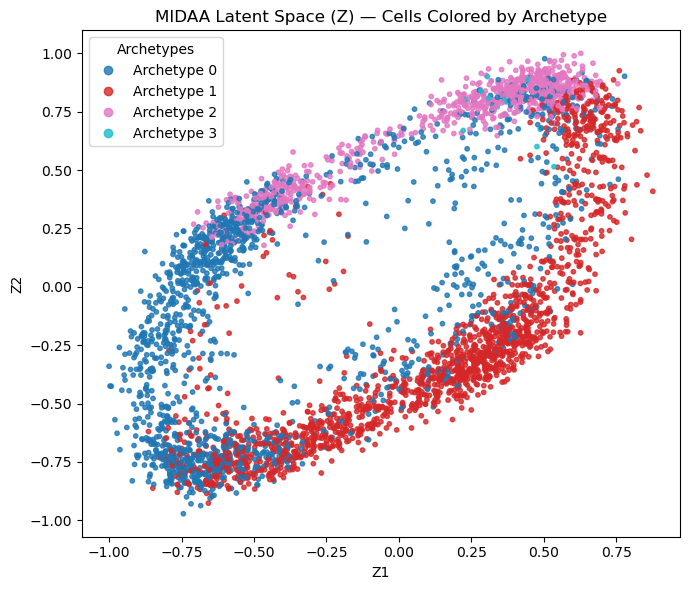

In [5]:
import numpy as np

def extract_mida_matrices(aa_result, input_matrix):
    iq = aa_result["inferred_quantities"]

    # A: (n_cells × n_archetypes)
    A = iq["A"]

    # Z: latent representation (n_cells × latent_dim)
    Z = iq["Z"]

    # B: archetype positions in latent space (n_archetypes × latent_dim)
    B = iq["B"]

    # archetypes_inferred: gene weights for each archetype
    # shape: (n_genes, n_archetypes)
    C = iq["archetypes_inferred"]

    # X: original input data
    X = input_matrix[0]   # (n_cells × n_genes)

    # Labels = archetype with highest membership
    labels = np.argmax(A, axis=1)

    return A, B, Z, C, X, labels

A, B, Z, C, X, labels = extract_mida_matrices(aa_result, input_matrix)

print("A (memberships):", A.shape)
print("B (latent archetype coords):", B.shape)
print("Z (latent cells):", Z.shape)
print("C (gene weights):", C.shape)
print("X (input data):", X.shape)
print("labels:", labels.shape)

import torch

# Save   three core MIDAA matrices
torch.save(
    {'A': A, 'B': B, 'C': C},
    "midaa_core_matrices.pth"
)

print("Saved A, B, C matrices to midaa_core_matrices.pth")


import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(7, 6))

scatter = plt.scatter(
    Z[:, 0], Z[:, 1],
    c=labels,
    s=10,
    cmap="tab10",       # better for discrete clusters
    alpha=0.8
)

plt.title("MIDAA Latent Space (Z) — Cells Colored by Archetype")
plt.xlabel("Z1")
plt.ylabel("Z2")

# Create legend for 4 archetypes
handles, _ = scatter.legend_elements()
plt.legend(handles, [f"Archetype {i}" for i in range(4)], title="Archetypes")

plt.tight_layout()
plt.show()

